# Modification of Santa's 2019 Starter Notebook for Genetic Algorithm method

## Import

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import time 
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# to save 
import pickle
from sklearn.externals import joblib

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) 
# will list all files under the input directory

import os

## Definitions

In [360]:
# Paths to folders/files
#PATH_INPUT = '/kaggle/input' #for kaggle
PATH_INPUT = 'kaggle/input'
PATH_TO_SAVE_DATA = "../../data"
PATH_BASELINE_0 = PATH_TO_SAVE_DATA + '/df_fake_news.pkl'
PATH_SAVE_PROB_FAM = PATH_TO_SAVE_DATA + '/df_prob_fam.pkl'
PATH_SAVE_DF_POP = PATH_TO_SAVE_DATA + '/df_pop.pkl'
PATH_SAVE_DF_POP_10 = PATH_TO_SAVE_DATA + '/df_pop_10.pkl'
# Data information
DAY_RANGE = list(range(1, 101)) # day before Christmas
DAY_RANGE_MIN = np.min(DAY_RANGE) 
DAY_RANGE_MAX = np.max(DAY_RANGE) 

# Hyper-parameters:
NB_FIRST_POP = 1000 # number of first population of choices 
R_FIRST_MUT = 0.01 # RATIO of mutation for first population
R_POP_MUT = 0.05 # RATIO of population mutation after first generation
R_MUT = 0.01 # RATIO of number of family choices mutated
DELTA_DAYS = 1 # delta of days around previous best day for generation/mutation
R_POP_LOST = 0.01 # Ratio of lost individuals in population 
NB_MAX_EPOCHS = 1000
# method 2 : by choices
DELTA_CHOICE = 1
CHOICE_RANGE_MIN = 0
CHOICE_RANGE_MAX = 10

In [26]:
for dirname, _, filenames in os.walk(PATH_INPUT):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

kaggle/input/.DS_Store
kaggle/input/santa-2019-workshop-scheduling/family_data.csv
kaggle/input/santa-2019-workshop-scheduling/sample_submission.csv


## Useful functions

In [415]:
def find_choice_range(choice_curr):
    '''
    select range of choices 
    from random between +/- delta choice around choice_curr
    
    return a range
    '''
    choice_min = np.min([np.max([CHOICE_RANGE_MIN, choice_curr - DELTA_CHOICE]), 
                          CHOICE_RANGE_MAX - 2 * DELTA_CHOICE])
    choice_max = np.min([CHOICE_RANGE_MAX, 
                        np.max([CHOICE_RANGE_MIN + 2 * DELTA_CHOICE, 
                        choice_curr + DELTA_CHOICE])]) + 1
    range_choice = range(choice_min, choice_max)
    
    return range_choice

def find_choice_from_day(day_curr, fam_id):
    '''
    find current choice according to day_curr and family id
    '''
    fam_days = data_choice.loc[fam_id]
    
    idx_choice_curr = fam_days[day_curr == fam_days].index
    
    if idx_choice_curr.shape[0] == 0:
        return 10 
    else:
        return idx_choice_curr[0]

def choose_day_prob(choice_curr, fam_id):
    '''
    find or choose the day of given choice number according to family choices
    
    if choice 10, then find a day randomly
    
    return a day
    '''
  
    choice_curr = np.array(choice_curr)
    
    vect_days_choice = data_choice.loc[fam_id, np.minimum(9, choice_curr)]
    vect_days_choice = np.array(vect_days_choice)
    
    idx_choice_10 = np.nonzero(choice_curr == 10)[0]
    if idx_choice_10.shape[0] > 0:
        nb_10 = idx_choice_10.shape[0]
        vect_all_days = np.array(range(1, 101))
        vect_prob_10 = np.array(df_prob_fam.astype("float").loc[fam_id])/ \
            df_prob_fam.loc[fam_id].sum()
        #vect_prob_10 = np.ones(vect_all_days.shape[0])
        vect_prob_10[idx_choice_10] = 0
        vect_prob_10 = vect_prob_10 / np.sum(vect_prob_10)
        days_10 = np.random.choice(vect_all_days, size=nb_10,
                                  p=vect_prob_10)
        #print("idx_choice_10: ", idx_choice_10)
        for i_day, indice in enumerate(idx_choice_10):
            
            if vect_days_choice.shape:
                
                ''' print("days_10: ", days_10)
                print("vect_days_choice: ", np.array(vect_days_choice))
                print("vect_days_choice[indice]: ", 
                      np.array(vect_days_choice)[indice])
                print("i_day: ", i_day)
                print("days_10[i_day]: ", days_10[i_day])
                print("indice : ", indice)'''

                vect_days_choice[indice] = days_10[i_day]
            else:
                vect_days_choice = np.array(days_10[i_day])
            
        return vect_days_choice
    else:
        return vect_days_choice
    
def mutation_day(day_curr, fam_id, nb_mut=1, flag_prob=False):
    # function mutation of days : around choices
    # day_curr -> choice_curr -> range choices -> 
    # choose randomly 1 choice -> 1 day 
    # fam_id = 0
    # day_curr = 100
    # mutation_day(day_curr, fam_id, 10)
    choice_curr = find_choice_from_day(day_curr, fam_id)
    #print("choice_curr: ", choice_curr)
    range_choices = find_choice_range(choice_curr)
    #print("range_choices: ", np.array(range_choices))
    
    if flag_prob:
        vect_prob = np.array(df_prob.loc[data.loc[fam_id,"n_people"], 
                             ['choice_{}'.format(i) for i in range_choices]])
        vect_prob = vect_prob / vect_prob.sum()
        #print("vect_prob: ", vect_prob)
        choice_new = np.random.choice(range_choices, size=nb_mut,
                                     p=vect_prob)
    else:
        choice_new = np.random.choice(range_choices, size=nb_mut)
        
    
    #print("choice_new: ", choice_new)
    return choose_day_prob(choice_new, fam_id)

def find_day_range(day_curr):
    '''
    select range of days from random between +/- delta day around day_curr
    
    return a range
    '''
    day_min = np.min([np.max([DAY_RANGE_MIN, day_curr-DELTA_DAYS]), 
                      DAY_RANGE_MAX - 2 * DELTA_DAYS])
    day_max = np.min([DAY_RANGE_MAX, np.max([DAY_RANGE_MIN + 2 * DELTA_DAYS, 
                                             day_curr + DELTA_DAYS])]) + 1
    range_day = range(day_min, day_max)

    return range_day


def generate_pop(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        # find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))

        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

## Read in the family information and sample submission

In [99]:
fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = PATH_INPUT + '/santa-2019-workshop-scheduling/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

data_choice = data.iloc[:,range(0,10)]
data_choice.columns = range(0,10)
data_choice.head()

0   1   2   3   4   5   6   7   8   9
family_id                                         
0           52  38  12  82  33  75  64  76  10  28
1           26   4  82   5  11  47  38   6  66  61
2          100  54  25  12  27  82  10  89  80  33
3            2  95   1  96  32   6  40  31   9  59
4           53   1  47  93  26   3  46  16  42  39

In [29]:
data.head()

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  \
family_id                                                               
0                52        38        12        82        33        75   
1                26         4        82         5        11        47   
2               100        54        25        12        27        82   
3                 2        95         1        96        32         6   
4                53         1        47        93        26         3   

           choice_6  choice_7  choice_8  choice_9  n_people  
family_id                                                    
0                64        76        10        28         4  
1                38         6        66        61         4  
2                10        89        80        33         3  
3                40        31         9        59         2  
4                46        16        42        39         4

In [30]:
submission.head()

assigned_day
family_id              
0                   100
1                    99
2                    98
3                    97
4                    96

## Create some lookup dictionaries and define constants

You don't need to do it this way. :-)

In [31]:
family_size_dict = data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

## Cost Function
Very un-optimized  ;-)

In [32]:
def cost_function(prediction, flag_prompt=False):

    penalty = 0

    # We'll use this to count the number of people scheduled each day
    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        # Using our lookup dictionaries to make simpler variable names
        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n
    if flag_prompt:
        print("penalty for only families: ", penalty)
    # for each date, check total occupancy
    #  (using soft constraints instead of hard constraints)
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000
    if flag_prompt:
        print("daily_occupancy: ", daily_occupancy)
    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count
    if flag_prompt:
        print("accounting_cost: ", accounting_cost)
    penalty += accounting_cost

    return penalty

## Simple Opimization Approach : baseline #0

For each family, loop over their choices, and if keep it if the score improves. There's a lot of easy improvement that can be made to this code.

In [33]:
t_fit_0 = time.time()
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)
new = best.copy()
cost_best = start_cost
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        cost_curr = cost_function(temp) # test cost
        if cost_curr < cost_best:
            new = temp.copy()
            cost_best = cost_curr
            #print("Current best cost: ", cost_best)

submission['assigned_day'] = new
score = cost_function(new)
submission.to_csv(f'submission_{score}.csv')
print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022


KeyboardInterrupt: 

In [172]:
np.array(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
# save for later use
joblib.dump(submission, PATH_BASELINE_0)


## Explore day occupancy

In [350]:
# show how people choose days : 
# 5 first choices 
# 5 last choices
#data
df_day = pd.DataFrame(index=range(1,101))
df_day["all_choices"] = 0
df_day["first_choices"] = 0
df_day["mid_choices"] = 0
df_day["last_choices"] = 0
list_choice_all = ['choice_{}'.format(n) for n in range(0, 10)]
list_choice_first = ['choice_{}'.format(n) for n in range(0, 3)]
list_choice_mid = ['choice_{}'.format(n) for n in range(3, 7)]
list_choice_last = ['choice_{}'.format(n) for n in range(7, 10)]

# for each first choices, add to each days the number of people
for choice in list_choice_all:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "all_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_first:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "first_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_mid:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "mid_choices"] += data.at[indice, "n_people"]
        
for choice in list_choice_last:
    for indice in data.index:
        df_day.loc[data.at[indice, choice], 
                   "last_choices"] += data.at[indice, "n_people"]
        
df_day.head()

all_choices  first_choices  mid_choices  last_choices
1        11568           4391         4449          2728
2         1806            501          729           576
3         3607           1021         1526          1060
4         3872           1148         1585          1139
5         3907           1181         1544          1182

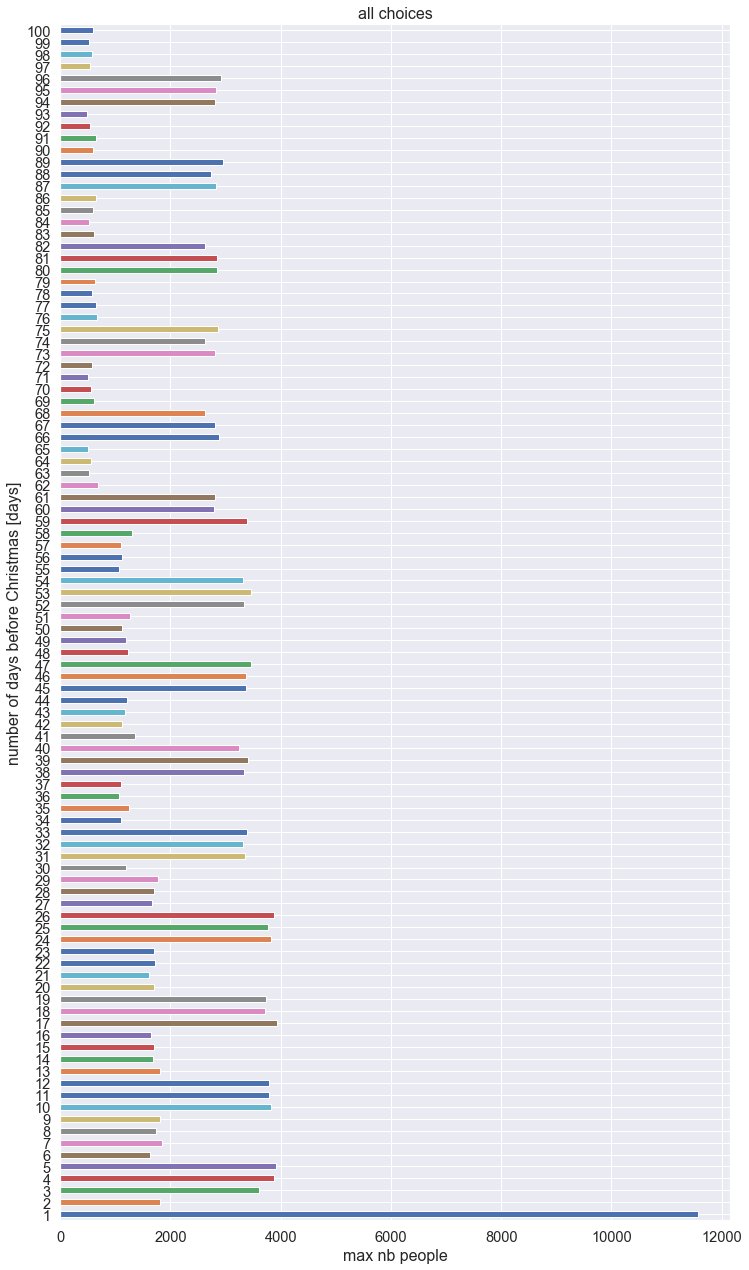

In [351]:
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_day["all_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("all choices");

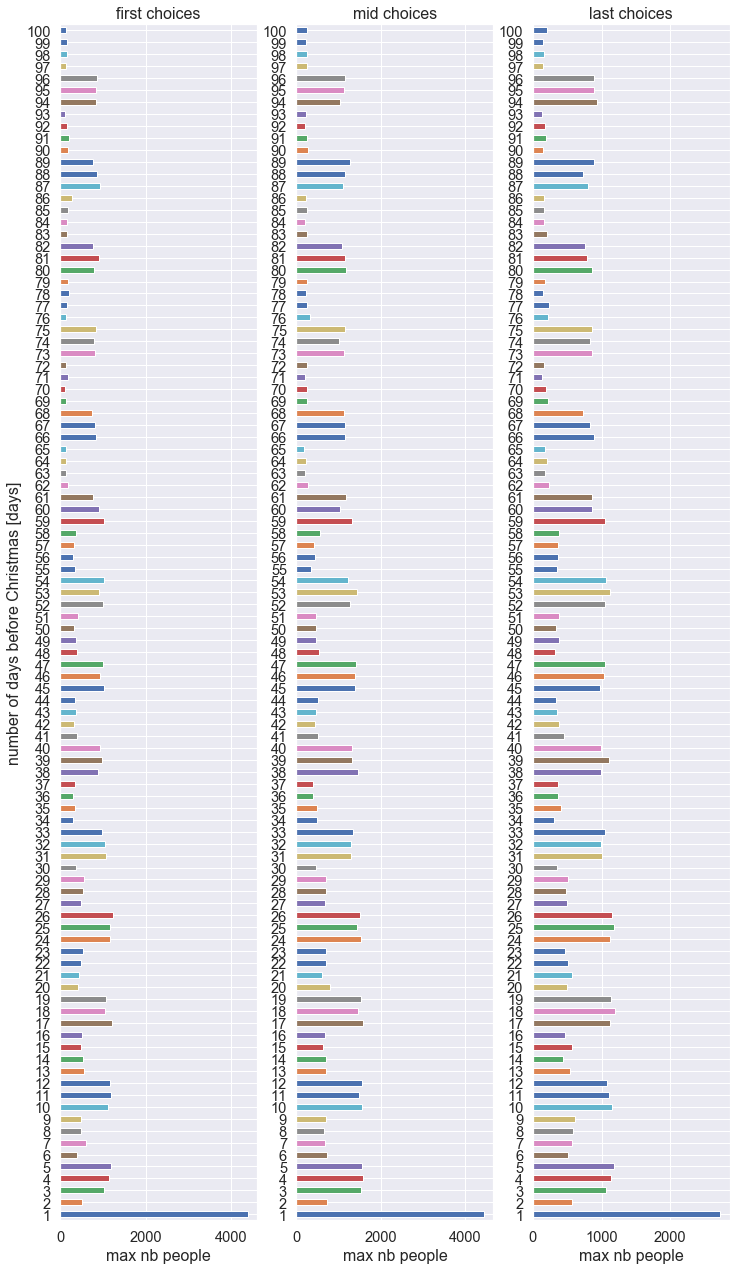

In [352]:
fig = plt.figure(figsize=(12, 22)) 
#plt.title("potential people vs choices")

ax1 = fig.add_subplot(1,3,1)
df_day["first_choices"].plot.barh(ax=ax1)
ax1.set_xlabel("max nb people")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("first choices")

ax2 = fig.add_subplot(1,3,2)
df_day["mid_choices"].plot.barh(ax=ax2)
ax2.set_xlabel("max nb people")
ax2.set_title("mid choices")

ax3 = fig.add_subplot(1,3,3)
df_day["last_choices"].plot.barh(ax=ax3)
ax3.set_xlabel("max nb people")
ax3.set_title("last choices");

### Creation of probality matrix

In [353]:
'''df_prob = df_fam_cost.filter(items=list_choice)
vect_penalty = [0, np.max(np.max(df_prob))]
print("vect_penalty: ", vect_penalty)
vect_prob = [0.1, 0.03]
print("vect_prob", vect_prob)
# family : number of people
df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
for indice in df_prob.index:
    df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

df_prob'''

df_prob_day = pd.DataFrame(df_day["all_choices"])
df_prob_day["prob"] = 1/df_prob_day["all_choices"]
df_prob_day["prob"] = df_prob_day["prob"] / df_prob_day["prob"].sum()
df_prob_day["prob"].sum()

1.0

In [354]:
df_prob_day.head()

all_choices      prob
1        11568  0.001098
2         1806  0.007036
3         3607  0.003523
4         3872  0.003282
5         3907  0.003252

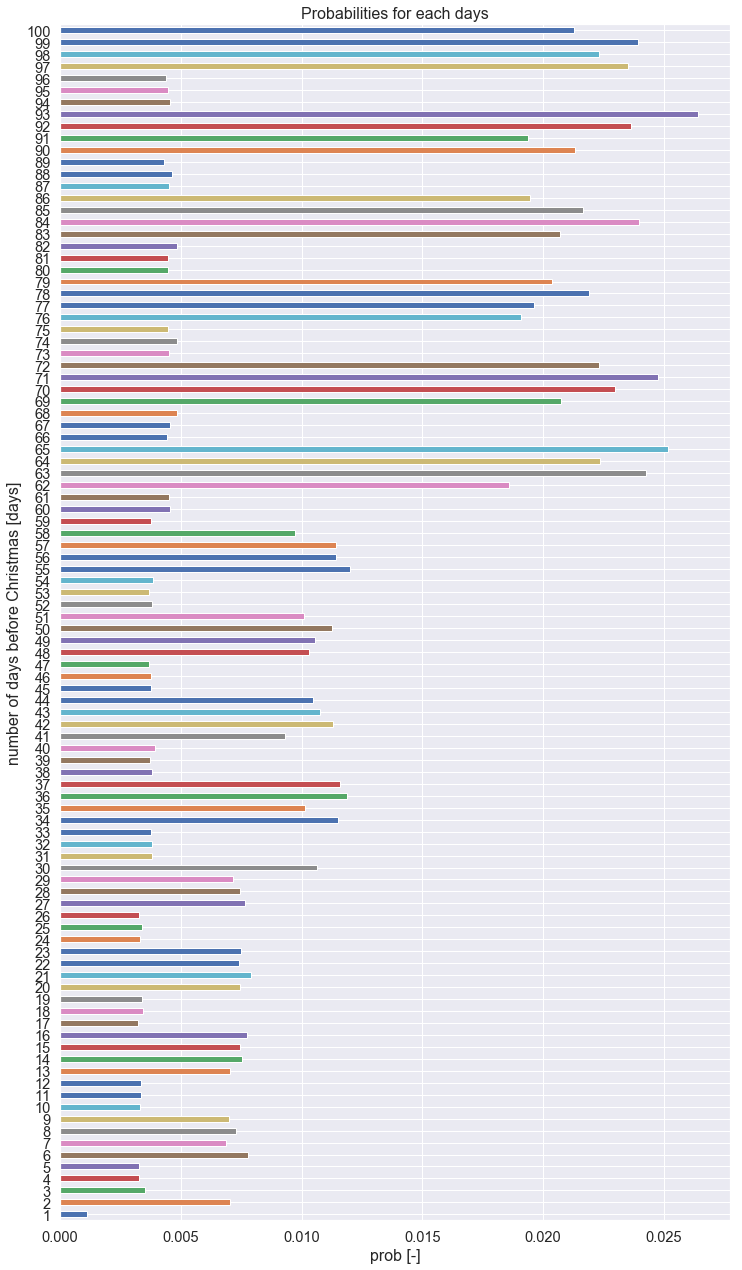

In [355]:
#df_prob_day["prob"].plot.barh()
fig = plt.figure(figsize=(12, 22)) 
ax1 = fig.gca()
df_prob_day["prob"].plot.barh(ax=ax1)
ax1.set_xlabel("prob [-]")
ax1.set_ylabel("number of days before Christmas [days]");
ax1.set_title("Probabilities for each days");

## Explore family choice cost

In [41]:
def cost_family(n=1, choice=0):
    # Calculate the penalty for not getting top preference
    penalty = 0
    if choice == 0:
        penalty += 0
    elif choice == 1:
        penalty += 50
    elif choice == 2:
        penalty += 50 + 9 * n
    elif choice == 3:
        penalty += 100 + 9 * n
    elif choice == 4:
        penalty += 200 + 9 * n
    elif choice == 5:
        penalty += 200 + 18 * n
    elif choice == 6:
        penalty += 300 + 18 * n
    elif choice == 7:
        penalty += 300 + 36 * n
    elif choice == 8:
        penalty += 400 + 36 * n
    elif choice == 9:
        penalty += 500 + 36 * n + 199 * n
    else:
        penalty += 500 + 36 * n + 398 * n
        
    return penalty

In [42]:
cost_family(choice=1, n=2)

50

### Evolution of cost by number of people into family

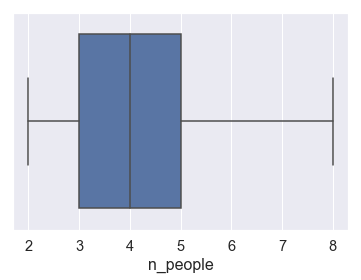

In [43]:
ax = sns.boxplot(x=data["n_people"])


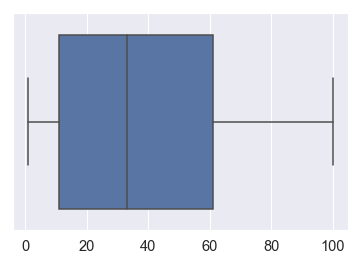

In [44]:
ax = sns.boxplot(data)

In [45]:
df_fam_cost = pd.DataFrame(index = np.array(range(np.min(data["n_people"]),
                            np.max(data["n_people"]) + 1)),
            columns=['choice_{}'.format(n_choice) for n_choice in range(0, 11)])
df_fam_cost["n"] = df_fam_cost.index
df_fam_cost

choice_0 choice_1 choice_2 choice_3 choice_4 choice_5 choice_6 choice_7  \
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
5      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
6      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
7      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
8      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

  choice_8 choice_9 choice_10  n  
2      NaN      NaN       NaN  2  
3      NaN      NaN       NaN  3  
4      NaN      NaN       NaN  4  
5      NaN      NaN       NaN  5  
6      NaN      NaN       NaN  6  
7      NaN      NaN       NaN  7  
8      NaN      NaN       NaN  8

In [46]:
df_fam_cost["choice_0"] = df_fam_cost["n"].apply(cost_family, args=(0,))
df_fam_cost["choice_1"] = df_fam_cost["n"].apply(cost_family, args=(1,))
df_fam_cost["choice_2"] = df_fam_cost["n"].apply(cost_family, args=(2,))
df_fam_cost["choice_3"] = df_fam_cost["n"].apply(cost_family, args=(3,))
df_fam_cost["choice_4"] = df_fam_cost["n"].apply(cost_family, args=(4,))
df_fam_cost["choice_5"] = df_fam_cost["n"].apply(cost_family, args=(5,))
df_fam_cost["choice_6"] = df_fam_cost["n"].apply(cost_family, args=(6,))
df_fam_cost["choice_7"] = df_fam_cost["n"].apply(cost_family, args=(7,))
df_fam_cost["choice_8"] = df_fam_cost["n"].apply(cost_family, args=(8,))
df_fam_cost["choice_9"] = df_fam_cost["n"].apply(cost_family, args=(9,))
df_fam_cost["choice_10"] = df_fam_cost["n"].apply(cost_family, args=(10,))
df_fam_cost

choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2         0        50        68       118       218       236       336   
3         0        50        77       127       227       254       354   
4         0        50        86       136       236       272       372   
5         0        50        95       145       245       290       390   
6         0        50       104       154       254       308       408   
7         0        50       113       163       263       326       426   
8         0        50       122       172       272       344       444   

   choice_7  choice_8  choice_9  choice_10  n  
2       372       472       970       1368  2  
3       408       508      1205       1802  3  
4       444       544      1440       2236  4  
5       480       580      1675       2670  5  
6       516       616      1910       3104  6  
7       552       652      2145       3538  7  
8       588       688      2380       3972  8

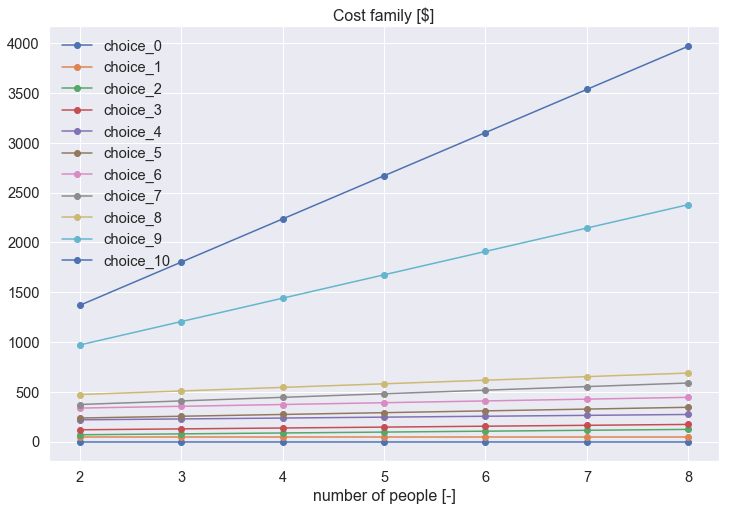

In [47]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost family [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for choice in list_choice:
    plt.plot(df_fam_cost["n"], df_fam_cost[choice], '-o', label=choice)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("number of people [-]");

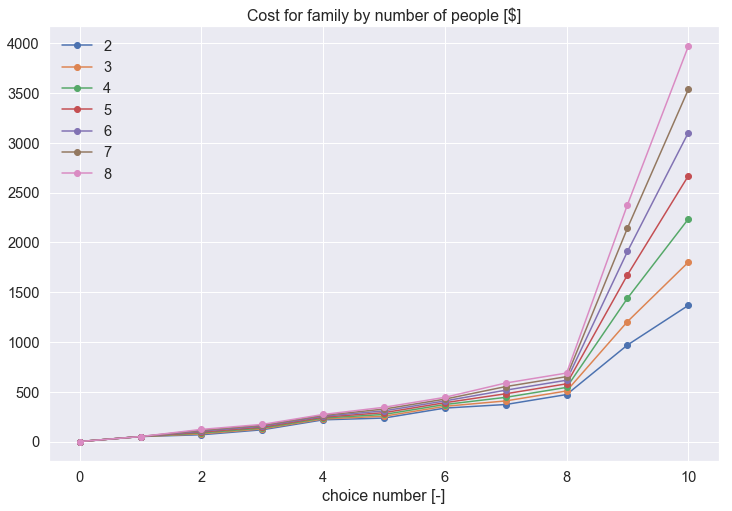

In [48]:
fig = plt.figure(figsize=(12, 8))
plt.title("Cost for family by number of people [$]")
list_choice = ['choice_{}'.format(n_choice) for n_choice in range(0, 11)]

for n in df_fam_cost["n"]:
    plt.plot(range(0, df_fam_cost.filter(items=list_choice).shape[1]), 
        np.array(df_fam_cost.filter(items=list_choice).filter(items=[n], 
                                                              axis=0))[0],
             '-o', label=n)
plt.legend(loc='upper left');

ax = fig.gca()
ax.set_xlabel("choice number [-]");

### Creation of probability matrix

In [346]:
def create_df_fam_cost_prob(df_fam_cost, p_min=0.03, p_max=0.1, ):
    # For genetic algo, for start population or mutation,
    # try to assign probabilities of choice for each possibilities : 
    # from  choice 0 to 10.
    df_prob = df_fam_cost.filter(items=list_choice)
    vect_penalty = [0, np.max(np.max(df_prob))]
    print("vect_penalty: ", vect_penalty)
    vect_prob = [p_max, p_min]
    print("vect_prob", vect_prob)
    # family : number of people
    df_prob = df_prob.applymap(lambda x: np.interp(x, vect_penalty, vect_prob))
    for indice in df_prob.index:
        df_prob.loc[indice] = df_prob.loc[indice]/df_prob.loc[indice].sum()

    return df_prob  


#### p max = 0.1, p min = 0.03

In [336]:
df_prob = create_df_fam_cost_prob(df_fam_cost)
df_prob

vect_penalty:  [0, 3972]
vect_prob [0.1, 0.03]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.097481  0.096622  0.096313  0.095454  0.093736  0.093427  0.091709   
3  0.098846  0.097975  0.097505  0.096634  0.094892  0.094422  0.092680   
4  0.100250  0.099367  0.098731  0.097848  0.096081  0.095445  0.093678   
5  0.101695  0.100799  0.099992  0.099096  0.097304  0.096498  0.094705   
6  0.103182  0.102272  0.101291  0.100381  0.098563  0.097581  0.095763   
7  0.104713  0.103790  0.102627  0.101705  0.099859  0.098697  0.096851   
8  0.106290  0.105353  0.104004  0.103068  0.101195  0.099846  0.097973   

   choice_7  choice_8  choice_9  choice_10  
2  0.091090  0.089372  0.080817   0.073980  
3  0.091739  0.089997  0.077855   0.067455  
4  0.092406  0.090639  0.074809   0.060746  
5  0.093092  0.091300  0.071675   0.053843  
6  0.093799  0.091980  0.068450   0.046738  
7  0.094526  0.092681  0.065129   0.039423  
8  0.095275  0.093402  0.061708   0.031887

#### p max = 0.5, p min = 0.01

In [347]:
df_prob_2 = create_df_fam_cost_prob(df_fam_cost, p_min=0.01, p_max=1)
df_prob_2

vect_penalty:  [0, 3972]
vect_prob [1, 0.01]


choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  choice_6  \
2  0.100491  0.099238  0.098787  0.097535  0.095030  0.094580  0.092075   
3  0.102556  0.101278  0.100588  0.099310  0.096753  0.096063  0.093507   
4  0.104708  0.103403  0.102463  0.101158  0.098549  0.097609  0.094999   
5  0.106952  0.105619  0.104419  0.103087  0.100421  0.099221  0.096556   
6  0.109294  0.107932  0.106461  0.105099  0.102375  0.100904  0.098180   
7  0.111742  0.110349  0.108594  0.107202  0.104417  0.102662  0.099877   
8  0.114301  0.112877  0.110825  0.109401  0.106552  0.104501  0.101652   

   choice_7  choice_8  choice_9  choice_10  
2  0.091173  0.088669  0.076195   0.066227  
3  0.092127  0.089571  0.071754   0.056494  
4  0.093120  0.090511  0.067127   0.046353  
5  0.094156  0.091491  0.062301   0.035777  
6  0.095238  0.092514  0.057264   0.024738  
7  0.096368  0.093583  0.052001   0.013205  
8  0.097550  0.094701  0.046497   0.001143

In [364]:

# save
joblib.dump(df_prob_2, PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

['../../data/df_prob_2.pkl']

## Creation of days probabilities by family

In [348]:
def create_df_prob_day_fam(df_prob_day, df_prob):
    df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
    for fam_id in df_prob_fam.index:
        # give at first to each families the same day probabilities
        df_prob_fam.loc[fam_id] = df_prob_day["prob"]
        # and add prob for each day choosen by families
        for choice in list_choice_all: 
            prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
            day_curr = data.at[fam_id, choice]
            # add this prob of these days to family into df_prob_fam
            df_prob_fam.loc[fam_id, day_curr] += prob_curr
            #print(day_curr)
            #print(prob_curr)
        df_prob_fam.loc[fam_id] = \
            df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    return df_prob_fam

In [359]:
df_prob_fam = create_df_prob_day_fam(df_prob_day, df_prob_2)
# save
joblib.dump(df_prob_fam, PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')

['../../data/df_prob_fam_2.pkl']

In [358]:

'''df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)
for fam_id in df_prob_fam.index:
    # give at first to each families the same day probabilities
    df_prob_fam.loc[fam_id] = df_prob_day["prob"]
    # and add prob for each day choosen by families
    for choice in list_choice_all: 
        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]
        day_curr = data.at[fam_id, choice]
        # add this prob of these days to family into df_prob_fam
        df_prob_fam.loc[fam_id, day_curr] += prob_curr
        #print(day_curr)
        #print(prob_curr)
    df_prob_fam.loc[fam_id] = \
        df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()
    
     
    
df_prob_fam'''

'df_prob_fam = pd.DataFrame(index = data.index, columns=df_prob_day.index)\nfor fam_id in df_prob_fam.index:\n    # give at first to each families the same day probabilities\n    df_prob_fam.loc[fam_id] = df_prob_day["prob"]\n    # and add prob for each day choosen by families\n    for choice in list_choice_all: \n        prob_curr = df_prob.at[data.at[fam_id, "n_people"], choice]\n        day_curr = data.at[fam_id, choice]\n        # add this prob of these days to family into df_prob_fam\n        df_prob_fam.loc[fam_id, day_curr] += prob_curr\n        #print(day_curr)\n        #print(prob_curr)\n    df_prob_fam.loc[fam_id] =         df_prob_fam.loc[fam_id] / df_prob_fam.loc[fam_id].sum()\n    \n     \n    \ndf_prob_fam'

In [413]:
# save
joblib.dump(df_prob_fam, PATH_SAVE_PROB_FAM)

['../../data//df_prob_fam.pkl']

In [322]:
df_prob_fam.loc[0].plot()

NameError: name 'df_prob_fam' is not defined

## From Scratch

### Generate first population

In [381]:

np.random.choice(np.array(range(0, df_prob.shape[1])), size=1, 
                 p=df_prob.loc[2].values)

array([6])

In [165]:
data.loc[indice,"n_people"]

4

In [265]:
# df_choice : contains number choices of all the population of 5000 families
df_choice = pd.DataFrame()

# for each family, create n choice among their first choice
for indice in data.index:
    vect_pop = np.random.choice(np.array(range(0, df_prob.shape[1])), 
                            size=NB_FIRST_POP, 
                            p=df_prob.loc[data.loc[indice,"n_people"]].values)
    df_choice[indice] = vect_pop
df_choice.shape

(1000, 5000)

In [266]:
df_choice.head()

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     3     3     5     8     3     9     4     1     2     6  ...      0   
1     7     3     0     6     0     9     9     4     8     7  ...      2   
2     1     4     1    10     4     1     5     7     5     5  ...      0   
3     4     9     6     0     6     6     2     5     5     1  ...      7   
4     8     7     7     5     3     4     5     2     8     3  ...      5   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0     4     7     2     0     9     1     1     8     6  
1     3     3     3     5     1     1     9     2     3  
2     4     6     6     7     0     8     4     8     5  
3     7     8     4     2     6    10     2     2     4  
4     8     8     0     6     7     1     1     8    10  

[5 rows x 5000 columns]

### Treatment of choices

In [301]:
# for choice number 10, choose a day among all days except choices 0 to 9 : 
# probability is choosen uniform

def choose_day(choice_curr, fam_id):
    if choice_curr == 10:
        vect_choices = list(range(1, 101))
        for indice in range(0, 10):
            vect_choices.remove(data.loc[fam_id, "choice_{}".format(indice)])    
        #print(vect_choices)
        return np.random.choice(vect_choices, size=1)[0]
    else:
        return data.at[fam_id, "choice_{}".format(choice_curr)]


In [268]:
df_pop = df_choice.copy()
for fam_id in df_pop.columns:
    df_pop[fam_id] = df_pop[fam_id].apply(choose_day, args=(fam_id,))
    
df_pop

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0      82     5    82     9    93     2    91    11     1    96  ...     47   
1      76     5   100    40    53     2    99    10    53    47  ...     74   
2      38    11    54    54    26    59    32    50    33    18  ...     47   
3      33    61    10     2    46    35     1    17    33    88  ...     94   
4      10     6    89     6    93    60    32    52    53    50  ...     46   
5      52     5    27    96    39    26    57    88     1    39  ...      5   
6      38    40    27    59     1    32    99    11     1    28  ...     61   
7      33    97    25    93     3    59    88    17    33    96  ...     74   
8      75    11    80     6    46    78     4    88    18    39  ...      4   
9      52    11    25    32    93    12    57    48    12    18  ...     32   
10     82    11    10     2     1    50    99    66    89    39  ...     80   
11     12     4    27    95    84    60    99    17     1    88  ...     12   
12     38    49    80    31    26     2    91    17    10    18  ...     19   
13     82    55    33    95     1    12    91    66    16    18  ...     46   
14     12     4    89     9    53    60    91    17    12    28  ...      4   
15     38    26    82     9    90    32     1    10    39     1  ...     19   
16     12    82    82    40    47     2     3    66    60    28  ...     19   
17     12    26   100    31     3    60     4    25     1    46  ...      4   
18     10    66    10    59    53    60    99    50    33     1  ...     74   
19     28    66     9    59    26     2    39    10    10    26  ...     80   
20     64    66    54     9    39    26    28    10    10    46  ...     80   
21     76    38    80    31    46     5    88    11    89    18  ...     74   
22     82    66    33    40    93     2     3    17    16    39  ...     61   
23     33     4    29     2    90    32    57    32    10    28  ...     47   
24     12    47    10     9     3    12     3    88    18    26  ...     33   
25     76    29    25     9    53    59     3    10    33    88  ...     32   
26     52    61    33     6    47    26    91    88    60    47  ...     12   
27     64     4    33    40     1    26    26    50    67    39  ...     12   
28     76    47    82    31    53     2    39    11     1    19  ...     32   
29     76     4    80     2    39    60     1    50    16    88  ...     94   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
970    12    38    10    32     1    32     1    88    33    18  ...     80   
971    10    11    66    95    93    50    32    25    18    39  ...     12   
972    12    38    82     2    39    59    99    11    33    28  ...     47   
973    12    47    33    31    39    26    99    66    12    39  ...     80   
974    39    26    27     2     3     3    28    20    60    26  ...      4   
975    10     6    25    96     1    18    39    95    33    18  ...     32   
976    28    47    80    25    16    35     4    25    89    96  ...     19   
977    75    11    25    31    26    50    39    10    12    39  ...     74   
978    10    82    82    40    26     3     3    52    33    73  ...     32   
979    28     5    25    59    39     5     4    66    60    46  ...     47   
980    12    66   100    32    46    60     1    11    12    47  ...     80   
981    28    26    27    31    93    35     3    10    18    26  ...     47   
982    33    61   100     4    93    26    88    88    33    88  ...     80   
983    33     6    27     6     3    35    39    95    53    28  ...     47   
984    10    61    54    31    16    12    28    25    33    39  ...     19   
985    75    66   100    44    26     5    57    50    18    28  ...     47   
986    10     4    10     2     3    32     4    50    12    96  ...     46   
987    52     6    33    59    39    60    39    10     1    88  ...     32   
988    38    82    12    59    93    35    28    11    

### Evaluation of cost for all population

In [262]:
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    4.405331e+62
1    8.627548e+56
2    1.346244e+59
3    5.624646e+61
4    7.746507e+61
5    2.343082e+51
6    4.598295e+66
7    7.982710e+56
8    1.347359e+57
9    1.105799e+60
10   3.893130e+59
11   3.936574e+58
12   1.621637e+63
13   8.510317e+52
14   5.895593e+59
15   3.340682e+55
16   1.358198e+57
17   1.079468e+64
18   5.832608e+60
19   4.579328e+60
20   7.319800e+50
21   5.446452e+56
22   2.165810e+54
23   9.561077e+62
24   8.721047e+45
25   2.068069e+60
26   2.355648e+53
27   1.844667e+70
28   7.279254e+61
29   2.525690e+60
..            ...
970  2.353798e+53
971  1.748307e+63
972  6.841872e+70
973  1.497576e+52
974  4.638929e+67
975  1.978431e+53
976  1.781199e+60
977  1.518226e+59
978  1.235310e+60
979  4.351479e+56
980  1.345891e+54
981  2.343632e+57
982  2.683243e+62
983  6.366676e+52
984  3.907275e+53
985  5.390364e+70
986  1.374826e+58
987  1.280499e+55
988  8.832879e+63
989  8.525397e+64
990  5.807663e+56
991  1.103143e+55
992  7.475599e+53
993  9.080145e+57
994  7.006668e+57
995  4.932254e+65
996  5.323330e+49
997  2.865219e+55
998  3.724813e+63
999  1.000177e+55

[1000 rows x 1 columns]

In [269]:
best = submission['assigned_day'].tolist()
len(best)

5000

In [335]:
cost_function(best)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

## From baseline #0

In [173]:
# reload 
submission = pd.read_csv('submission_672254.0276683343.csv')

In [558]:
# reload
df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)

### Generate first population

Generation of 1000 "families choices" ensemble from baseline : 
- Number of individuals for first generation : NB_FIRST_POP
- Ratio of generation/mutation for first generation : R_FIRST_MUT
- delta around day choosen  : +/- DELTA_DAYS

Try to find fine tune these hyperparameters (I don't have method ! )

In [384]:
#submission = pd.read_csv('submission_672254.0276683343.csv')

In [174]:
# check baseline
cost_function(submission['assigned_day'])

672254.0276683343

In [81]:


find_day_range(50)

range(49, 52)

In [17]:
fam_id = 0
submission.at[fam_id, 'assigned_day']

52

In [ ]:
df_pop = generate_pop()
print("df_pop.shape: ", df_pop.shape)
df_pop.head()

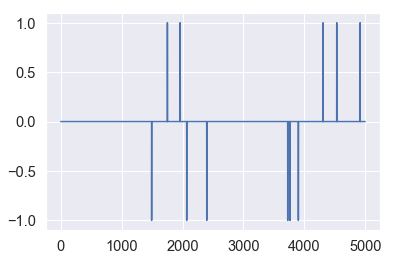

In [571]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

A effacer : 

In [83]:
# GENERATION OF FIRST POP:

# initialize with same previous best indiv.
df_pop = pd.DataFrame(index=range(0, NB_FIRST_POP), 
                      columns=submission["family_id"])

for fam_id in submission["family_id"]:
    df_pop[fam_id] = submission.at[fam_id,'assigned_day']

# create NB_FIRST_POP family choices from baseline :
# use probabilies
# df_pop : contains number choices of all the population of 5000 families
# df_pop = f(indiv., family)
# for each family, create n choice among their first choice
# use day probabilities specific for each family
for fam_id in data.index: # data = f(family, num choice)
    # day current is the old best submission day for this family
    day_curr = submission.at[fam_id, 'assigned_day']
    # find range around day curr +/- DELTA
    range_curr = find_day_range(day_curr)
    # retrict probabilities to range # df_prob_fam = f(fam_id, day)
    day_prob = df_prob_fam.astype("float").loc[fam_id,range_curr]/df_prob_fam.\
        loc[fam_id,range_curr].sum()
    # choose randomly with probabilities days around old best day
    vect_pop = np.random.choice(np.array(range_curr), 
                            size=NB_FIRST_POP, 
                            p=np.array(day_prob))
    
    # apply the new days only a part of pop : R_FIRST_MUT [-]
    range_mut = np.random.choice(range(0, NB_FIRST_POP), 
                                 size=int(R_FIRST_MUT*NB_FIRST_POP))
    
    #df_pop[fam_id] = submission['assigned_day']
    
    df_pop.loc[range_mut, fam_id] = vect_pop[range_mut]

# keep the best : 
df_pop.loc[0] = submission['assigned_day']

print("df_pop.shape: ", df_pop.shape)
df_pop.head()

df_pop.shape:  (1000, 5000)


family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     1  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

### Save pop

In [84]:
# save
joblib.dump(df_pop, PATH_SAVE_DF_POP)

['../../data//df_pop.pkl']

### Evaluation #1

In [570]:
# load 
df_pop = joblib.load(PATH_SAVE_DF_POP)

In [544]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
0    672254.027668
21   673249.435665
632  675341.022931
587  675579.598524
904  675800.361230
552  676043.157413
148  676060.161931
215  676639.495767
599  676960.819718
550  677205.766828

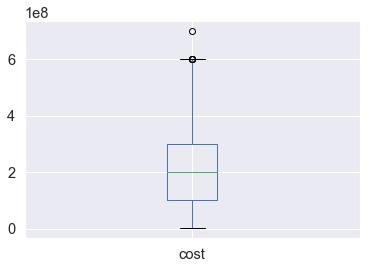

In [545]:
df_cost.boxplot()

### Loop over generations

In [546]:
# load 
#df_pop = joblib.load(PATH_SAVE_DF_POP)
#df_pop.shape

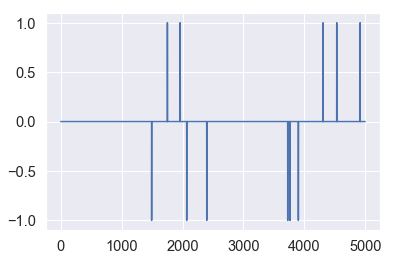

In [547]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

 
GENERATION #0 / nb. pop: 1000
nb_survivor:  990
              cost
990  672254.027668
991  673249.435665
21   675086.477112
238  675663.626834
743  675797.897188
Timing epoch:  13.22744607925415
 
GENERATION #1 / nb. pop: 992
nb_survivor:  982
              cost
982  672254.027668
983  673249.435665
302  675468.568847
303  675777.101886
561  676477.414141
Timing epoch:  13.66027307510376
 
GENERATION #2 / nb. pop: 984
nb_survivor:  974
              cost
0    672254.027668
974  672254.027668
975  673249.435665
805  674974.609299
845  675310.694047
Timing epoch:  12.444685935974121


Text(0, 0.5, 'cost [$]')

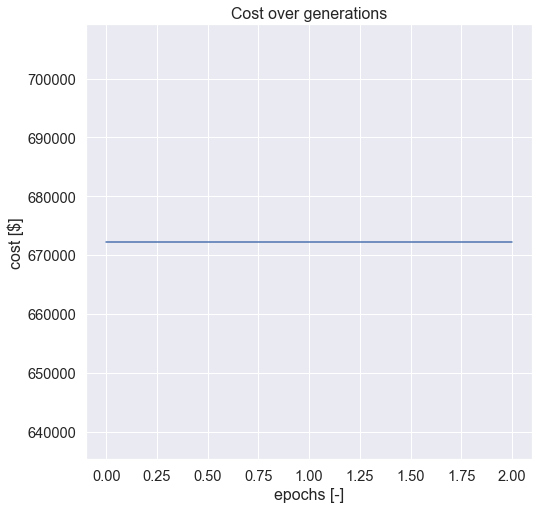

In [548]:
nb_seeds = 2 # number of seed sources : keep them along epochs
# LOOP OVER GENERATIONS 
list_best_cost = []
for gen_id in range(0, NB_MAX_EPOCHS):
    t_fit_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]
    # LOST WORST INDIV.

    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - nb_seeds)
    if (nb_survivor+nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))
    
    # check if previous best is still here
    #if name_best not in vect_survivor:
        # else replace by previous best
        #vect_survivor[0] = name_best

    df_pop = df_pop.loc[vect_survivor] 
    #df_pop_surv=df_pop.copy()

    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace first indiv
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)
    #df_pop_cross=df_pop.copy()

    # MUTATION
    # mutation of R_MUT * number of indiv 
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best 
    df_pop = df_pop.append(df_best, ignore_index=True)

    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 

    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(nb_seeds+3))
    
    t_fit_1 = time.time()
    print("Timing epoch: ", t_fit_1 - t_fit_0)
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

cost rankings:
[672254.0276683343, 673249.4356646903, 674728.7104080453, 675890.9699308008, 675979.8116211004]


In [518]:
list_name_best

[983, 314]

In [519]:
df_pop.loc[list_name_best]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


family_id  0     1      2     3     4     5     6     7     8     9     ...   \
983         NaN   NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...    
314        52.0  26.0  100.0   2.0  53.0  59.0  88.0  25.0  18.0   1.0  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
983         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
314        61.0  29.0  90.0  62.0  52.0  16.0  88.0  32.0  67.0  13.0  

[2 rows x 5000 columns]

In [510]:

np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), vect_survivor))

array([990, 803, 867, 174, 379, 990, 193, 507, 142, 785, 631, 533, 422,
       203, 580, 977, 387,  20, 393, 612, 803, 505, 811, 359,  46, 461,
       944, 169, 775, 897, 467, 648, 976, 376, 518, 114, 741, 108, 181,
       768, 745, 330, 750, 705,  25, 163, 406, 736, 924,   5, 761,  40,
       430, 723, 876,  52, 879, 102, 820, 899, 516, 374, 337, 249, 302,
       559, 950, 759, 217, 920, 546, 550, 482,  35,  66, 277, 686, 492,
       601, 248, 267, 195, 522, 791,   1, 228, 534, 287, 969, 242, 814,
       988, 746, 835, 531, 166, 312, 110, 839,  50, 951,  80, 925, 341,
       189, 140, 433, 513, 933, 152, 680, 959, 927,  94, 921, 500, 470,
       582,  18, 887, 480, 639, 429,  79, 399, 397, 269,  51, 216, 424,
       415, 188, 731, 451, 810, 818, 272, 136, 663, 562, 457, 443,  15,
       673, 545, 871, 548, 788, 782, 172, 633, 848,  92, 535, 958, 437,
       726, 836, 564, 787, 598, 986, 698,  83,  95, 843, 261, 150, 450,
         7, 180, 348, 754, 692, 834, 520, 645, 144, 230, 640, 22

In [492]:
df_cost_sort.shape

(991, 3)

In [499]:
df_cost_sort.iloc[0:2,2] = 0

In [500]:
df_cost_sort

cost  rank      prob
990  6.722540e+05     1  0.000000
803  6.740412e+05     2  0.000000
723  6.743262e+05     3  0.044585
976  6.752261e+05     4  0.033438
5    6.753410e+05     5  0.026751
871  6.757341e+05     6  0.022292
25   6.760432e+05     7  0.019108
768  6.766036e+05     8  0.016719
169  6.766395e+05     9  0.014862
46   6.769514e+05    10  0.013375
461  6.770891e+05    11  0.012159
20   6.776100e+05    12  0.011146
920  6.779448e+05    13  0.010289
397  6.782558e+05    14  0.009554
761  6.782579e+05    15  0.008917
470  6.782830e+05    16  0.008360
376  6.783910e+05    17  0.007868
522  6.783969e+05    18  0.007431
580  6.786026e+05    19  0.007040
114  6.787559e+05    20  0.006688
40   6.792164e+05    21  0.006369
925  6.794635e+05    22  0.006080
242  6.795082e+05    23  0.005815
759  6.797625e+05    24  0.005573
141  6.800638e+05    25  0.005350
516  6.801533e+05    26  0.005144
142  6.804211e+05    27  0.004954
550  6.806977e+05    28  0.004777
387  6.807988e+05    29  0.004612
986  6.809628e+05    30  0.004458
..            ...   ...       ...
914  5.007527e+08   962  0.000139
256  5.007535e+08   963  0.000139
949  5.007557e+08   964  0.000139
781  5.007564e+08   965  0.000139
207  5.007603e+08   966  0.000138
629  5.007668e+08   967  0.000138
335  5.007700e+08   968  0.000138
24   5.007761e+08   969  0.000138
816  6.006767e+08   970  0.000138
953  6.006855e+08   971  0.000138
904  6.006864e+08   972  0.000138
638  6.006886e+08   973  0.000137
143  6.006930e+08   974  0.000137
872  6.006934e+08   975  0.000137
933  6.006985e+08   976  0.000137
873  6.006998e+08   977  0.000137
830  6.007444e+08   978  0.000137
84   6.007514e+08   979  0.000137
547  6.007529e+08   980  0.000136
259  6.007560e+08   981  0.000136
586  6.007606e+08   982  0.000136
911  6.007691e+08   983  0.000136
235  6.008261e+08   984  0.000136
795  7.006870e+08   985  0.000136
491  7.007442e+08   986  0.000136
678  7.007611e+08   987  0.000136
201  7.007786e+08   988  0.000135
910  8.007432e+08   989  0.000135
942  8.007518e+08   990  0.000135
436  1.000755e+09   991  0.000135

[991 rows x 3 columns]

In [480]:
df_cost_sort.shape

(991, 3)

In [477]:
list_best_indiv[1]

family_id
0        52
1        26
2       100
3         2
4        53
5        59
6        88
7        25
8        18
9         1
10       92
11       19
12       52
13       54
14       45
15       22
16       46
17       47
18       75
19        3
20        3
21       56
22       33
23       19
24       75
25       16
26       58
27       38
28       27
29       89
       ... 
4970     22
4971      8
4972      8
4973      5
4974     15
4975     83
4976     39
4977     54
4978     40
4979     55
4980     28
4981     44
4982     47
4983     16
4984     41
4985     25
4986     82
4987     22
4988     88
4989     92
4990     61
4991     29
4992     90
4993     62
4994     52
4995     16
4996     88
4997     32
4998     67
4999     13
Name: 803, Length: 5000, dtype: int64

In [451]:
df_cost_sort.head()

cost  rank      prob
198  6.696340e+05     1  0.170270
77   3.010847e+08     2  0.085135
19   4.009763e+08     3  0.056757
64   4.012742e+08     4  0.042567
52   5.007436e+08     5  0.034054

In [296]:
cost_function(df_pop.loc[0].tolist())

672254.0276683343

In [308]:
cost_function(best_indiv)

669634.0092723282

In [304]:
vect_best_choice=[]
for fam_id in df_pop.columns:
    vect_best_choice.append(choose_day(0,fam_id))

In [307]:
len(vect_best_choice)

5000

In [309]:
cost_function(vect_best_choice)

1.0647073818721987e+90

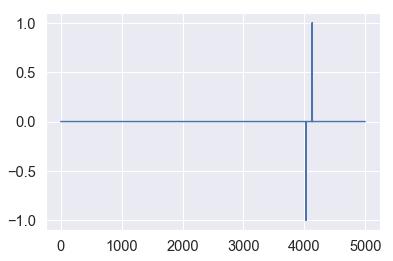

In [298]:
plt.plot(df_pop.columns, df_pop.loc[0] - best_indiv)
   

283


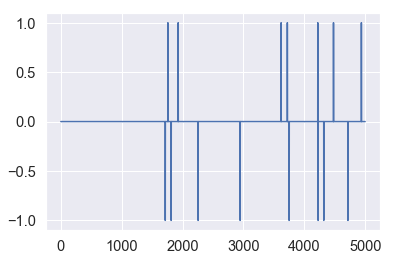

In [229]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop_surv.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])
   

283


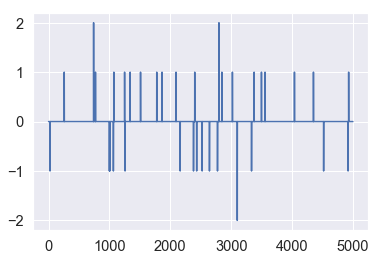

In [230]:
print(indice_mut[0])
plt.plot(df_pop.columns, df_pop.loc[indice_mut[0]]\
         -df_pop_cross.loc[indice_mut[0]])

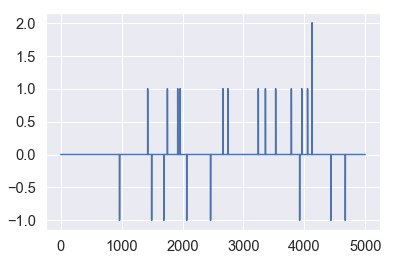

In [217]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

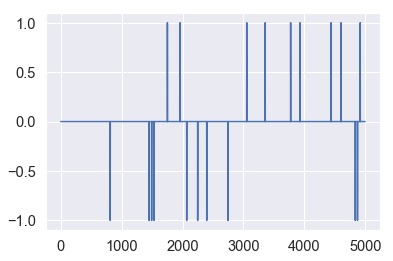

In [191]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

## From multiple baselines

### Find several baseline / seed source

#### Create ranges

In [52]:
submission = pd.read_csv(fpath, index_col='family_id')

In [53]:
submission.shape[0]

5000

In [54]:
NB_FIRST_SEED = 10
df_range = pd.DataFrame(index=range(0, NB_FIRST_SEED), 
                        columns=range(0, submission.shape[0]))

df_range.loc[0] = np.array(range(0, submission.shape[0]))

df_range.loc[1] = np.array(range(submission.index.max(), 
                                 submission.index.min()-1, -1))  

#for indice in range(2, NB_FIRST_SEED):
    

In [55]:
start_pt = np.linspace(0, submission.shape[0], 
                       num=int((NB_FIRST_SEED)/2)+1, dtype="int")
start_pt = start_pt[1:-1]
start_pt

array([1000, 2000, 3000, 4000])

In [56]:
np.array(range(10,0,-1))

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [57]:
indice = 2
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = np.concatenate((np.array(range(start_pt[st_id], 
                                                submission.shape[0])), 
               np.array(range(0, start_pt[st_id]))))

indice = 6
for st_id, _ in enumerate(start_pt):
    df_range.loc[indice+st_id] = \
        np.concatenate((range(start_pt[st_id], 0-1, -1), 
                range(submission.shape[0]-1, start_pt[st_id], -1)))

df_range    

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [24]:
df_range.min().min()

0

In [25]:
df_range.max().max()

4999

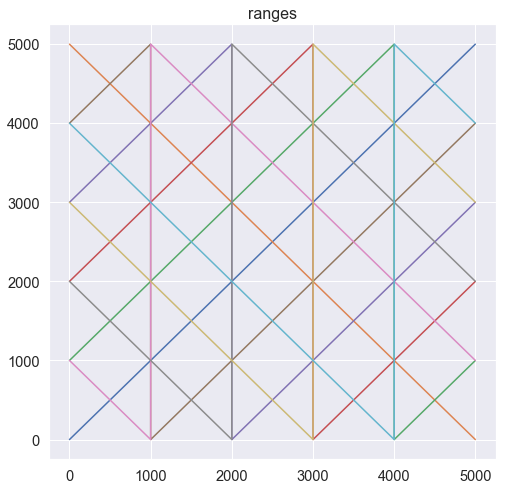

In [26]:
fig = plt.figure(figsize=(8, 8))
plt.title("ranges")
for indice in range(0, df_range.shape[0]):
    plt.plot(df_range.loc[indice])


#### Evaluate baselines & save

In [449]:
t_fit_0 = time.time()
submission = pd.read_csv(fpath, index_col='family_id')
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_cost = cost_function(best)
print("Start cost: ", start_cost)

for indice in df_range.index:
    # initiate first inviduate 
    new = best.copy()
    cost_best = start_cost
    # choose current range in df_range
    range_optim = df_range.loc[indice]
    # loop over each family with this current range
    for fam_id in range_optim:
        # loop over each family choice
        for pick in range(10):
            day = choice_dict[f'choice_{pick}'][fam_id]
            temp = new.copy()
            temp[fam_id] = day # add in the new pick
            cost_curr = cost_function(temp) # test cost
            if cost_curr < cost_best:
                new = temp.copy()
                cost_best = cost_curr
                #print("Current best cost: ", cost_best)

    submission['assigned_day'] = new
    score = cost_function(new)
    submission.to_csv(f'submission_range{indice}.csv')
    print(f'Score: {score}')

t_fit_1 = time.time()
print("Timing: ", t_fit_1 - t_fit_0)



Start cost:  10641498.403135022
Score: 657505.9426095837
Score: 677348.7683962411
Score: 605419.8337085167
Score: 656228.7546566363
Timing:  1473.9507336616516


### Generate first population

#### Method 1:  Day by days

In [27]:
df_range

0     1     2     3     4     5     6     7     8     9     ...   4990  \
0     0     1     2     3     4     5     6     7     8     9  ...   4990   
1  4999  4998  4997  4996  4995  4994  4993  4992  4991  4990  ...      9   
2  1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...    990   
3  2000  2001  2002  2003  2004  2005  2006  2007  2008  2009  ...   1990   
4  3000  3001  3002  3003  3004  3005  3006  3007  3008  3009  ...   2990   
5  4000  4001  4002  4003  4004  4005  4006  4007  4008  4009  ...   3990   
6  1000   999   998   997   996   995   994   993   992   991  ...   1010   
7  2000  1999  1998  1997  1996  1995  1994  1993  1992  1991  ...   2010   
8  3000  2999  2998  2997  2996  2995  2994  2993  2992  2991  ...   3010   
9  4000  3999  3998  3997  3996  3995  3994  3993  3992  3991  ...   4010   

   4991  4992  4993  4994  4995  4996  4997  4998  4999  
0  4991  4992  4993  4994  4995  4996  4997  4998  4999  
1     8     7     6     5     4     3     2     1     0  
2   991   992   993   994   995   996   997   998   999  
3  1991  1992  1993  1994  1995  1996  1997  1998  1999  
4  2991  2992  2993  2994  2995  2996  2997  2998  2999  
5  3991  3992  3993  3994  3995  3996  3997  3998  3999  
6  1009  1008  1007  1006  1005  1004  1003  1002  1001  
7  2009  2008  2007  2006  2005  2004  2003  2002  2001  
8  3009  3008  3007  3006  3005  3004  3003  3002  3001  
9  4009  4008  4007  4006  4005  4004  4003  4002  4001  

[10 rows x 5000 columns]

In [88]:
# HYPERPARAMETERS
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop(seed_indiv=seed_indiv, nb_pop=nb_indiv_curr, 
                               r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 100 / done: 100.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  91.89893078804016
# 1 / nb_indiv_curr: 100 / done: 200.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  84.70671820640564
# 2 / nb_indiv_curr: 100 / done: 300.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  85.22644996643066
# 3 / nb_indiv_curr: 100 / done: 400.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  694.5717761516571
# 4 / nb_indiv_curr: 100 / done: 500.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  111.29203581809998
# 5 / nb_indiv_curr: 100 / done: 600.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation population is done.
Timing :  82.3056640625
# 6 / nb_indiv_curr: 100 / done: 700.0
Generating population : 
nb_pop:  100
r_mut:  0.01
Generation populati

family_id  0     1     2     3     4     5     6     7     8     9     ...   \
0            52    26   100     2    53    59    88    25    18     1  ...    
1            52    26   100     2    53    59    88    25    18     1  ...    
2            52    26   100     2    53    59    88    25    18     2  ...    
3            52    26   100     2    53    59    88    25    18     1  ...    
4            52    26   100     2    53    59    88    25    18     1  ...    

family_id  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999  
0            61    29    90    62    52    16    88    32    67    13  
1            61    29    90    62    52    16    88    32    67    13  
2            61    29    90    62    52    16    88    32    67    13  
3            61    29    90    62    52    16    88    32    67    13  
4            61    29    90    62    52    16    88    32    67    13  

[5 rows x 5000 columns]

#### Save pop

In [141]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS),
           compress=True)

['../../data/df_pop1000_fs10_rfm0.01_dd3.pkl']

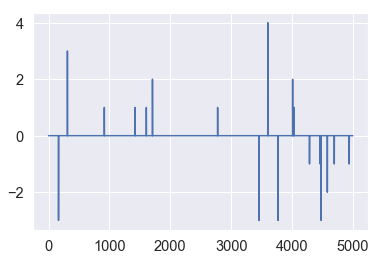

In [90]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [91]:
df_pop.describe()

family_id         0            1            2            3            4     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         56.001000    52.999000    99.998000    30.492000    52.994000   
std          22.875102    38.102583     0.063246    43.550713     0.141365   
min          38.000000     4.000000    98.000000     1.000000    50.000000   
25%          38.000000    26.000000   100.000000     2.000000    53.000000   
50%          52.000000    26.000000   100.000000     2.000000    53.000000   
75%          52.000000    99.000000   100.000000    97.000000    53.000000   
max         100.000000   100.000000   100.000000    97.000000    54.000000   

family_id         5            6            7            8            9     \
count      1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean         42.814000    71.211000    59.097000    22.196000    52.184000   
std          13.234748    33.633133    29.094434    12.608273    30.926471   
min          29.000000     1.000000    22.000000    16.000000     1.000000   
25%          32.000000    88.000000    25.000000    18.000000    50.000000   
50%          32.000000    88.000000    48.000000    18.000000    50.000000   
75%          59.000000    88.000000    93.000000    18.000000    88.000000   
max          62.000000    91.000000    95.000000    60.000000    91.000000   

family_id     ...             4990         4991        4992         4993  \
count         ...      1000.000000  1000.000000  1000.00000  1000.000000   
mean          ...        56.706000    43.411000    27.59700    62.003000   
std           ...         8.773742     4.811989    31.21979     0.170353   
min           ...        47.000000    28.000000     9.00000    60.000000   
25%           ...        47.000000    45.000000    12.00000    62.000000   
50%           ...        61.000000    45.000000    12.00000    62.000000   
75%           ...        61.000000    45.000000    12.00000    62.000000   
max           ...        77.000000    47.000000    91.00000    65.000000   

family_id         4994         4995         4996        4997         4998  \
count      1000.000000  1000.000000  1000.000000  1000.00000  1000.000000   
mean         53.405000    16.010000    67.609000    38.80100    79.506000   
std           2.797642     0.141138    31.183369    13.60016    12.502811   
min          51.000000    16.000000    20.000000    29.00000    67.000000   
25%          52.000000    16.000000    20.000000    32.00000    67.000000   
50%          52.000000    16.000000    88.000000    32.00000    81.000000   
75%          52.000000    16.000000    88.000000    32.00000    92.000000   
max          59.000000    18.000000    91.000000    66.00000    93.000000   

family_id        4999  
count      1000.00000  
mean         14.19500  
std           3.60527  
min          11.00000  
25%          13.00000  
50%          13.00000  
75%          13.00000  
max          25.00000  

[8 rows x 5000 columns]

#### Method 2:  Choice by Choices

In [416]:
def generate_pop_choices(seed_indiv=None, nb_pop=None, r_mut=None):
    '''
    Generate first polulation from one seed individual by family choices
    - seed_indiv # best submission 
    - nb_pop # number of individual
    - r_mut # ratio of individual who mutate for each family
    
    return dataFrame population
    '''
    t_fit_0 = time.time()
    # GENERATION OF FIRST POP:
    print("Generating population : ")
    # definitions:
    if seed_indiv is None:
        seed_indiv = submission
    if nb_pop is None:
        nb_pop = NB_FIRST_POP
    if r_mut is None:
        r_mut = R_FIRST_MUT
    #print("seed_indiv: ", seed_indiv)
    print("nb_pop: ", nb_pop)
    print("r_mut: ", r_mut)
    # initialize with same previous best indiv.
    df_pop = pd.DataFrame(index=range(0, nb_pop), 
                          columns=seed_indiv["family_id"])

    for fam_id in seed_indiv["family_id"]:
        df_pop[fam_id] = seed_indiv.at[fam_id,'assigned_day']

    # create nb_pop family choices from baseline :
    # use probabilies
    # df_pop : contains number choices of all the population of 5000 families
    # df_pop = f(indiv., family)
    # for each family, create n choice among their first choice
    # use day probabilities specific for each family
    for fam_id in data.index: # data = f(family, num choice)
        # day current is the old best seed_indiv day for this family
        day_curr = seed_indiv.at[fam_id, 'assigned_day']
        
        vect_pop_mutated = mutation_day(day_curr, fam_id, nb_mut=nb_pop)
        
        
        '''# find range around day curr +/- DELTA
        range_curr = find_day_range(day_curr)
        # retrict probabilities to range. use df_prob_fam = f(fam_id, day)
        day_prob = df_prob_fam.astype("float").loc[fam_id, range_curr]/ \
            df_prob_fam.loc[fam_id, range_curr].sum()
        # choose randomly with probabilities days around old best day
        vect_pop_mutated = np.random.choice(np.array(range_curr), 
                                size=nb_pop, 
                                p=np.array(day_prob))'''

        
        # apply the new days only a part of pop : r_mut [-]
        range_mut = np.random.choice(range(0, nb_pop), 
                                     size=int(r_mut*nb_pop))

        df_pop.loc[range_mut, fam_id] = vect_pop_mutated[range_mut]

    # keep the best : 
    df_pop.loc[0] = seed_indiv['assigned_day']
    
    print("Generation population is done.")
    t_fit_1 = time.time()
    print("Timing : ", t_fit_1 - t_fit_0)
    
    return df_pop

In [419]:
# HYPERPARAMETERS
DELTA_CHOICE = 1
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

#df_prob_fam = joblib.load(PATH_SAVE_PROB_FAM)
df_prob_fam = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_fam_2.pkl')
df_prob = joblib.load(PATH_TO_SAVE_DATA + '/df_prob_2.pkl')

nb_indiv_done = 0
nb_range = df_range.index.shape[0]
for i_seed in df_range.index:
    # choose number of indiv.
    nb_indiv_curr = np.floor(NB_FIRST_POP/df_range.shape[0])
    nb_indiv_done += nb_indiv_curr
    if i_seed == nb_range-1:
        if NB_FIRST_POP % nb_range != 0:
            nb_indiv_curr += NB_FIRST_POP % nb_range
    nb_indiv_curr = int(nb_indiv_curr)
    print("# {} / nb_indiv_curr: {} / done: {}".format(i_seed, nb_indiv_curr, 
                                                       nb_indiv_done))
    # load best indiv in range #i_seed
    seed_indiv = pd.read_csv(f'submission_range{i_seed}.csv')
    # generate sub-pop 
    df_pop_curr = generate_pop_choices(seed_indiv=seed_indiv, 
                                       nb_pop=nb_indiv_curr, 
                                       r_mut=R_FIRST_MUT)
    # add sub-pop to pop
    if i_seed == 0:
        df_pop = df_pop_curr
    else:
        df_pop = df_pop.append(df_pop_curr, ignore_index=True)

print("df_pop.shape: ", df_pop.shape) 
df_pop.head()

# 0 / nb_indiv_curr: 1 / done: 1.0
Generating population : 
nb_pop:  1
r_mut:  1
Generation population is done.
Timing :  14.214256763458252
# 1 / nb_indiv_curr: 1 / done: 2.0
Generating population : 
nb_pop:  1
r_mut:  1
Generation population is done.
Timing :  13.65388798713684
# 2 / nb_indiv_curr: 1 / done: 3.0
Generating population : 
nb_pop:  1
r_mut:  1
Generation population is done.
Timing :  19.413466215133667
# 3 / nb_indiv_curr: 1 / done: 4.0
Generating population : 
nb_pop:  1
r_mut:  1
Generation population is done.
Timing :  19.148458003997803
# 4 / nb_indiv_curr: 1 / done: 5.0
Generating population : 
nb_pop:  1
r_mut:  1
Generation population is done.
Timing :  17.26416301727295
# 5 / nb_indiv_curr: 1 / done: 6.0
Generating population : 
nb_pop:  1
r_mut:  1


KeyboardInterrupt: 

#### Save pop

In [141]:
# save
#joblib.dump(df_pop, PATH_SAVE_DF_POP_10)
#DELTA_DAYS = 3
#R_FIRST_MUT = 0.01
#NB_FIRST_POP = 1000
# POP
joblib.dump(df_pop,
            PATH_TO_SAVE_DATA + '/df_pop_choices{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS),
           compress=True)

['../../data/df_pop1000_fs10_rfm0.01_dd3.pkl']

### Evaluation #1

In [60]:
DELTA_DAYS = 3
R_FIRST_MUT = 0.01
NB_FIRST_POP = 1000

In [61]:
# load 
df_pop = joblib.load(PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT, 
                DELTA_DAYS))

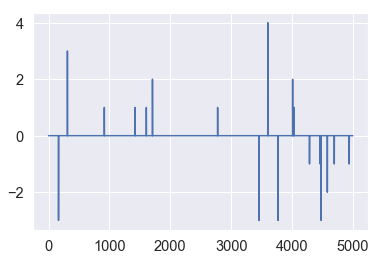

In [62]:
plt.plot(df_pop.columns,df_pop.loc[0]-df_pop.loc[1])

In [63]:
# create cost dataFrame for all population
df_cost = pd.DataFrame(index=df_pop.index)
df_cost["cost"] = np.nan 

for indice in df_cost.index:
    df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

df_cost.sort_values(by="cost").head(10)

cost
800  605419.833709
400  654844.718387
900  656228.754657
600  657505.942610
469  665206.371332
0    672254.027668
700  677348.768396
300  679410.167648
635  679441.505966
479  681538.723476

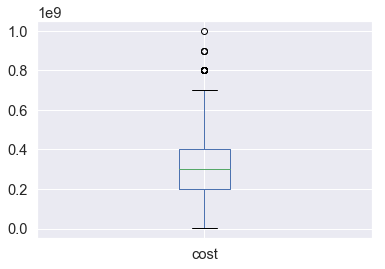

In [64]:
df_cost.boxplot()

### Loop over generations

 
GENERATION #0 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.2722675800323486
 
GENERATION #1 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1716480255126953
 
GENERATION #2 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1253290176391602
 
GENERATION #3 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1267318725585938
 
GENERATION #4 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1415128707885742
 
GENERATION #5 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1859838962554932
 
GENERATION #6 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1897549629211426
 
GENERATION #7 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1261727809906006
 
GENERATION #8 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
T

          cost
0  594189.6022
Timing epoch:  1.1204009056091309
 
GENERATION #72 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.135910987854004
 
GENERATION #73 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1193292140960693
 
GENERATION #74 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.2331809997558594
 
GENERATION #75 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1423091888427734
 
GENERATION #76 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.121894121170044
 
GENERATION #77 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.1253271102905273
 
GENERATION #78 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1449601650238037
 
GENERATION #79 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1653618812561035
 
GENERATION #80 / n

          cost
0  594189.6022
Timing epoch:  1.122413158416748
 
GENERATION #143 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1779251098632812
 
GENERATION #144 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1320390701293945
 
GENERATION #145 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1416990756988525
 
GENERATION #146 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.1980180740356445
 
GENERATION #147 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1335151195526123
 
GENERATION #148 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.4456250667572021
 
GENERATION #149 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.2426097393035889
 
GENERATION #150 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.2235238552093506
 
GENERAT

          cost
0  594189.6022
Timing epoch:  1.1227071285247803
 
GENERATION #214 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1069550514221191
 
GENERATION #215 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1070151329040527
 
GENERATION #216 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1043388843536377
 
GENERATION #217 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.1315219402313232
 
GENERATION #218 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1592230796813965
 
GENERATION #219 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.114396095275879
 
GENERATION #220 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1330761909484863
 
GENERATION #221 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1264581680297852
 
G

           cost
99  594189.6022
Timing epoch:  1.116560697555542
 
GENERATION #285 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.105154037475586
 
GENERATION #286 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1142656803131104
 
GENERATION #287 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1151881217956543
 
GENERATION #288 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1107866764068604
 
GENERATION #289 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.112023115158081
 
GENERATION #290 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.1115331649780273
 
GENERATION #291 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.125683307647705
 
GENERATION #292 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.111509084701538
 
GENERAT

          cost
0  594189.6022
Timing epoch:  1.132469892501831
 
GENERATION #356 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.1824109554290771
 
GENERATION #357 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1287288665771484
 
GENERATION #358 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1175141334533691
 
GENERATION #359 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1231892108917236
 
GENERATION #360 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1186940670013428
 
GENERATION #361 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.143493890762329
 
GENERATION #362 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1824150085449219
 
GENERATION #363 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1186130046844482
 
GENE

          cost
0  594189.6022
Timing epoch:  1.1837921142578125
 
GENERATION #427 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1268179416656494
 
GENERATION #428 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1302380561828613
 
GENERATION #429 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.117460012435913
 
GENERATION #430 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.1549193859100342
 
GENERATION #431 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.101212978363037
 
GENERATION #432 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.135422945022583
 
GENERATION #433 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.2303569316864014
 
GENERATION #434 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1516516208648682
 
GEN

           cost
49  594189.6022
Timing epoch:  1.1272590160369873
 
GENERATION #498 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1514160633087158
 
GENERATION #499 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1129488945007324
 
GENERATION #500 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1290669441223145
 
GENERATION #501 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.11702299118042
 
GENERATION #502 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1121561527252197
 
GENERATION #503 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.1145470142364502
 
GENERATION #504 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.1366956233978271
 
GENERATION #505 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.1094141006469727
 
GENERA

           cost
99  594189.6022
Timing epoch:  1.0588316917419434
 
GENERATION #569 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.0346198081970215
 
GENERATION #570 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.042377233505249
 
GENERATION #571 / nb. pop: 100
nb_survivor:  100
           cost
49  594189.6022
Timing epoch:  1.0363519191741943
 
GENERATION #572 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.0376381874084473
 
GENERATION #573 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.0403318405151367
 
GENERATION #574 / nb. pop: 100
nb_survivor:  100
          cost
0  594189.6022
Timing epoch:  1.0308947563171387
 
GENERATION #575 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.0496790409088135
 
GENERATION #576 / nb. pop: 100
nb_survivor:  100
           cost
99  594189.6022
Timing epoch:  1.0387647151947021
 
GEN

             cost
99  594122.610898
Timing epoch:  1.0418448448181152
 
GENERATION #639 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0271708965301514
 
GENERATION #640 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.0402350425720215
 
GENERATION #641 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0457429885864258
 
GENERATION #642 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.045091152191162
 
GENERATION #643 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0373952388763428
 
GENERATION #644 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.041581153869629
 
GENERATION #645 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0444188117980957
 
GENERATION #646 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing

            cost
0  594122.610898
Timing epoch:  1.0568981170654297
 
GENERATION #708 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0351927280426025
 
GENERATION #709 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0333988666534424
 
GENERATION #710 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0353186130523682
 
GENERATION #711 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0519418716430664
 
GENERATION #712 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0314109325408936
 
GENERATION #713 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0335659980773926
 
GENERATION #714 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.031952142715454
 
GENERATION #715 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing ep

             cost
99  594122.610898
Timing epoch:  1.0359089374542236
 
GENERATION #777 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.04653000831604
 
GENERATION #778 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.038187026977539
 
GENERATION #779 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0909130573272705
 
GENERATION #780 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0380380153656006
 
GENERATION #781 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0417089462280273
 
GENERATION #782 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0338120460510254
 
GENERATION #783 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0518813133239746
 
GENERATION #784 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing 

             cost
99  594122.610898
Timing epoch:  1.0400969982147217
 
GENERATION #846 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0454740524291992
 
GENERATION #847 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0386238098144531
 
GENERATION #848 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.0396230220794678
 
GENERATION #849 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0419881343841553
 
GENERATION #850 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0637848377227783
 
GENERATION #851 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0407941341400146
 
GENERATION #852 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0389399528503418
 
GENERATION #853 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Ti

             cost
99  594122.610898
Timing epoch:  1.0292890071868896
 
GENERATION #915 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0350821018218994
 
GENERATION #916 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0431110858917236
 
GENERATION #917 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0347530841827393
 
GENERATION #918 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0791852474212646
 
GENERATION #919 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0248610973358154
 
GENERATION #920 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0364980697631836
 
GENERATION #921 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.056455135345459
 
GENERATION #922 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timin

             cost
99  594122.610898
Timing epoch:  1.0396649837493896
 
GENERATION #984 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0336079597473145
 
GENERATION #985 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0295979976654053
 
GENERATION #986 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0262200832366943
 
GENERATION #987 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0296261310577393
 
GENERATION #988 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0450549125671387
 
GENERATION #989 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0465028285980225
 
GENERATION #990 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0549650192260742
 
GENERATION #991 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Ti

             cost
99  594122.610898
Timing epoch:  1.0454378128051758
 
GENERATION #1052 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0361371040344238
 
GENERATION #1053 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0525391101837158
 
GENERATION #1054 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0308570861816406
 
GENERATION #1055 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0355238914489746
 
GENERATION #1056 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.0454957485198975
 
GENERATION #1057 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0395419597625732
 
GENERATION #1058 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0530989170074463
 
GENERATION #1059 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.6

            cost
0  594122.610898
Timing epoch:  1.0653882026672363
 
GENERATION #1120 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0579898357391357
 
GENERATION #1121 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0537421703338623
 
GENERATION #1122 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0426781177520752
 
GENERATION #1123 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0359196662902832
 
GENERATION #1124 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0298552513122559
 
GENERATION #1125 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0389387607574463
 
GENERATION #1126 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.0374042987823486
 
GENERATION #1127 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898


             cost
99  594122.610898
Timing epoch:  1.1048250198364258
 
GENERATION #1188 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0825450420379639
 
GENERATION #1189 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.1181259155273438
 
GENERATION #1190 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.1729881763458252
 
GENERATION #1191 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.3464770317077637
 
GENERATION #1192 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.4148938655853271
 
GENERATION #1193 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.333414077758789
 
GENERATION #1194 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.4428231716156006
 
GENERATION #1195 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898

            cost
0  594122.610898
Timing epoch:  1.050475835800171
 
GENERATION #1256 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0381932258605957
 
GENERATION #1257 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0412018299102783
 
GENERATION #1258 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0510227680206299
 
GENERATION #1259 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0269551277160645
 
GENERATION #1260 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0356769561767578
 
GENERATION #1261 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0849826335906982
 
GENERATION #1262 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.1314210891723633
 
GENERATION #1263 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898

            cost
0  594122.610898
Timing epoch:  1.0424611568450928
 
GENERATION #1324 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0524749755859375
 
GENERATION #1325 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.036520004272461
 
GENERATION #1326 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0455718040466309
 
GENERATION #1327 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0408239364624023
 
GENERATION #1328 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.038172960281372
 
GENERATION #1329 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.048203945159912
 
GENERATION #1330 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0329890251159668
 
GENERATION #1331 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898

             cost
49  594122.610898
Timing epoch:  1.0311808586120605
 
GENERATION #1392 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0391781330108643
 
GENERATION #1393 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0438151359558105
 
GENERATION #1394 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0373408794403076
 
GENERATION #1395 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0415401458740234
 
GENERATION #1396 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.0418617725372314
 
GENERATION #1397 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0361547470092773
 
GENERATION #1398 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.0561141967773438
 
GENERATION #1399 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610

             cost
99  594122.610898
Timing epoch:  1.040060043334961
 
GENERATION #1460 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0613057613372803
 
GENERATION #1461 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0519418716430664
 
GENERATION #1462 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0532453060150146
 
GENERATION #1463 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0523099899291992
 
GENERATION #1464 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.049226999282837
 
GENERATION #1465 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0601229667663574
 
GENERATION #1466 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0504920482635498
 
GENERATION #1467 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.61089

             cost
99  594122.610898
Timing epoch:  1.0316431522369385
 
GENERATION #1528 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0415911674499512
 
GENERATION #1529 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0386812686920166
 
GENERATION #1530 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.043010950088501
 
GENERATION #1531 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0473432540893555
 
GENERATION #1532 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0480360984802246
 
GENERATION #1533 / nb. pop: 100
nb_survivor:  100
             cost
49  594122.610898
Timing epoch:  1.0392332077026367
 
GENERATION #1534 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0588219165802002
 
GENERATION #1535 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.

             cost
99  594122.610898
Timing epoch:  1.046694278717041
 
GENERATION #1596 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0479543209075928
 
GENERATION #1597 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0393238067626953
 
GENERATION #1598 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0412499904632568
 
GENERATION #1599 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0372490882873535
 
GENERATION #1600 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.046861171722412
 
GENERATION #1601 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0271220207214355
 
GENERATION #1602 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0316741466522217
 
GENERATION #1603 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.6

             cost
99  594122.610898
Timing epoch:  1.049941062927246
 
GENERATION #1664 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.1133499145507812
 
GENERATION #1665 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0423040390014648
 
GENERATION #1666 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Timing epoch:  1.0460867881774902
 
GENERATION #1667 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0263288021087646
 
GENERATION #1668 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0830321311950684
 
GENERATION #1669 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.0525469779968262
 
GENERATION #1670 / nb. pop: 100
nb_survivor:  100
            cost
0  594122.610898
Timing epoch:  1.031615972518921
 
GENERATION #1671 / nb. pop: 100
nb_survivor:  100
             cost
99  594122.610898
Ti

           cost
0  594106.98058
Timing epoch:  1.0356428623199463
 
GENERATION #1733 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0290486812591553
 
GENERATION #1734 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.072145938873291
 
GENERATION #1735 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0434391498565674
 
GENERATION #1736 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.035926103591919
 
GENERATION #1737 / nb. pop: 100
nb_survivor:  100
            cost
49  594106.98058
Timing epoch:  1.0283241271972656
 
GENERATION #1738 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.042179822921753
 
GENERATION #1739 / nb. pop: 100
nb_survivor:  100
            cost
49  594106.98058
Timing epoch:  1.0362367630004883
 
GENERATION #1740 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.03

            cost
99  594106.98058
Timing epoch:  1.0686290264129639
 
GENERATION #1802 / nb. pop: 100
nb_survivor:  100
            cost
49  594106.98058
Timing epoch:  1.0820307731628418
 
GENERATION #1803 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.107720136642456
 
GENERATION #1804 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0580570697784424
 
GENERATION #1805 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.055973768234253
 
GENERATION #1806 / nb. pop: 100
nb_survivor:  100
            cost
49  594106.98058
Timing epoch:  1.0640640258789062
 
GENERATION #1807 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.049246072769165
 
GENERATION #1808 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0644490718841553
 
GENERATION #1809 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  

            cost
49  594106.98058
Timing epoch:  1.0605370998382568
 
GENERATION #1871 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.041719913482666
 
GENERATION #1872 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0537898540496826
 
GENERATION #1873 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0835859775543213
 
GENERATION #1874 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0483508110046387
 
GENERATION #1875 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0705840587615967
 
GENERATION #1876 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0449872016906738
 
GENERATION #1877 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0407130718231201
 
GENERATION #1878 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  

            cost
99  594106.98058
Timing epoch:  1.0520918369293213
 
GENERATION #1940 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0521609783172607
 
GENERATION #1941 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0408248901367188
 
GENERATION #1942 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0461549758911133
 
GENERATION #1943 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0385618209838867
 
GENERATION #1944 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.043276071548462
 
GENERATION #1945 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoch:  1.0327520370483398
 
GENERATION #1946 / nb. pop: 100
nb_survivor:  100
           cost
0  594106.98058
Timing epoch:  1.0392420291900635
 
GENERATION #1947 / nb. pop: 100
nb_survivor:  100
            cost
99  594106.98058
Timing epoc

            cost
0  594084.720391
Timing epoch:  1.0669939517974854
 
GENERATION #2009 / nb. pop: 100
nb_survivor:  100
            cost
2  594084.720391
Timing epoch:  1.0462028980255127
 
GENERATION #2010 / nb. pop: 100
nb_survivor:  100
             cost
94  594084.720391
Timing epoch:  1.0439701080322266
 
GENERATION #2011 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0826897621154785
 
GENERATION #2012 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0984981060028076
 
GENERATION #2013 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0550949573516846
 
GENERATION #2014 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0358529090881348
 
GENERATION #2015 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0311710834503174
 
GENERATION #2016 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720

             cost
99  594084.720391
Timing epoch:  1.0290260314941406
 
GENERATION #2077 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.036336898803711
 
GENERATION #2078 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0495660305023193
 
GENERATION #2079 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.031580924987793
 
GENERATION #2080 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0388412475585938
 
GENERATION #2081 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0343968868255615
 
GENERATION #2082 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0446319580078125
 
GENERATION #2083 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0328218936920166
 
GENERATION #2084 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.72039

            cost
0  594084.720391
Timing epoch:  1.0282917022705078
 
GENERATION #2145 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0524768829345703
 
GENERATION #2146 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.078462839126587
 
GENERATION #2147 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.047929048538208
 
GENERATION #2148 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0822649002075195
 
GENERATION #2149 / nb. pop: 100
nb_survivor:  100
             cost
49  594084.720391
Timing epoch:  1.1284301280975342
 
GENERATION #2150 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0433650016784668
 
GENERATION #2151 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0413682460784912
 
GENERATION #2152 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Ti

             cost
49  594084.720391
Timing epoch:  1.033581018447876
 
GENERATION #2213 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0383799076080322
 
GENERATION #2214 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0355911254882812
 
GENERATION #2215 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.041717767715454
 
GENERATION #2216 / nb. pop: 100
nb_survivor:  100
             cost
49  594084.720391
Timing epoch:  1.04433012008667
 
GENERATION #2217 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0528409481048584
 
GENERATION #2218 / nb. pop: 100
nb_survivor:  100
             cost
99  594084.720391
Timing epoch:  1.0494110584259033
 
GENERATION #2219 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391
Timing epoch:  1.0387277603149414
 
GENERATION #2220 / nb. pop: 100
nb_survivor:  100
            cost
0  594084.720391


             cost
99  594041.866831
Timing epoch:  1.4531619548797607
 
GENERATION #2281 / nb. pop: 100
nb_survivor:  100
             cost
49  594041.866831
Timing epoch:  1.3804841041564941
 
GENERATION #2282 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.0901131629943848
 
GENERATION #2283 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.3954648971557617
 
GENERATION #2284 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.5451042652130127
 
GENERATION #2285 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  2.0473687648773193
 
GENERATION #2286 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.5121541023254395
 
GENERATION #2287 / nb. pop: 100
nb_survivor:  100
             cost
49  594041.866831
Timing epoch:  1.1610958576202393
 
GENERATION #2288 / nb. pop: 100
nb_survivor:  100
            cost
0  5940

             cost
99  594041.866831
Timing epoch:  1.2198967933654785
 
GENERATION #2349 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.231027364730835
 
GENERATION #2350 / nb. pop: 100
nb_survivor:  100
             cost
49  594041.866831
Timing epoch:  1.168921947479248
 
GENERATION #2351 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.176990032196045
 
GENERATION #2352 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.1593611240386963
 
GENERATION #2353 / nb. pop: 100
nb_survivor:  100
             cost
49  594041.866831
Timing epoch:  1.139963150024414
 
GENERATION #2354 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.1244962215423584
 
GENERATION #2355 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.1338162422180176
 
GENERATION #2356 / nb. pop: 100
nb_survivor:  100
             cost
49  594041.8

             cost
99  594041.866831
Timing epoch:  1.1440949440002441
 
GENERATION #2417 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.1359379291534424
 
GENERATION #2418 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.1413228511810303
 
GENERATION #2419 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.1527278423309326
 
GENERATION #2420 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.146191120147705
 
GENERATION #2421 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.1482391357421875
 
GENERATION #2422 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.1177940368652344
 
GENERATION #2423 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.143003225326538
 
GENERATION #2424 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Ti

             cost
99  594041.866831
Timing epoch:  1.1390471458435059
 
GENERATION #2485 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.144981861114502
 
GENERATION #2486 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.2508518695831299
 
GENERATION #2487 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.197756052017212
 
GENERATION #2488 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831
Timing epoch:  1.2062170505523682
 
GENERATION #2489 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.1890840530395508
 
GENERATION #2490 / nb. pop: 100
nb_survivor:  100
            cost
0  594041.866831
Timing epoch:  1.3427188396453857
 
GENERATION #2491 / nb. pop: 100
nb_survivor:  100
             cost
49  594041.866831
Timing epoch:  1.5698730945587158
 
GENERATION #2492 / nb. pop: 100
nb_survivor:  100
             cost
99  594041.866831


            cost
0  594012.724211
Timing epoch:  1.4677128791809082
 
GENERATION #2553 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.154231071472168
 
GENERATION #2554 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.2743382453918457
 
GENERATION #2555 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1816480159759521
 
GENERATION #2556 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.140265941619873
 
GENERATION #2557 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.5820930004119873
 
GENERATION #2558 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.6104700565338135
 
GENERATION #2559 / nb. pop: 100
nb_survivor:  100
             cost
49  594012.724211
Timing epoch:  2.5963492393493652
 
GENERATION #2560 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.72421

             cost
99  594012.724211
Timing epoch:  1.5354790687561035
 
GENERATION #2621 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.5682427883148193
 
GENERATION #2622 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1814560890197754
 
GENERATION #2623 / nb. pop: 100
nb_survivor:  100
             cost
49  594012.724211
Timing epoch:  1.5369038581848145
 
GENERATION #2624 / nb. pop: 100
nb_survivor:  100
             cost
49  594012.724211
Timing epoch:  1.3920960426330566
 
GENERATION #2625 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  2.559858798980713
 
GENERATION #2626 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  2.4124209880828857
 
GENERATION #2627 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.6297619342803955
 
GENERATION #2628 / nb. pop: 100
nb_survivor:  100
             cost
49  594012.72

            cost
0  594012.724211
Timing epoch:  1.1610431671142578
 
GENERATION #2689 / nb. pop: 100
nb_survivor:  100
             cost
49  594012.724211
Timing epoch:  1.1894001960754395
 
GENERATION #2690 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1842939853668213
 
GENERATION #2691 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1445739269256592
 
GENERATION #2692 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1630280017852783
 
GENERATION #2693 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.138268232345581
 
GENERATION #2694 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1955080032348633
 
GENERATION #2695 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.178386926651001
 
GENERATION #2696 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211


            cost
0  594012.724211
Timing epoch:  1.220763921737671
 
GENERATION #2757 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1609389781951904
 
GENERATION #2758 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1694872379302979
 
GENERATION #2759 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1810081005096436
 
GENERATION #2760 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.207594871520996
 
GENERATION #2761 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.2031049728393555
 
GENERATION #2762 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1608788967132568
 
GENERATION #2763 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1716420650482178
 
GENERATION #2764 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Ti

            cost
0  594012.724211
Timing epoch:  1.156830072402954
 
GENERATION #2825 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.8185789585113525
 
GENERATION #2826 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  3.9972362518310547
 
GENERATION #2827 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  2.3846490383148193
 
GENERATION #2828 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.9421241283416748
 
GENERATION #2829 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.4425709247589111
 
GENERATION #2830 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.6380867958068848
 
GENERATION #2831 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.2044391632080078
 
GENERATION #2832 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
T

             cost
99  594012.724211
Timing epoch:  1.5863261222839355
 
GENERATION #2893 / nb. pop: 100
nb_survivor:  100
             cost
49  594012.724211
Timing epoch:  2.32112717628479
 
GENERATION #2894 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.274658203125
 
GENERATION #2895 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.4507992267608643
 
GENERATION #2896 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1460540294647217
 
GENERATION #2897 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.146456003189087
 
GENERATION #2898 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1283230781555176
 
GENERATION #2899 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1382882595062256
 
GENERATION #2900 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Tim

            cost
0  594012.724211
Timing epoch:  1.1763672828674316
 
GENERATION #2961 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1432921886444092
 
GENERATION #2962 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1520910263061523
 
GENERATION #2963 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1550190448760986
 
GENERATION #2964 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.200578212738037
 
GENERATION #2965 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1828091144561768
 
GENERATION #2966 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1351191997528076
 
GENERATION #2967 / nb. pop: 100
nb_survivor:  100
            cost
0  594012.724211
Timing epoch:  1.1241629123687744
 
GENERATION #2968 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211

             cost
99  594012.724211
Timing epoch:  1.3984110355377197
 
GENERATION #3029 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.193410873413086
 
GENERATION #3030 / nb. pop: 100
nb_survivor:  100
             cost
49  594012.724211
Timing epoch:  1.259031057357788
 
GENERATION #3031 / nb. pop: 100
nb_survivor:  100
             cost
99  594012.724211
Timing epoch:  1.1514780521392822
 
GENERATION #3032 / nb. pop: 100
nb_survivor:  100
            cost
5  593784.720402
Timing epoch:  1.104410171508789
 
GENERATION #3033 / nb. pop: 100
nb_survivor:  100
             cost
43  593784.720402
Timing epoch:  1.1061570644378662
 
GENERATION #3034 / nb. pop: 100
nb_survivor:  100
             cost
90  593784.720402
Timing epoch:  1.1232140064239502
 
GENERATION #3035 / nb. pop: 100
nb_survivor:  100
             cost
37  593784.720402
Timing epoch:  1.1604869365692139
 
GENERATION #3036 / nb. pop: 100
nb_survivor:  100
             cost
67  593784.

             cost
99  593784.720402
Timing epoch:  1.455254077911377
 
GENERATION #3097 / nb. pop: 100
nb_survivor:  100
            cost
0  593784.720402
Timing epoch:  1.1998999118804932
 
GENERATION #3098 / nb. pop: 100
nb_survivor:  100
             cost
99  593784.720402
Timing epoch:  1.8143398761749268
 
GENERATION #3099 / nb. pop: 100
nb_survivor:  100
            cost
0  593784.720402
Timing epoch:  1.1062698364257812
 
GENERATION #3100 / nb. pop: 100
nb_survivor:  100
             cost
99  593784.720402
Timing epoch:  1.5979349613189697
 
GENERATION #3101 / nb. pop: 100
nb_survivor:  100
             cost
49  593784.720402
Timing epoch:  1.263611078262329
 
GENERATION #3102 / nb. pop: 100
nb_survivor:  100
            cost
0  593784.720402
Timing epoch:  1.1375880241394043
 
GENERATION #3103 / nb. pop: 100
nb_survivor:  100
            cost
0  593784.720402
Timing epoch:  1.162764072418213
 
GENERATION #3104 / nb. pop: 100
nb_survivor:  100
            cost
0  593784.720402
T

             cost
99  593629.290544
Timing epoch:  1.12282395362854
 
GENERATION #3165 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1353483200073242
 
GENERATION #3166 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.2486450672149658
 
GENERATION #3167 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  2.4345178604125977
 
GENERATION #3168 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.2518620491027832
 
GENERATION #3169 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1509358882904053
 
GENERATION #3170 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.271407127380371
 
GENERATION #3171 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  2.2405221462249756
 
GENERATION #3172 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.

             cost
99  593629.290544
Timing epoch:  1.5128562450408936
 
GENERATION #3233 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.7078819274902344
 
GENERATION #3234 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.6649837493896484
 
GENERATION #3235 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.17091703414917
 
GENERATION #3236 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.129167079925537
 
GENERATION #3237 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1926369667053223
 
GENERATION #3238 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.152534008026123
 
GENERATION #3239 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1319351196289062
 
GENERATION #3240 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544


             cost
99  593629.290544
Timing epoch:  1.1355268955230713
 
GENERATION #3301 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1191380023956299
 
GENERATION #3302 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1283860206604004
 
GENERATION #3303 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1328797340393066
 
GENERATION #3304 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.132274866104126
 
GENERATION #3305 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1319727897644043
 
GENERATION #3306 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1373021602630615
 
GENERATION #3307 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1320042610168457
 
GENERATION #3308 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.29

            cost
0  593629.290544
Timing epoch:  1.1291108131408691
 
GENERATION #3369 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.143104076385498
 
GENERATION #3370 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1332752704620361
 
GENERATION #3371 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.131518840789795
 
GENERATION #3372 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.115464210510254
 
GENERATION #3373 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1293389797210693
 
GENERATION #3374 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1467809677124023
 
GENERATION #3375 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1188452243804932
 
GENERATION #3376 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544

            cost
0  593629.290544
Timing epoch:  2.2419559955596924
 
GENERATION #3437 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.834575891494751
 
GENERATION #3438 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  2.3760690689086914
 
GENERATION #3439 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.7692852020263672
 
GENERATION #3440 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.4424099922180176
 
GENERATION #3441 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.7301530838012695
 
GENERATION #3442 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.2072103023529053
 
GENERATION #3443 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1319200992584229
 
GENERATION #3444 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.

             cost
99  593629.290544
Timing epoch:  1.1238713264465332
 
GENERATION #3505 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.143122911453247
 
GENERATION #3506 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1209499835968018
 
GENERATION #3507 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1436810493469238
 
GENERATION #3508 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1454589366912842
 
GENERATION #3509 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1467137336730957
 
GENERATION #3510 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1307408809661865
 
GENERATION #3511 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1781220436096191
 
GENERATION #3512 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.29

            cost
0  593629.290544
Timing epoch:  1.1391510963439941
 
GENERATION #3573 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.2151851654052734
 
GENERATION #3574 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.136366844177246
 
GENERATION #3575 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1272671222686768
 
GENERATION #3576 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1314451694488525
 
GENERATION #3577 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1320912837982178
 
GENERATION #3578 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1472499370574951
 
GENERATION #3579 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1313509941101074
 
GENERATION #3580 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.29

             cost
99  593629.290544
Timing epoch:  1.130568027496338
 
GENERATION #3641 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1331613063812256
 
GENERATION #3642 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1262657642364502
 
GENERATION #3643 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1306676864624023
 
GENERATION #3644 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1724419593811035
 
GENERATION #3645 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1999919414520264
 
GENERATION #3646 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1235179901123047
 
GENERATION #3647 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1364490985870361
 
GENERATION #3648 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544

             cost
99  593629.290544
Timing epoch:  1.1221058368682861
 
GENERATION #3709 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1198439598083496
 
GENERATION #3710 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1311659812927246
 
GENERATION #3711 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1338119506835938
 
GENERATION #3712 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1536128520965576
 
GENERATION #3713 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.130267858505249
 
GENERATION #3714 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.128462791442871
 
GENERATION #3715 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1342577934265137
 
GENERATION #3716 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290

            cost
0  593629.290544
Timing epoch:  1.1374218463897705
 
GENERATION #3777 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.245495080947876
 
GENERATION #3778 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.4340357780456543
 
GENERATION #3779 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1491589546203613
 
GENERATION #3780 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1723458766937256
 
GENERATION #3781 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.3141999244689941
 
GENERATION #3782 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.682016372680664
 
GENERATION #3783 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.3286199569702148
 
GENERATION #3784 / nb. pop: 100
nb_survivor:  100
             cost
99  593629

             cost
49  593629.290544
Timing epoch:  1.1231632232666016
 
GENERATION #3845 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.131279706954956
 
GENERATION #3846 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1776390075683594
 
GENERATION #3847 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1285769939422607
 
GENERATION #3848 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.133450984954834
 
GENERATION #3849 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.118952989578247
 
GENERATION #3850 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.131357192993164
 
GENERATION #3851 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1890790462493896
 
GENERATION #3852 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.29054

             cost
99  593629.290544
Timing epoch:  1.125182867050171
 
GENERATION #3913 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1226081848144531
 
GENERATION #3914 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1383440494537354
 
GENERATION #3915 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1385290622711182
 
GENERATION #3916 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1313831806182861
 
GENERATION #3917 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1202633380889893
 
GENERATION #3918 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1642189025878906
 
GENERATION #3919 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1436898708343506
 
GENERATION #3920 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
T

             cost
99  593629.290544
Timing epoch:  1.1206891536712646
 
GENERATION #3981 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1718101501464844
 
GENERATION #3982 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1531150341033936
 
GENERATION #3983 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1367602348327637
 
GENERATION #3984 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1190121173858643
 
GENERATION #3985 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1203651428222656
 
GENERATION #3986 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.1202831268310547
 
GENERATION #3987 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.147974967956543
 
GENERATION #3988 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.29

             cost
49  593629.290544
Timing epoch:  1.1611859798431396
 
GENERATION #4049 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.2999348640441895
 
GENERATION #4050 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1522021293640137
 
GENERATION #4051 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1572701930999756
 
GENERATION #4052 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.312960147857666
 
GENERATION #4053 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.414414882659912
 
GENERATION #4054 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1492578983306885
 
GENERATION #4055 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  1.8705320358276367
 
GENERATION #4056 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.29054

             cost
99  593629.290544
Timing epoch:  1.1225779056549072
 
GENERATION #4117 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1170909404754639
 
GENERATION #4118 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.122899055480957
 
GENERATION #4119 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1308469772338867
 
GENERATION #4120 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1210412979125977
 
GENERATION #4121 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1183650493621826
 
GENERATION #4122 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1242198944091797
 
GENERATION #4123 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1248338222503662
 
GENERATION #4124 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.

            cost
0  593629.290544
Timing epoch:  1.1348507404327393
 
GENERATION #4185 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1334619522094727
 
GENERATION #4186 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1287729740142822
 
GENERATION #4187 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1303281784057617
 
GENERATION #4188 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1333818435668945
 
GENERATION #4189 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1213209629058838
 
GENERATION #4190 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1619830131530762
 
GENERATION #4191 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.1276941299438477
 
GENERATION #4192 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290

             cost
99  593629.290544
Timing epoch:  1.8744990825653076
 
GENERATION #4253 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  2.1805989742279053
 
GENERATION #4254 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.5021116733551025
 
GENERATION #4255 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.5455491542816162
 
GENERATION #4256 / nb. pop: 100
nb_survivor:  100
             cost
49  593629.290544
Timing epoch:  2.150346040725708
 
GENERATION #4257 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290544
Timing epoch:  1.5911509990692139
 
GENERATION #4258 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.1695919036865234
 
GENERATION #4259 / nb. pop: 100
nb_survivor:  100
            cost
0  593629.290544
Timing epoch:  1.130316972732544
 
GENERATION #4260 / nb. pop: 100
nb_survivor:  100
             cost
99  593629.290

             cost
99  593584.839429
Timing epoch:  1.7043428421020508
 
GENERATION #4321 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.310767650604248
 
GENERATION #4322 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.149165153503418
 
GENERATION #4323 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.183725118637085
 
GENERATION #4324 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.4508049488067627
 
GENERATION #4325 / nb. pop: 100
nb_survivor:  100
             cost
49  593584.839429
Timing epoch:  1.5161488056182861
 
GENERATION #4326 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.32041597366333
 
GENERATION #4327 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.1602952480316162
 
GENERATION #4328 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429

             cost
99  593584.839429
Timing epoch:  1.9556081295013428
 
GENERATION #4389 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.8525080680847168
 
GENERATION #4390 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.2680821418762207
 
GENERATION #4391 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.591737985610962
 
GENERATION #4392 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.994664192199707
 
GENERATION #4393 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  2.620433807373047
 
GENERATION #4394 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  3.814473867416382
 
GENERATION #4395 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  2.1083006858825684
 
GENERATION #4396 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Ti

             cost
99  593584.839429
Timing epoch:  1.233978033065796
 
GENERATION #4457 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.4240601062774658
 
GENERATION #4458 / nb. pop: 100
nb_survivor:  100
             cost
49  593584.839429
Timing epoch:  1.6135287284851074
 
GENERATION #4459 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.366112232208252
 
GENERATION #4460 / nb. pop: 100
nb_survivor:  100
             cost
49  593584.839429
Timing epoch:  1.2223310470581055
 
GENERATION #4461 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.1812679767608643
 
GENERATION #4462 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.1473438739776611
 
GENERATION #4463 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.1775178909301758
 
GENERATION #4464 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429


             cost
99  593584.839429
Timing epoch:  1.485710620880127
 
GENERATION #4525 / nb. pop: 100
nb_survivor:  100
             cost
49  593584.839429
Timing epoch:  1.1421990394592285
 
GENERATION #4526 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.180138111114502
 
GENERATION #4527 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.1655709743499756
 
GENERATION #4528 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.1431350708007812
 
GENERATION #4529 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.150264024734497
 
GENERATION #4530 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.1538059711456299
 
GENERATION #4531 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.1621699333190918
 
GENERATION #4532 / nb. pop: 100
nb_survivor:  100
             cost
99  59358

            cost
0  593584.839429
Timing epoch:  1.7157769203186035
 
GENERATION #4593 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  3.1144731044769287
 
GENERATION #4594 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.3701560497283936
 
GENERATION #4595 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.7331538200378418
 
GENERATION #4596 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.4648098945617676
 
GENERATION #4597 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.3017518520355225
 
GENERATION #4598 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.2098150253295898
 
GENERATION #4599 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.2324540615081787
 
GENERATION #4600 / nb. pop: 100
nb_survivor:  100
             cost
99  5935

             cost
99  593584.839429
Timing epoch:  1.638826847076416
 
GENERATION #4661 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.4211318492889404
 
GENERATION #4662 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.4872562885284424
 
GENERATION #4663 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.320171594619751
 
GENERATION #4664 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.4611470699310303
 
GENERATION #4665 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.2181007862091064
 
GENERATION #4666 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.40220308303833
 
GENERATION #4667 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  3.2506370544433594
 
GENERATION #4668 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839

            cost
0  593584.839429
Timing epoch:  1.329617977142334
 
GENERATION #4729 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.254692792892456
 
GENERATION #4730 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.2005271911621094
 
GENERATION #4731 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.200760841369629
 
GENERATION #4732 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.1834819316864014
 
GENERATION #4733 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.1893959045410156
 
GENERATION #4734 / nb. pop: 100
nb_survivor:  100
            cost
0  593584.839429
Timing epoch:  1.2188589572906494
 
GENERATION #4735 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.839429
Timing epoch:  1.195007085800171
 
GENERATION #4736 / nb. pop: 100
nb_survivor:  100
             cost
99  593584.83942

            cost
0  593575.784067
Timing epoch:  1.2136378288269043
 
GENERATION #4797 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.2024776935577393
 
GENERATION #4798 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.1900928020477295
 
GENERATION #4799 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.1917572021484375
 
GENERATION #4800 / nb. pop: 100
nb_survivor:  100
             cost
49  593575.784067
Timing epoch:  1.1873571872711182
 
GENERATION #4801 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.2536697387695312
 
GENERATION #4802 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.2281270027160645
 
GENERATION #4803 / nb. pop: 100
nb_survivor:  100
             cost
99  593575.784067
Timing epoch:  1.1938610076904297
 
GENERATION #4804 / nb. pop: 100
nb_survivor:  100
             cost
99  593575.784067


             cost
99  593575.784067
Timing epoch:  1.197580099105835
 
GENERATION #4865 / nb. pop: 100
nb_survivor:  100
             cost
99  593575.784067
Timing epoch:  1.2865512371063232
 
GENERATION #4866 / nb. pop: 100
nb_survivor:  100
             cost
99  593575.784067
Timing epoch:  1.2393410205841064
 
GENERATION #4867 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.1901531219482422
 
GENERATION #4868 / nb. pop: 100
nb_survivor:  100
             cost
49  593575.784067
Timing epoch:  1.1943399906158447
 
GENERATION #4869 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.2658779621124268
 
GENERATION #4870 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.784067
Timing epoch:  1.4304580688476562
 
GENERATION #4871 / nb. pop: 100
nb_survivor:  100
             cost
99  593575.784067
Timing epoch:  1.4692161083221436
 
GENERATION #4872 / nb. pop: 100
nb_survivor:  100
            cost
0  593575.7840

            cost
0  593573.485734
Timing epoch:  1.1776018142700195
 
GENERATION #4933 / nb. pop: 100
nb_survivor:  100
             cost
99  593573.485734
Timing epoch:  1.1863658428192139
 
GENERATION #4934 / nb. pop: 100
nb_survivor:  100
             cost
99  593573.485734
Timing epoch:  1.2083327770233154
 
GENERATION #4935 / nb. pop: 100
nb_survivor:  100
             cost
59  593571.256157
Timing epoch:  1.4958031177520752
 
GENERATION #4936 / nb. pop: 100
nb_survivor:  100
             cost
90  593571.256157
Timing epoch:  1.4497320652008057
 
GENERATION #4937 / nb. pop: 100
nb_survivor:  100
            cost
0  593571.256157
Timing epoch:  1.1860911846160889
 
GENERATION #4938 / nb. pop: 100
nb_survivor:  100
             cost
91  593571.256157
Timing epoch:  1.1882658004760742
 
GENERATION #4939 / nb. pop: 100
nb_survivor:  100
            cost
1  593571.256157
Timing epoch:  1.4667229652404785
 
GENERATION #4940 / nb. pop: 100
nb_survivor:  100
            cost
0  593571.256

            cost
0  593571.256157
Timing epoch:  1.2376770973205566
 
GENERATION #5001 / nb. pop: 100
nb_survivor:  100
             cost
99  593571.256157
Timing epoch:  1.1672439575195312
 
GENERATION #5002 / nb. pop: 100
nb_survivor:  100
            cost
0  593571.256157
Timing epoch:  1.1674911975860596
 
GENERATION #5003 / nb. pop: 100
nb_survivor:  100
             cost
99  593571.256157
Timing epoch:  1.216066837310791
 
GENERATION #5004 / nb. pop: 100
nb_survivor:  100
            cost
0  593571.256157
Timing epoch:  1.1654298305511475
 
GENERATION #5005 / nb. pop: 100
nb_survivor:  100
             cost
99  593571.256157
Timing epoch:  1.2401669025421143
 
GENERATION #5006 / nb. pop: 100
nb_survivor:  100
            cost
0  593571.256157
Timing epoch:  1.1939959526062012
 
GENERATION #5007 / nb. pop: 100
nb_survivor:  100
             cost
99  593571.256157
Timing epoch:  1.3723978996276855
 
GENERATION #5008 / nb. pop: 100
nb_survivor:  100
            cost
0  593571.256157

             cost
99  593197.247344
Timing epoch:  1.6265637874603271
 
GENERATION #5069 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  3.8795690536499023
 
GENERATION #5070 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  2.5572268962860107
 
GENERATION #5071 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.3327219486236572
 
GENERATION #5072 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.5263781547546387
 
GENERATION #5073 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2290308475494385
 
GENERATION #5074 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.2397921085357666
 
GENERATION #5075 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.1896209716796875
 
GENERATION #5076 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344


             cost
49  593197.247344
Timing epoch:  1.1933200359344482
 
GENERATION #5137 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2027251720428467
 
GENERATION #5138 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2149450778961182
 
GENERATION #5139 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2153050899505615
 
GENERATION #5140 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2438478469848633
 
GENERATION #5141 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2565522193908691
 
GENERATION #5142 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.1998529434204102
 
GENERATION #5143 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.3683340549468994
 
GENERATION #5144 / nb. pop: 100
nb_survivor:  100
             cost
49  5931

            cost
0  593197.247344
Timing epoch:  1.3403141498565674
 
GENERATION #5205 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2434000968933105
 
GENERATION #5206 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.4335947036743164
 
GENERATION #5207 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2340340614318848
 
GENERATION #5208 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.1837589740753174
 
GENERATION #5209 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.198462963104248
 
GENERATION #5210 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2053718566894531
 
GENERATION #5211 / nb. pop: 100
nb_survivor:  100
             cost
49  593197.247344
Timing epoch:  1.1835660934448242
 
GENERATION #5212 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.24

             cost
49  593197.247344
Timing epoch:  1.2255301475524902
 
GENERATION #5273 / nb. pop: 100
nb_survivor:  100
             cost
49  593197.247344
Timing epoch:  1.2138888835906982
 
GENERATION #5274 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.1674351692199707
 
GENERATION #5275 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.1930508613586426
 
GENERATION #5276 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.1821620464324951
 
GENERATION #5277 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2047619819641113
 
GENERATION #5278 / nb. pop: 100
nb_survivor:  100
             cost
49  593197.247344
Timing epoch:  1.1875240802764893
 
GENERATION #5279 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.2134389877319336
 
GENERATION #5280 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.2

            cost
0  593197.247344
Timing epoch:  1.2398481369018555
 
GENERATION #5341 / nb. pop: 100
nb_survivor:  100
             cost
49  593197.247344
Timing epoch:  1.1819100379943848
 
GENERATION #5342 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.1833240985870361
 
GENERATION #5343 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.1919667720794678
 
GENERATION #5344 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.1859939098358154
 
GENERATION #5345 / nb. pop: 100
nb_survivor:  100
            cost
0  593197.247344
Timing epoch:  1.20517897605896
 
GENERATION #5346 / nb. pop: 100
nb_survivor:  100
             cost
99  593197.247344
Timing epoch:  1.2098021507263184
 
GENERATION #5347 / nb. pop: 100
nb_survivor:  100
             cost
76  593132.998782
Timing epoch:  1.1942949295043945
 
GENERATION #5348 / nb. pop: 100
nb_survivor:  100
             cost
90  593132.99878

             cost
99  593132.998782
Timing epoch:  1.1812219619750977
 
GENERATION #5409 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.1808998584747314
 
GENERATION #5410 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.2777988910675049
 
GENERATION #5411 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.2118170261383057
 
GENERATION #5412 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.2119441032409668
 
GENERATION #5413 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.5174999237060547
 
GENERATION #5414 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.421630859375
 
GENERATION #5415 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1828689575195312
 
GENERATION #5416 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.99878

             cost
99  593132.998782
Timing epoch:  1.1794302463531494
 
GENERATION #5477 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.187513828277588
 
GENERATION #5478 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.1786870956420898
 
GENERATION #5479 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1953661441802979
 
GENERATION #5480 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.185758113861084
 
GENERATION #5481 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1780061721801758
 
GENERATION #5482 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.1801698207855225
 
GENERATION #5483 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.20619797706604
 
GENERATION #5484 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Ti

             cost
99  593132.998782
Timing epoch:  1.2231168746948242
 
GENERATION #5545 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.2167608737945557
 
GENERATION #5546 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1769511699676514
 
GENERATION #5547 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.2005667686462402
 
GENERATION #5548 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.2108778953552246
 
GENERATION #5549 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.2175769805908203
 
GENERATION #5550 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.2368876934051514
 
GENERATION #5551 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.3811588287353516
 
GENERATION #5552 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.99878

             cost
99  593132.998782
Timing epoch:  1.1081368923187256
 
GENERATION #5613 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0845401287078857
 
GENERATION #5614 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.0866680145263672
 
GENERATION #5615 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0965611934661865
 
GENERATION #5616 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.1393048763275146
 
GENERATION #5617 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1102690696716309
 
GENERATION #5618 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.1062352657318115
 
GENERATION #5619 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.2105648517608643
 
GENERATION #5620 / nb. pop: 100
nb_survivor:  100
             cost
99  5931

            cost
0  593132.998782
Timing epoch:  1.0372169017791748
 
GENERATION #5681 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0658819675445557
 
GENERATION #5682 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0371830463409424
 
GENERATION #5683 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.262389898300171
 
GENERATION #5684 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.055727243423462
 
GENERATION #5685 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.06178617477417
 
GENERATION #5686 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0370419025421143
 
GENERATION #5687 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0509541034698486
 
GENERATION #5688 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.99878

             cost
99  593132.998782
Timing epoch:  1.043100118637085
 
GENERATION #5749 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0602879524230957
 
GENERATION #5750 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0374891757965088
 
GENERATION #5751 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0441160202026367
 
GENERATION #5752 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.047187089920044
 
GENERATION #5753 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0693230628967285
 
GENERATION #5754 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0945918560028076
 
GENERATION #5755 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.0299818515777588
 
GENERATION #5756 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998

             cost
99  593132.998782
Timing epoch:  1.0437839031219482
 
GENERATION #5817 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0328969955444336
 
GENERATION #5818 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0417001247406006
 
GENERATION #5819 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0392811298370361
 
GENERATION #5820 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0552177429199219
 
GENERATION #5821 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0409879684448242
 
GENERATION #5822 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0476429462432861
 
GENERATION #5823 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.30600905418396
 
GENERATION #5824 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998

             cost
99  593132.998782
Timing epoch:  1.0717391967773438
 
GENERATION #5885 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.268989086151123
 
GENERATION #5886 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.2846958637237549
 
GENERATION #5887 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0551207065582275
 
GENERATION #5888 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0963129997253418
 
GENERATION #5889 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.2147676944732666
 
GENERATION #5890 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.250690221786499
 
GENERATION #5891 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.1041462421417236
 
GENERATION #5892 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782


            cost
0  593132.998782
Timing epoch:  1.0866501331329346
 
GENERATION #5953 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1588261127471924
 
GENERATION #5954 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0940003395080566
 
GENERATION #5955 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0418429374694824
 
GENERATION #5956 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0337636470794678
 
GENERATION #5957 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1212780475616455
 
GENERATION #5958 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.6063740253448486
 
GENERATION #5959 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0568599700927734
 
GENERATION #5960 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Ti

             cost
99  593132.998782
Timing epoch:  1.0437700748443604
 
GENERATION #6021 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0431790351867676
 
GENERATION #6022 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.097931146621704
 
GENERATION #6023 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.0471580028533936
 
GENERATION #6024 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.051964282989502
 
GENERATION #6025 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.037079095840454
 
GENERATION #6026 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.0517380237579346
 
GENERATION #6027 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0409471988677979
 
GENERATION #6028 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.99

             cost
99  593132.998782
Timing epoch:  1.0577690601348877
 
GENERATION #6089 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0731837749481201
 
GENERATION #6090 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0791850090026855
 
GENERATION #6091 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0448718070983887
 
GENERATION #6092 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0368602275848389
 
GENERATION #6093 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0418832302093506
 
GENERATION #6094 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0419459342956543
 
GENERATION #6095 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0507850646972656
 
GENERATION #6096 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998

            cost
0  593132.998782
Timing epoch:  1.048898696899414
 
GENERATION #6157 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.048461675643921
 
GENERATION #6158 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.038733959197998
 
GENERATION #6159 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.0405821800231934
 
GENERATION #6160 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0390000343322754
 
GENERATION #6161 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.052994966506958
 
GENERATION #6162 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0523779392242432
 
GENERATION #6163 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0427708625793457
 
GENERATION #6164 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782


             cost
99  593132.998782
Timing epoch:  1.0506558418273926
 
GENERATION #6225 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.049757957458496
 
GENERATION #6226 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0457470417022705
 
GENERATION #6227 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0460810661315918
 
GENERATION #6228 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.084015130996704
 
GENERATION #6229 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.1815171241760254
 
GENERATION #6230 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0420598983764648
 
GENERATION #6231 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.049471139907837
 
GENERATION #6232 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782

            cost
0  593132.998782
Timing epoch:  1.040898084640503
 
GENERATION #6293 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.0578112602233887
 
GENERATION #6294 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0473268032073975
 
GENERATION #6295 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.2061758041381836
 
GENERATION #6296 / nb. pop: 100
nb_survivor:  100
            cost
0  593132.998782
Timing epoch:  1.1160776615142822
 
GENERATION #6297 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.0660932064056396
 
GENERATION #6298 / nb. pop: 100
nb_survivor:  100
             cost
99  593132.998782
Timing epoch:  1.1213898658752441
 
GENERATION #6299 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.998782
Timing epoch:  1.0518038272857666
 
GENERATION #6300 / nb. pop: 100
nb_survivor:  100
             cost
49  593132.9987

            cost
0  593079.083813
Timing epoch:  1.048166275024414
 
GENERATION #6361 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.0367851257324219
 
GENERATION #6362 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.043004035949707
 
GENERATION #6363 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0366342067718506
 
GENERATION #6364 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0317819118499756
 
GENERATION #6365 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0611259937286377
 
GENERATION #6366 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0663111209869385
 
GENERATION #6367 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0533721446990967
 
GENERATION #6368 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813


             cost
99  593079.083813
Timing epoch:  1.0517878532409668
 
GENERATION #6429 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.0489511489868164
 
GENERATION #6430 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.049170970916748
 
GENERATION #6431 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.105652093887329
 
GENERATION #6432 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0570969581604004
 
GENERATION #6433 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.058152198791504
 
GENERATION #6434 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.1051907539367676
 
GENERATION #6435 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.048353910446167
 
GENERATION #6436 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.08381

             cost
99  593079.083813
Timing epoch:  1.0424058437347412
 
GENERATION #6497 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0414960384368896
 
GENERATION #6498 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0441181659698486
 
GENERATION #6499 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0372087955474854
 
GENERATION #6500 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0430331230163574
 
GENERATION #6501 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0370638370513916
 
GENERATION #6502 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0538129806518555
 
GENERATION #6503 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0414133071899414
 
GENERATION #6504 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083

             cost
99  593079.083813
Timing epoch:  1.0554401874542236
 
GENERATION #6565 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0613718032836914
 
GENERATION #6566 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0491888523101807
 
GENERATION #6567 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.036600112915039
 
GENERATION #6568 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.11026930809021
 
GENERATION #6569 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.2654359340667725
 
GENERATION #6570 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.1330418586730957
 
GENERATION #6571 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0414981842041016
 
GENERATION #6572 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.

            cost
0  593079.083813
Timing epoch:  1.2789759635925293
 
GENERATION #6633 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.1531012058258057
 
GENERATION #6634 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.2986528873443604
 
GENERATION #6635 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.3515129089355469
 
GENERATION #6636 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.2679378986358643
 
GENERATION #6637 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.0885519981384277
 
GENERATION #6638 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.044238805770874
 
GENERATION #6639 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.050464153289795
 
GENERATION #6640 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.08381

             cost
99  593079.083813
Timing epoch:  1.0363259315490723
 
GENERATION #6701 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0696308612823486
 
GENERATION #6702 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.042478084564209
 
GENERATION #6703 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.1075291633605957
 
GENERATION #6704 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0460131168365479
 
GENERATION #6705 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.034700870513916
 
GENERATION #6706 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.072214126586914
 
GENERATION #6707 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.031731128692627
 
GENERATION #6708 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813


             cost
99  593079.083813
Timing epoch:  1.0469670295715332
 
GENERATION #6769 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0516548156738281
 
GENERATION #6770 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0308029651641846
 
GENERATION #6771 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.040930986404419
 
GENERATION #6772 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0563530921936035
 
GENERATION #6773 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0561871528625488
 
GENERATION #6774 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0497541427612305
 
GENERATION #6775 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0370628833770752
 
GENERATION #6776 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.08

            cost
0  593079.083813
Timing epoch:  1.068570852279663
 
GENERATION #6837 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0567412376403809
 
GENERATION #6838 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.045008897781372
 
GENERATION #6839 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0563240051269531
 
GENERATION #6840 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.028127908706665
 
GENERATION #6841 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0926909446716309
 
GENERATION #6842 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0866470336914062
 
GENERATION #6843 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0387229919433594
 
GENERATION #6844 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813

             cost
99  593079.083813
Timing epoch:  1.0663411617279053
 
GENERATION #6905 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0759780406951904
 
GENERATION #6906 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.049720048904419
 
GENERATION #6907 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0525262355804443
 
GENERATION #6908 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0406179428100586
 
GENERATION #6909 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0792229175567627
 
GENERATION #6910 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0367250442504883
 
GENERATION #6911 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0488290786743164
 
GENERATION #6912 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
T

             cost
99  593079.083813
Timing epoch:  1.1348841190338135
 
GENERATION #6973 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.046739101409912
 
GENERATION #6974 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.080960988998413
 
GENERATION #6975 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0521998405456543
 
GENERATION #6976 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.064532995223999
 
GENERATION #6977 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0716578960418701
 
GENERATION #6978 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.039999008178711
 
GENERATION #6979 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0576882362365723
 
GENERATION #6980 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.08381

             cost
99  593079.083813
Timing epoch:  1.046947717666626
 
GENERATION #7041 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0492780208587646
 
GENERATION #7042 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0509788990020752
 
GENERATION #7043 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0449271202087402
 
GENERATION #7044 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.056197166442871
 
GENERATION #7045 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0667400360107422
 
GENERATION #7046 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0399858951568604
 
GENERATION #7047 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0960590839385986
 
GENERATION #7048 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.0

             cost
49  593079.083813
Timing epoch:  1.046492099761963
 
GENERATION #7109 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0486040115356445
 
GENERATION #7110 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0419161319732666
 
GENERATION #7111 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0340051651000977
 
GENERATION #7112 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0476229190826416
 
GENERATION #7113 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0512852668762207
 
GENERATION #7114 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0465407371520996
 
GENERATION #7115 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.042576789855957
 
GENERATION #7116 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Ti

            cost
0  593079.083813
Timing epoch:  1.0734481811523438
 
GENERATION #7177 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.042626142501831
 
GENERATION #7178 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0866432189941406
 
GENERATION #7179 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.052220106124878
 
GENERATION #7180 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0299482345581055
 
GENERATION #7181 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0741329193115234
 
GENERATION #7182 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0451278686523438
 
GENERATION #7183 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0468270778656006
 
GENERATION #7184 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813


            cost
0  593079.083813
Timing epoch:  1.054776906967163
 
GENERATION #7245 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.070145845413208
 
GENERATION #7246 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0510470867156982
 
GENERATION #7247 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0520679950714111
 
GENERATION #7248 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0545830726623535
 
GENERATION #7249 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.050107717514038
 
GENERATION #7250 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0612232685089111
 
GENERATION #7251 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0374572277069092
 
GENERATION #7252 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.0838

             cost
49  593079.083813
Timing epoch:  1.0640339851379395
 
GENERATION #7313 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0584368705749512
 
GENERATION #7314 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.1135118007659912
 
GENERATION #7315 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.2504510879516602
 
GENERATION #7316 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.1070692539215088
 
GENERATION #7317 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0410847663879395
 
GENERATION #7318 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0433521270751953
 
GENERATION #7319 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.1821000576019287
 
GENERATION #7320 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813


             cost
99  593079.083813
Timing epoch:  1.0466768741607666
 
GENERATION #7381 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.1008079051971436
 
GENERATION #7382 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.226252794265747
 
GENERATION #7383 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0618009567260742
 
GENERATION #7384 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.0402319431304932
 
GENERATION #7385 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0711019039154053
 
GENERATION #7386 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0621531009674072
 
GENERATION #7387 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0456371307373047
 
GENERATION #7388 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.

            cost
0  593079.083813
Timing epoch:  1.0450499057769775
 
GENERATION #7449 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0331690311431885
 
GENERATION #7450 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0399169921875
 
GENERATION #7451 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.046787977218628
 
GENERATION #7452 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.0400121212005615
 
GENERATION #7453 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0514171123504639
 
GENERATION #7454 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0413358211517334
 
GENERATION #7455 / nb. pop: 100
nb_survivor:  100
             cost
49  593079.083813
Timing epoch:  1.0628628730773926
 
GENERATION #7456 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813


             cost
99  593079.083813
Timing epoch:  1.046264886856079
 
GENERATION #7517 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0360090732574463
 
GENERATION #7518 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0477209091186523
 
GENERATION #7519 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0884709358215332
 
GENERATION #7520 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0390172004699707
 
GENERATION #7521 / nb. pop: 100
nb_survivor:  100
             cost
99  593079.083813
Timing epoch:  1.0421490669250488
 
GENERATION #7522 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0426568984985352
 
GENERATION #7523 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.083813
Timing epoch:  1.0400512218475342
 
GENERATION #7524 / nb. pop: 100
nb_survivor:  100
            cost
0  593079.08

             cost
49  592993.352007
Timing epoch:  1.040719985961914
 
GENERATION #7585 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0899779796600342
 
GENERATION #7586 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0585999488830566
 
GENERATION #7587 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0344359874725342
 
GENERATION #7588 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0500001907348633
 
GENERATION #7589 / nb. pop: 100
nb_survivor:  100
             cost
49  592993.352007
Timing epoch:  1.042698860168457
 
GENERATION #7590 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0424931049346924
 
GENERATION #7591 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0529100894927979
 
GENERATION #7592 / nb. pop: 100
nb_survivor:  100
             cost
49  592993.352007


             cost
99  592993.352007
Timing epoch:  1.057326078414917
 
GENERATION #7653 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.139289140701294
 
GENERATION #7654 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0929889678955078
 
GENERATION #7655 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0613880157470703
 
GENERATION #7656 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0536229610443115
 
GENERATION #7657 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0511679649353027
 
GENERATION #7658 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0528278350830078
 
GENERATION #7659 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0729899406433105
 
GENERATION #7660 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352

             cost
49  592993.352007
Timing epoch:  1.0535507202148438
 
GENERATION #7721 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0467889308929443
 
GENERATION #7722 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0500421524047852
 
GENERATION #7723 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0540878772735596
 
GENERATION #7724 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.088860273361206
 
GENERATION #7725 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.039146900177002
 
GENERATION #7726 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0601320266723633
 
GENERATION #7727 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0523121356964111
 
GENERATION #7728 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352

             cost
99  592993.352007
Timing epoch:  1.033545970916748
 
GENERATION #7789 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0464770793914795
 
GENERATION #7790 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0404291152954102
 
GENERATION #7791 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0481112003326416
 
GENERATION #7792 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0491831302642822
 
GENERATION #7793 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0436599254608154
 
GENERATION #7794 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0545909404754639
 
GENERATION #7795 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0448429584503174
 
GENERATION #7796 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.3520

             cost
99  592993.352007
Timing epoch:  1.0569169521331787
 
GENERATION #7857 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.067375898361206
 
GENERATION #7858 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.046579122543335
 
GENERATION #7859 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0490150451660156
 
GENERATION #7860 / nb. pop: 100
nb_survivor:  100
             cost
49  592993.352007
Timing epoch:  1.0455610752105713
 
GENERATION #7861 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0700159072875977
 
GENERATION #7862 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0442819595336914
 
GENERATION #7863 / nb. pop: 100
nb_survivor:  100
             cost
49  592993.352007
Timing epoch:  1.0417871475219727
 
GENERATION #7864 / nb. pop: 100
nb_survivor:  100
             cost
99  592993

            cost
0  592993.352007
Timing epoch:  1.059345006942749
 
GENERATION #7925 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0540540218353271
 
GENERATION #7926 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.1194510459899902
 
GENERATION #7927 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.043032169342041
 
GENERATION #7928 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.1198201179504395
 
GENERATION #7929 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.151554822921753
 
GENERATION #7930 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0917727947235107
 
GENERATION #7931 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0434141159057617
 
GENERATION #7932 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
T

             cost
49  592993.352007
Timing epoch:  1.0594089031219482
 
GENERATION #7993 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0689830780029297
 
GENERATION #7994 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.0586180686950684
 
GENERATION #7995 / nb. pop: 100
nb_survivor:  100
            cost
0  592993.352007
Timing epoch:  1.087156057357788
 
GENERATION #7996 / nb. pop: 100
nb_survivor:  100
             cost
49  592993.352007
Timing epoch:  1.050016164779663
 
GENERATION #7997 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.0658409595489502
 
GENERATION #7998 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.127469778060913
 
GENERATION #7999 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.352007
Timing epoch:  1.247797966003418
 
GENERATION #8000 / nb. pop: 100
nb_survivor:  100
             cost
99  592993.35200

             cost
90  592929.159984
Timing epoch:  1.0904858112335205
 
GENERATION #8061 / nb. pop: 100
nb_survivor:  100
             cost
90  592929.159984
Timing epoch:  1.2588539123535156
 
GENERATION #8062 / nb. pop: 100
nb_survivor:  100
             cost
90  592929.159984
Timing epoch:  1.1879539489746094
 
GENERATION #8063 / nb. pop: 100
nb_survivor:  100
             cost
90  592929.159984
Timing epoch:  1.0396428108215332
 
GENERATION #8064 / nb. pop: 100
nb_survivor:  100
             cost
90  592929.159984
Timing epoch:  1.0448579788208008
 
GENERATION #8065 / nb. pop: 100
nb_survivor:  100
             cost
46  592929.159984
Timing epoch:  1.0985527038574219
 
GENERATION #8066 / nb. pop: 100
nb_survivor:  100
             cost
90  592929.159984
Timing epoch:  1.204329013824463
 
GENERATION #8067 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.085815191268921
 
GENERATION #8068 / nb. pop: 100
nb_survivor:  100
             cost
21  592929

             cost
99  592929.159984
Timing epoch:  1.0563881397247314
 
GENERATION #8129 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0767390727996826
 
GENERATION #8130 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.1002781391143799
 
GENERATION #8131 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0434520244598389
 
GENERATION #8132 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.045975685119629
 
GENERATION #8133 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0684871673583984
 
GENERATION #8134 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0714640617370605
 
GENERATION #8135 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0460638999938965
 
GENERATION #8136 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.1599

             cost
99  592929.159984
Timing epoch:  1.0462861061096191
 
GENERATION #8197 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0697662830352783
 
GENERATION #8198 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0983037948608398
 
GENERATION #8199 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0440189838409424
 
GENERATION #8200 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0602190494537354
 
GENERATION #8201 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0407159328460693
 
GENERATION #8202 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0545542240142822
 
GENERATION #8203 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0554649829864502
 
GENERATION #8204 / nb. pop: 100
nb_survivor:  100
            cost
0  592929

             cost
99  592929.159984
Timing epoch:  1.073866844177246
 
GENERATION #8265 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0359430313110352
 
GENERATION #8266 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0379579067230225
 
GENERATION #8267 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0460312366485596
 
GENERATION #8268 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0376999378204346
 
GENERATION #8269 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0486531257629395
 
GENERATION #8270 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0332770347595215
 
GENERATION #8271 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.044996738433838
 
GENERATION #8272 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159

            cost
0  592929.159984
Timing epoch:  1.0600528717041016
 
GENERATION #8333 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0501599311828613
 
GENERATION #8334 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0387091636657715
 
GENERATION #8335 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0366032123565674
 
GENERATION #8336 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0382869243621826
 
GENERATION #8337 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0463781356811523
 
GENERATION #8338 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0392658710479736
 
GENERATION #8339 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0408098697662354
 
GENERATION #8340 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984


            cost
0  592929.159984
Timing epoch:  1.0547308921813965
 
GENERATION #8401 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0682218074798584
 
GENERATION #8402 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.051774024963379
 
GENERATION #8403 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0427329540252686
 
GENERATION #8404 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0441558361053467
 
GENERATION #8405 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0381832122802734
 
GENERATION #8406 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0503530502319336
 
GENERATION #8407 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0395281314849854
 
GENERATION #8408 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984

             cost
99  592929.159984
Timing epoch:  1.069795846939087
 
GENERATION #8469 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0529191493988037
 
GENERATION #8470 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0421397686004639
 
GENERATION #8471 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0484650135040283
 
GENERATION #8472 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0612900257110596
 
GENERATION #8473 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0641529560089111
 
GENERATION #8474 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0458052158355713
 
GENERATION #8475 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0514318943023682
 
GENERATION #8476 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.15

             cost
49  592929.159984
Timing epoch:  1.0442728996276855
 
GENERATION #8537 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0436251163482666
 
GENERATION #8538 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0356841087341309
 
GENERATION #8539 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0419330596923828
 
GENERATION #8540 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0336880683898926
 
GENERATION #8541 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.1093220710754395
 
GENERATION #8542 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0515468120574951
 
GENERATION #8543 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0558767318725586
 
GENERATION #8544 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.15998

             cost
49  592929.159984
Timing epoch:  1.0628509521484375
 
GENERATION #8605 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0403878688812256
 
GENERATION #8606 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0413668155670166
 
GENERATION #8607 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.047441005706787
 
GENERATION #8608 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0674290657043457
 
GENERATION #8609 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0449848175048828
 
GENERATION #8610 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0718510150909424
 
GENERATION #8611 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0555858612060547
 
GENERATION #8612 / nb. pop: 100
nb_survivor:  100
             cost
49  59292

             cost
99  592929.159984
Timing epoch:  1.0364952087402344
 
GENERATION #8673 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0430259704589844
 
GENERATION #8674 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0966062545776367
 
GENERATION #8675 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0378530025482178
 
GENERATION #8676 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0405118465423584
 
GENERATION #8677 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0789880752563477
 
GENERATION #8678 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0416219234466553
 
GENERATION #8679 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0417490005493164
 
GENERATION #8680 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.15998

            cost
0  592929.159984
Timing epoch:  1.0508899688720703
 
GENERATION #8741 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.040266990661621
 
GENERATION #8742 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.130467176437378
 
GENERATION #8743 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.2462210655212402
 
GENERATION #8744 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.041853904724121
 
GENERATION #8745 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.040010929107666
 
GENERATION #8746 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0417060852050781
 
GENERATION #8747 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.1572680473327637
 
GENERATION #8748 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.1

            cost
0  592929.159984
Timing epoch:  1.0664899349212646
 
GENERATION #8809 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.1834731101989746
 
GENERATION #8810 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.105252981185913
 
GENERATION #8811 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.044874906539917
 
GENERATION #8812 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0535931587219238
 
GENERATION #8813 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0529060363769531
 
GENERATION #8814 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0497081279754639
 
GENERATION #8815 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0587189197540283
 
GENERATION #8816 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159

            cost
0  592929.159984
Timing epoch:  1.0574030876159668
 
GENERATION #8877 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0416622161865234
 
GENERATION #8878 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0401442050933838
 
GENERATION #8879 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0278348922729492
 
GENERATION #8880 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0668749809265137
 
GENERATION #8881 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0409438610076904
 
GENERATION #8882 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0387349128723145
 
GENERATION #8883 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.085961103439331
 
GENERATION #8884 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Tim

            cost
0  592929.159984
Timing epoch:  1.0458130836486816
 
GENERATION #8945 / nb. pop: 100
nb_survivor:  100
             cost
49  592929.159984
Timing epoch:  1.0403180122375488
 
GENERATION #8946 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0349738597869873
 
GENERATION #8947 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0377168655395508
 
GENERATION #8948 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0639917850494385
 
GENERATION #8949 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0461559295654297
 
GENERATION #8950 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.0554540157318115
 
GENERATION #8951 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0439479351043701
 
GENERATION #8952 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159

             cost
99  592929.159984
Timing epoch:  1.1262531280517578
 
GENERATION #9013 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0476081371307373
 
GENERATION #9014 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.050140142440796
 
GENERATION #9015 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.597217082977295
 
GENERATION #9016 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.563957929611206
 
GENERATION #9017 / nb. pop: 100
nb_survivor:  100
            cost
0  592929.159984
Timing epoch:  1.2183771133422852
 
GENERATION #9018 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0537810325622559
 
GENERATION #9019 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.159984
Timing epoch:  1.0479438304901123
 
GENERATION #9020 / nb. pop: 100
nb_survivor:  100
             cost
99  592929.1599

             cost
99  592921.735913
Timing epoch:  1.0463252067565918
 
GENERATION #9081 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0486500263214111
 
GENERATION #9082 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0581421852111816
 
GENERATION #9083 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0373790264129639
 
GENERATION #9084 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0320708751678467
 
GENERATION #9085 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0315959453582764
 
GENERATION #9086 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0364129543304443
 
GENERATION #9087 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0381500720977783
 
GENERATION #9088 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.7

             cost
99  592921.735913
Timing epoch:  1.0416209697723389
 
GENERATION #9149 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0427579879760742
 
GENERATION #9150 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0421597957611084
 
GENERATION #9151 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0438041687011719
 
GENERATION #9152 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0530030727386475
 
GENERATION #9153 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0685760974884033
 
GENERATION #9154 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0512189865112305
 
GENERATION #9155 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0458118915557861
 
GENERATION #9156 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.7

             cost
99  592921.735913
Timing epoch:  1.0511670112609863
 
GENERATION #9217 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0372581481933594
 
GENERATION #9218 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0393078327178955
 
GENERATION #9219 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0496089458465576
 
GENERATION #9220 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0380661487579346
 
GENERATION #9221 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0373480319976807
 
GENERATION #9222 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0497770309448242
 
GENERATION #9223 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0466668605804443
 
GENERATION #9224 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.7

            cost
0  592921.735913
Timing epoch:  1.1373951435089111
 
GENERATION #9285 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.03997802734375
 
GENERATION #9286 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0588417053222656
 
GENERATION #9287 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0479762554168701
 
GENERATION #9288 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0450549125671387
 
GENERATION #9289 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0416131019592285
 
GENERATION #9290 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0453710556030273
 
GENERATION #9291 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0557951927185059
 
GENERATION #9292 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735

             cost
99  592921.735913
Timing epoch:  1.0523011684417725
 
GENERATION #9353 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.050497055053711
 
GENERATION #9354 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0394821166992188
 
GENERATION #9355 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0374457836151123
 
GENERATION #9356 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0489938259124756
 
GENERATION #9357 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.1099448204040527
 
GENERATION #9358 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0573649406433105
 
GENERATION #9359 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0425498485565186
 
GENERATION #9360 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.73

            cost
0  592921.735913
Timing epoch:  1.04646897315979
 
GENERATION #9421 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0410518646240234
 
GENERATION #9422 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0433640480041504
 
GENERATION #9423 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0271098613739014
 
GENERATION #9424 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0446016788482666
 
GENERATION #9425 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.064549207687378
 
GENERATION #9426 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0518760681152344
 
GENERATION #9427 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0571510791778564
 
GENERATION #9428 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Tim

            cost
0  592921.735913
Timing epoch:  1.0509202480316162
 
GENERATION #9489 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0397701263427734
 
GENERATION #9490 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0379347801208496
 
GENERATION #9491 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0919628143310547
 
GENERATION #9492 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0379831790924072
 
GENERATION #9493 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0825119018554688
 
GENERATION #9494 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.048323631286621
 
GENERATION #9495 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0465340614318848
 
GENERATION #9496 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913

             cost
49  592921.735913
Timing epoch:  1.0370643138885498
 
GENERATION #9557 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0420291423797607
 
GENERATION #9558 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0375642776489258
 
GENERATION #9559 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.051313877105713
 
GENERATION #9560 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0520129203796387
 
GENERATION #9561 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0435237884521484
 
GENERATION #9562 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0440750122070312
 
GENERATION #9563 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0421957969665527
 
GENERATION #9564 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913

             cost
99  592921.735913
Timing epoch:  1.0326409339904785
 
GENERATION #9625 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0920789241790771
 
GENERATION #9626 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0361309051513672
 
GENERATION #9627 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0398457050323486
 
GENERATION #9628 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0484280586242676
 
GENERATION #9629 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0368688106536865
 
GENERATION #9630 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0427219867706299
 
GENERATION #9631 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0463762283325195
 
GENERATION #9632 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.7

             cost
99  592921.735913
Timing epoch:  1.0430970191955566
 
GENERATION #9693 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0473918914794922
 
GENERATION #9694 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.048935890197754
 
GENERATION #9695 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0398309230804443
 
GENERATION #9696 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0378570556640625
 
GENERATION #9697 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0399229526519775
 
GENERATION #9698 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0458669662475586
 
GENERATION #9699 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0437750816345215
 
GENERATION #9700 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
T

            cost
0  592921.735913
Timing epoch:  1.0377647876739502
 
GENERATION #9761 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.041186809539795
 
GENERATION #9762 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0667572021484375
 
GENERATION #9763 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0635490417480469
 
GENERATION #9764 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0561189651489258
 
GENERATION #9765 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.034843921661377
 
GENERATION #9766 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0550992488861084
 
GENERATION #9767 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0387940406799316
 
GENERATION #9768 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913


            cost
0  592921.735913
Timing epoch:  1.0684621334075928
 
GENERATION #9829 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0639543533325195
 
GENERATION #9830 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0504820346832275
 
GENERATION #9831 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0458040237426758
 
GENERATION #9832 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0489330291748047
 
GENERATION #9833 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0486221313476562
 
GENERATION #9834 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.056406021118164
 
GENERATION #9835 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0403969287872314
 
GENERATION #9836 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.

             cost
99  592921.735913
Timing epoch:  1.0672948360443115
 
GENERATION #9897 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0406441688537598
 
GENERATION #9898 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0634880065917969
 
GENERATION #9899 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0532259941101074
 
GENERATION #9900 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0685019493103027
 
GENERATION #9901 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0605802536010742
 
GENERATION #9902 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.069991111755371
 
GENERATION #9903 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0660669803619385
 
GENERATION #9904 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.73

             cost
99  592921.735913
Timing epoch:  1.0507888793945312
 
GENERATION #9965 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0432498455047607
 
GENERATION #9966 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0436439514160156
 
GENERATION #9967 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0408647060394287
 
GENERATION #9968 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.040442943572998
 
GENERATION #9969 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0351569652557373
 
GENERATION #9970 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.073896884918213
 
GENERATION #9971 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0926451683044434
 
GENERATION #9972 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735

            cost
0  592921.735913
Timing epoch:  1.0474529266357422
 
GENERATION #10033 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0351061820983887
 
GENERATION #10034 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0368361473083496
 
GENERATION #10035 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0398871898651123
 
GENERATION #10036 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0396058559417725
 
GENERATION #10037 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.040977954864502
 
GENERATION #10038 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0635499954223633
 
GENERATION #10039 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0429248809814453
 
GENERATION #10040 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.

            cost
0  592921.735913
Timing epoch:  1.0570917129516602
 
GENERATION #10101 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0496430397033691
 
GENERATION #10102 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.034789800643921
 
GENERATION #10103 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.085724115371704
 
GENERATION #10104 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.042107343673706
 
GENERATION #10105 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.1047313213348389
 
GENERATION #10106 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0473473072052002
 
GENERATION #10107 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0417909622192383
 
GENERATION #10108 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.7359

            cost
0  592921.735913
Timing epoch:  1.0922601222991943
 
GENERATION #10169 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0453128814697266
 
GENERATION #10170 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0351967811584473
 
GENERATION #10171 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.053785800933838
 
GENERATION #10172 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0481891632080078
 
GENERATION #10173 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0583717823028564
 
GENERATION #10174 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0361409187316895
 
GENERATION #10175 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0348060131072998
 
GENERATION #10176 / nb. pop: 100
nb_survivor:  100
             cost
99  59292

             cost
99  592921.735913
Timing epoch:  1.1198608875274658
 
GENERATION #10237 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0395328998565674
 
GENERATION #10238 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.039707899093628
 
GENERATION #10239 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.1143569946289062
 
GENERATION #10240 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.044294834136963
 
GENERATION #10241 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.055130958557129
 
GENERATION #10242 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0477688312530518
 
GENERATION #10243 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.077521800994873
 
GENERATION #10244 / nb. pop: 100
nb_survivor:  100
             cost
99  59

             cost
49  592921.735913
Timing epoch:  1.083362102508545
 
GENERATION #10305 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0531072616577148
 
GENERATION #10306 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0469319820404053
 
GENERATION #10307 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0396568775177002
 
GENERATION #10308 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0446069240570068
 
GENERATION #10309 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0479018688201904
 
GENERATION #10310 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0588629245758057
 
GENERATION #10311 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0336830615997314
 
GENERATION #10312 / nb. pop: 100
nb_survivor:  100
            cost
0  5

            cost
0  592921.735913
Timing epoch:  1.0451951026916504
 
GENERATION #10373 / nb. pop: 100
nb_survivor:  100
            cost
0  592921.735913
Timing epoch:  1.0619769096374512
 
GENERATION #10374 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.045367956161499
 
GENERATION #10375 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0422887802124023
 
GENERATION #10376 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0481321811676025
 
GENERATION #10377 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.048173189163208
 
GENERATION #10378 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.031364917755127
 
GENERATION #10379 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0604619979858398
 
GENERATION #10380 / nb. pop: 100
nb_survivor:  100
             cost
99  5

             cost
99  592921.735913
Timing epoch:  1.0465061664581299
 
GENERATION #10441 / nb. pop: 100
nb_survivor:  100
             cost
49  592921.735913
Timing epoch:  1.0452728271484375
 
GENERATION #10442 / nb. pop: 100
nb_survivor:  100
             cost
99  592921.735913
Timing epoch:  1.0605318546295166
 
GENERATION #10443 / nb. pop: 100
nb_survivor:  100
             cost
57  592855.083478
Timing epoch:  1.042212963104248
 
GENERATION #10444 / nb. pop: 100
nb_survivor:  100
             cost
90  592855.083478
Timing epoch:  1.043269157409668
 
GENERATION #10445 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.0631120204925537
 
GENERATION #10446 / nb. pop: 100
nb_survivor:  100
            cost
1  592855.083478
Timing epoch:  1.0571799278259277
 
GENERATION #10447 / nb. pop: 100
nb_survivor:  100
             cost
92  592855.083478
Timing epoch:  1.038409948348999
 
GENERATION #10448 / nb. pop: 100
nb_survivor:  100
            cost
0  592

            cost
0  592855.083478
Timing epoch:  1.038619041442871
 
GENERATION #10509 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.0372130870819092
 
GENERATION #10510 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0382442474365234
 
GENERATION #10511 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0421929359436035
 
GENERATION #10512 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0805318355560303
 
GENERATION #10513 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.2092978954315186
 
GENERATION #10514 / nb. pop: 100
nb_survivor:  100
             cost
49  592855.083478
Timing epoch:  1.4951622486114502
 
GENERATION #10515 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.1118199825286865
 
GENERATION #10516 / nb. pop: 100
nb_survivor:  100
             cost
99  5

            cost
0  592855.083478
Timing epoch:  1.04420804977417
 
GENERATION #10577 / nb. pop: 100
nb_survivor:  100
             cost
49  592855.083478
Timing epoch:  1.0359790325164795
 
GENERATION #10578 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0479187965393066
 
GENERATION #10579 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.0361618995666504
 
GENERATION #10580 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.0508410930633545
 
GENERATION #10581 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.1536047458648682
 
GENERATION #10582 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0514311790466309
 
GENERATION #10583 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.0674521923065186
 
GENERATION #10584 / nb. pop: 100
nb_survivor:  100
             cost
99  592855

             cost
99  592855.083478
Timing epoch:  1.0434486865997314
 
GENERATION #10645 / nb. pop: 100
nb_survivor:  100
            cost
0  592855.083478
Timing epoch:  1.0377109050750732
 
GENERATION #10646 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0440499782562256
 
GENERATION #10647 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0528662204742432
 
GENERATION #10648 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0489270687103271
 
GENERATION #10649 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0486910343170166
 
GENERATION #10650 / nb. pop: 100
nb_survivor:  100
             cost
99  592855.083478
Timing epoch:  1.0558619499206543
 
GENERATION #10651 / nb. pop: 100
nb_survivor:  100
             cost
49  592855.083478
Timing epoch:  1.0526151657104492
 
GENERATION #10652 / nb. pop: 100
nb_survivor:  100
             cost


             cost
99  590139.106956
Timing epoch:  1.051119089126587
 
GENERATION #10713 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.065871000289917
 
GENERATION #10714 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0458192825317383
 
GENERATION #10715 / nb. pop: 100
nb_survivor:  100
             cost
99  590139.106956
Timing epoch:  1.104053020477295
 
GENERATION #10716 / nb. pop: 100
nb_survivor:  100
             cost
99  590139.106956
Timing epoch:  1.1319680213928223
 
GENERATION #10717 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0427908897399902
 
GENERATION #10718 / nb. pop: 100
nb_survivor:  100
             cost
99  590139.106956
Timing epoch:  1.0424919128417969
 
GENERATION #10719 / nb. pop: 100
nb_survivor:  100
             cost
99  590139.106956
Timing epoch:  1.059269905090332
 
GENERATION #10720 / nb. pop: 100
nb_survivor:  100
             cost
49  5901

             cost
99  590139.106956
Timing epoch:  1.033154010772705
 
GENERATION #10781 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0495519638061523
 
GENERATION #10782 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0398828983306885
 
GENERATION #10783 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0772662162780762
 
GENERATION #10784 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0394642353057861
 
GENERATION #10785 / nb. pop: 100
nb_survivor:  100
             cost
99  590139.106956
Timing epoch:  1.0507769584655762
 
GENERATION #10786 / nb. pop: 100
nb_survivor:  100
             cost
99  590139.106956
Timing epoch:  1.0413398742675781
 
GENERATION #10787 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.051750898361206
 
GENERATION #10788 / nb. pop: 100
nb_survivor:  100
             cost
99  590139

             cost
99  590139.106956
Timing epoch:  1.0366756916046143
 
GENERATION #10849 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0441300868988037
 
GENERATION #10850 / nb. pop: 100
nb_survivor:  100
             cost
99  590139.106956
Timing epoch:  1.0424737930297852
 
GENERATION #10851 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.042511224746704
 
GENERATION #10852 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.089893102645874
 
GENERATION #10853 / nb. pop: 100
nb_survivor:  100
            cost
0  590139.106956
Timing epoch:  1.0524749755859375
 
GENERATION #10854 / nb. pop: 100
nb_survivor:  100
             cost
14  590138.995932
Timing epoch:  1.0501370429992676
 
GENERATION #10855 / nb. pop: 100
nb_survivor:  100
             cost
90  590138.995932
Timing epoch:  1.0678441524505615
 
GENERATION #10856 / nb. pop: 100
nb_survivor:  100
             cost
90  5901

             cost
99  590050.937738
Timing epoch:  1.041341781616211
 
GENERATION #10917 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.0533440113067627
 
GENERATION #10918 / nb. pop: 100
nb_survivor:  100
             cost
49  590050.937738
Timing epoch:  1.0593299865722656
 
GENERATION #10919 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.0425419807434082
 
GENERATION #10920 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.0375633239746094
 
GENERATION #10921 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.061838150024414
 
GENERATION #10922 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.0426437854766846
 
GENERATION #10923 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.0382449626922607
 
GENERATION #10924 / nb. pop: 100
nb_survivor:  100
             cost
99  5900

            cost
0  590050.937738
Timing epoch:  1.0416209697723389
 
GENERATION #10985 / nb. pop: 100
nb_survivor:  100
             cost
49  590050.937738
Timing epoch:  1.036271095275879
 
GENERATION #10986 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.0512890815734863
 
GENERATION #10987 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.1050188541412354
 
GENERATION #10988 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.033862829208374
 
GENERATION #10989 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.0384337902069092
 
GENERATION #10990 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.0413599014282227
 
GENERATION #10991 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.0455281734466553
 
GENERATION #10992 / nb. pop: 100
nb_survivor:  100
             cost
49

             cost
49  590050.937738
Timing epoch:  1.038417100906372
 
GENERATION #11053 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.047098159790039
 
GENERATION #11054 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.060506820678711
 
GENERATION #11055 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.0551519393920898
 
GENERATION #11056 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.0482540130615234
 
GENERATION #11057 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.0434999465942383
 
GENERATION #11058 / nb. pop: 100
nb_survivor:  100
             cost
99  590050.937738
Timing epoch:  1.040583848953247
 
GENERATION #11059 / nb. pop: 100
nb_survivor:  100
            cost
0  590050.937738
Timing epoch:  1.0477948188781738
 
GENERATION #11060 / nb. pop: 100
nb_survivor:  100
             cost
75  590024

             cost
99  590024.148516
Timing epoch:  1.054225206375122
 
GENERATION #11121 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.0571799278259277
 
GENERATION #11122 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.0716209411621094
 
GENERATION #11123 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.055438756942749
 
GENERATION #11124 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.0827219486236572
 
GENERATION #11125 / nb. pop: 100
nb_survivor:  100
             cost
99  590024.148516
Timing epoch:  1.054102897644043
 
GENERATION #11126 / nb. pop: 100
nb_survivor:  100
             cost
99  590024.148516
Timing epoch:  1.0504648685455322
 
GENERATION #11127 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.0485730171203613
 
GENERATION #11128 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.14

            cost
0  590024.148516
Timing epoch:  1.0690958499908447
 
GENERATION #11189 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.0391349792480469
 
GENERATION #11190 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.040984869003296
 
GENERATION #11191 / nb. pop: 100
nb_survivor:  100
             cost
99  590024.148516
Timing epoch:  1.0397460460662842
 
GENERATION #11192 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.0446662902832031
 
GENERATION #11193 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.0496959686279297
 
GENERATION #11194 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148516
Timing epoch:  1.039590835571289
 
GENERATION #11195 / nb. pop: 100
nb_survivor:  100
             cost
99  590024.148516
Timing epoch:  1.0390000343322754
 
GENERATION #11196 / nb. pop: 100
nb_survivor:  100
            cost
0  590024.148

             cost
99  590020.019051
Timing epoch:  1.1061787605285645
 
GENERATION #11257 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0455501079559326
 
GENERATION #11258 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.038546085357666
 
GENERATION #11259 / nb. pop: 100
nb_survivor:  100
             cost
49  590020.019051
Timing epoch:  1.0438997745513916
 
GENERATION #11260 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0591449737548828
 
GENERATION #11261 / nb. pop: 100
nb_survivor:  100
             cost
49  590020.019051
Timing epoch:  1.0449209213256836
 
GENERATION #11262 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.038466215133667
 
GENERATION #11263 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0410020351409912
 
GENERATION #11264 / nb. pop: 100
nb_survivor:  100
             cost
49

             cost
99  590020.019051
Timing epoch:  1.049184799194336
 
GENERATION #11325 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0497479438781738
 
GENERATION #11326 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0471851825714111
 
GENERATION #11327 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0577208995819092
 
GENERATION #11328 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0312678813934326
 
GENERATION #11329 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0501136779785156
 
GENERATION #11330 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.067793846130371
 
GENERATION #11331 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0491509437561035
 
GENERATION #11332 / nb. pop: 100
nb_survivor:  100
             cost
49  590020

             cost
99  590020.019051
Timing epoch:  1.051999807357788
 
GENERATION #11393 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0480947494506836
 
GENERATION #11394 / nb. pop: 100
nb_survivor:  100
             cost
49  590020.019051
Timing epoch:  1.045835018157959
 
GENERATION #11395 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0606989860534668
 
GENERATION #11396 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0436229705810547
 
GENERATION #11397 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0473389625549316
 
GENERATION #11398 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.049910068511963
 
GENERATION #11399 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0451359748840332
 
GENERATION #11400 / nb. pop: 100
nb_survivor:  100
             cost
99  5

             cost
99  590020.019051
Timing epoch:  1.0523817539215088
 
GENERATION #11461 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0385279655456543
 
GENERATION #11462 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0404341220855713
 
GENERATION #11463 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.04361891746521
 
GENERATION #11464 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0694999694824219
 
GENERATION #11465 / nb. pop: 100
nb_survivor:  100
             cost
99  590020.019051
Timing epoch:  1.0415608882904053
 
GENERATION #11466 / nb. pop: 100
nb_survivor:  100
            cost
0  590020.019051
Timing epoch:  1.0514788627624512
 
GENERATION #11467 / nb. pop: 100
nb_survivor:  100
             cost
49  590020.019051
Timing epoch:  1.1117560863494873
 
GENERATION #11468 / nb. pop: 100
nb_survivor:  100
            cost
0  59

            cost
0  590019.910754
Timing epoch:  1.2401840686798096
 
GENERATION #11529 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.2255632877349854
 
GENERATION #11530 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.227290153503418
 
GENERATION #11531 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.1566708087921143
 
GENERATION #11532 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0517358779907227
 
GENERATION #11533 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0475010871887207
 
GENERATION #11534 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0535008907318115
 
GENERATION #11535 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0510032176971436
 
GENERATION #11536 / nb. pop: 100
nb_survivor:  100
            cost
0  590

             cost
49  590019.910754
Timing epoch:  1.0458078384399414
 
GENERATION #11597 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0427930355072021
 
GENERATION #11598 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0322208404541016
 
GENERATION #11599 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0415821075439453
 
GENERATION #11600 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0537121295928955
 
GENERATION #11601 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0555109977722168
 
GENERATION #11602 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.050525188446045
 
GENERATION #11603 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.040118932723999
 
GENERATION #11604 / nb. pop: 100
nb_survivor:  100
             cost
99  

             cost
99  590019.910754
Timing epoch:  1.0457191467285156
 
GENERATION #11665 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0358538627624512
 
GENERATION #11666 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.040665864944458
 
GENERATION #11667 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.0442521572113037
 
GENERATION #11668 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0342562198638916
 
GENERATION #11669 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0356957912445068
 
GENERATION #11670 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.040248155593872
 
GENERATION #11671 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.043532133102417
 
GENERATION #11672 / nb. pop: 100
nb_survivor:  100
             cost
99  590

            cost
0  590019.910754
Timing epoch:  1.0432257652282715
 
GENERATION #11733 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.0469861030578613
 
GENERATION #11734 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.051609992980957
 
GENERATION #11735 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.049515962600708
 
GENERATION #11736 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0376787185668945
 
GENERATION #11737 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0473253726959229
 
GENERATION #11738 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.045274019241333
 
GENERATION #11739 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0357890129089355
 
GENERATION #11740 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.91

             cost
99  590019.910754
Timing epoch:  1.0667779445648193
 
GENERATION #11801 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0703017711639404
 
GENERATION #11802 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.0401170253753662
 
GENERATION #11803 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.051973819732666
 
GENERATION #11804 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0409228801727295
 
GENERATION #11805 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0414440631866455
 
GENERATION #11806 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0436170101165771
 
GENERATION #11807 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0414080619812012
 
GENERATION #11808 / nb. pop: 100
nb_survivor:  100
             cost
99  5

             cost
49  590019.910754
Timing epoch:  1.0399749279022217
 
GENERATION #11869 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.0395729541778564
 
GENERATION #11870 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0436680316925049
 
GENERATION #11871 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.1185076236724854
 
GENERATION #11872 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0409109592437744
 
GENERATION #11873 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0394818782806396
 
GENERATION #11874 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0363349914550781
 
GENERATION #11875 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.1160051822662354
 
GENERATION #11876 / nb. pop: 100
nb_survivor:  100
            cost
0  

             cost
99  590019.910754
Timing epoch:  1.0709660053253174
 
GENERATION #11937 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.065619945526123
 
GENERATION #11938 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0556590557098389
 
GENERATION #11939 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0479180812835693
 
GENERATION #11940 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.044388771057129
 
GENERATION #11941 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0293262004852295
 
GENERATION #11942 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0391218662261963
 
GENERATION #11943 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.044658899307251
 
GENERATION #11944 / nb. pop: 100
nb_survivor:  100
            cost
0  590

             cost
99  590019.910754
Timing epoch:  1.060535192489624
 
GENERATION #12005 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.083292007446289
 
GENERATION #12006 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.114048957824707
 
GENERATION #12007 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.047698974609375
 
GENERATION #12008 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0398237705230713
 
GENERATION #12009 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0485320091247559
 
GENERATION #12010 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.0422639846801758
 
GENERATION #12011 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0511808395385742
 
GENERATION #12012 / nb. pop: 100
nb_survivor:  100
             cost
99  590019

            cost
0  590019.910754
Timing epoch:  1.036698818206787
 
GENERATION #12073 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0497980117797852
 
GENERATION #12074 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0555708408355713
 
GENERATION #12075 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0457611083984375
 
GENERATION #12076 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.049086093902588
 
GENERATION #12077 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0568082332611084
 
GENERATION #12078 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0770518779754639
 
GENERATION #12079 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.0583369731903076
 
GENERATION #12080 / nb. pop: 100
nb_survivor:  100
             cost
99  590019

            cost
0  590019.910754
Timing epoch:  1.0974311828613281
 
GENERATION #12141 / nb. pop: 100
nb_survivor:  100
            cost
0  590019.910754
Timing epoch:  1.059108018875122
 
GENERATION #12142 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.067115068435669
 
GENERATION #12143 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0928728580474854
 
GENERATION #12144 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0460028648376465
 
GENERATION #12145 / nb. pop: 100
nb_survivor:  100
             cost
49  590019.910754
Timing epoch:  1.0541338920593262
 
GENERATION #12146 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.0397050380706787
 
GENERATION #12147 / nb. pop: 100
nb_survivor:  100
             cost
99  590019.910754
Timing epoch:  1.043377161026001
 
GENERATION #12148 / nb. pop: 100
nb_survivor:  100
            cost
0  590

           cost
2  588858.48213
Timing epoch:  1.0441842079162598
 
GENERATION #12209 / nb. pop: 100
nb_survivor:  100
           cost
2  588858.48213
Timing epoch:  1.0452442169189453
 
GENERATION #12210 / nb. pop: 100
nb_survivor:  100
           cost
0  588858.48213
Timing epoch:  1.050163984298706
 
GENERATION #12211 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.037414312362671
 
GENERATION #12212 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.0386669635772705
 
GENERATION #12213 / nb. pop: 100
nb_survivor:  100
           cost
0  588858.48213
Timing epoch:  1.0356521606445312
 
GENERATION #12214 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.0347399711608887
 
GENERATION #12215 / nb. pop: 100
nb_survivor:  100
           cost
0  588858.48213
Timing epoch:  1.0354588031768799
 
GENERATION #12216 / nb. pop: 100
nb_survivor:  100
           cost
0  588858.48213
Timing epoch

            cost
49  588858.48213
Timing epoch:  1.0344288349151611
 
GENERATION #12278 / nb. pop: 100
nb_survivor:  100
           cost
0  588858.48213
Timing epoch:  1.0683891773223877
 
GENERATION #12279 / nb. pop: 100
nb_survivor:  100
           cost
0  588858.48213
Timing epoch:  1.0459010601043701
 
GENERATION #12280 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.0533409118652344
 
GENERATION #12281 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.0402870178222656
 
GENERATION #12282 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.0379111766815186
 
GENERATION #12283 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.03599214553833
 
GENERATION #12284 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timing epoch:  1.0733909606933594
 
GENERATION #12285 / nb. pop: 100
nb_survivor:  100
            cost
99  588858.48213
Timi

           cost
0  588541.90063
Timing epoch:  1.040031909942627
 
GENERATION #12347 / nb. pop: 100
nb_survivor:  100
           cost
0  588541.90063
Timing epoch:  1.043015956878662
 
GENERATION #12348 / nb. pop: 100
nb_survivor:  100
            cost
99  588541.90063
Timing epoch:  1.0559370517730713
 
GENERATION #12349 / nb. pop: 100
nb_survivor:  100
            cost
99  588541.90063
Timing epoch:  1.0492258071899414
 
GENERATION #12350 / nb. pop: 100
nb_survivor:  100
           cost
0  588541.90063
Timing epoch:  1.0695700645446777
 
GENERATION #12351 / nb. pop: 100
nb_survivor:  100
           cost
0  588541.90063
Timing epoch:  1.0784342288970947
 
GENERATION #12352 / nb. pop: 100
nb_survivor:  100
            cost
99  588541.90063
Timing epoch:  1.0519909858703613
 
GENERATION #12353 / nb. pop: 100
nb_survivor:  100
            cost
99  588541.90063
Timing epoch:  1.063723087310791
 
GENERATION #12354 / nb. pop: 100
nb_survivor:  100
            cost
99  588541.90063
Timing ep

             cost
99  588531.763352
Timing epoch:  1.130302906036377
 
GENERATION #12415 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0401668548583984
 
GENERATION #12416 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.052095890045166
 
GENERATION #12417 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0551471710205078
 
GENERATION #12418 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.05256986618042
 
GENERATION #12419 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.0481810569763184
 
GENERATION #12420 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.218013048171997
 
GENERATION #12421 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.1617329120635986
 
GENERATION #12422 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.

             cost
49  588531.763352
Timing epoch:  1.0794310569763184
 
GENERATION #12483 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.040572166442871
 
GENERATION #12484 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.041774034500122
 
GENERATION #12485 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0383098125457764
 
GENERATION #12486 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0875861644744873
 
GENERATION #12487 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0566198825836182
 
GENERATION #12488 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0385122299194336
 
GENERATION #12489 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0466320514678955
 
GENERATION #12490 / nb. pop: 100
nb_survivor:  100
             cost
49  588531

            cost
0  588531.763352
Timing epoch:  1.0447652339935303
 
GENERATION #12551 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0444118976593018
 
GENERATION #12552 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0628018379211426
 
GENERATION #12553 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0514769554138184
 
GENERATION #12554 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.036452054977417
 
GENERATION #12555 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.051650047302246
 
GENERATION #12556 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0496349334716797
 
GENERATION #12557 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.064971923828125
 
GENERATION #12558 / nb. pop: 100
nb_survivor:  100
            cost
0  588

            cost
0  588531.763352
Timing epoch:  1.0470759868621826
 
GENERATION #12619 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0479810237884521
 
GENERATION #12620 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0630509853363037
 
GENERATION #12621 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.040938138961792
 
GENERATION #12622 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0435969829559326
 
GENERATION #12623 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0788068771362305
 
GENERATION #12624 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.061913013458252
 
GENERATION #12625 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0472118854522705
 
GENERATION #12626 / nb. pop: 100
nb_survivor:  100
             cost
99  588531

             cost
99  588531.763352
Timing epoch:  1.0522818565368652
 
GENERATION #12687 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0434679985046387
 
GENERATION #12688 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0523250102996826
 
GENERATION #12689 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0407040119171143
 
GENERATION #12690 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.124856948852539
 
GENERATION #12691 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.051069974899292
 
GENERATION #12692 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.055596113204956
 
GENERATION #12693 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0533702373504639
 
GENERATION #12694 / nb. pop: 100
nb_survivor:  100
             cost
99  58853

             cost
99  588531.763352
Timing epoch:  1.0718507766723633
 
GENERATION #12755 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0549399852752686
 
GENERATION #12756 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0658040046691895
 
GENERATION #12757 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.125220775604248
 
GENERATION #12758 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.078268051147461
 
GENERATION #12759 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0673868656158447
 
GENERATION #12760 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0876171588897705
 
GENERATION #12761 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.0573570728302002
 
GENERATION #12762 / nb. pop: 100
nb_survivor:  100
            cost
0  588531

             cost
99  588531.763352
Timing epoch:  1.0450530052185059
 
GENERATION #12823 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0666711330413818
 
GENERATION #12824 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0356531143188477
 
GENERATION #12825 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0425410270690918
 
GENERATION #12826 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0503489971160889
 
GENERATION #12827 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0967299938201904
 
GENERATION #12828 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0533459186553955
 
GENERATION #12829 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.051802158355713
 
GENERATION #12830 / nb. pop: 100
nb_survivor:  100
             cost
99  5

            cost
0  588531.763352
Timing epoch:  1.0416767597198486
 
GENERATION #12891 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0541579723358154
 
GENERATION #12892 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0407488346099854
 
GENERATION #12893 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0376179218292236
 
GENERATION #12894 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0414059162139893
 
GENERATION #12895 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.047076940536499
 
GENERATION #12896 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.040870189666748
 
GENERATION #12897 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.040482997894287
 
GENERATION #12898 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.76

            cost
0  588531.763352
Timing epoch:  1.0451629161834717
 
GENERATION #12959 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0521490573883057
 
GENERATION #12960 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.051910161972046
 
GENERATION #12961 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0505027770996094
 
GENERATION #12962 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0657541751861572
 
GENERATION #12963 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0437901020050049
 
GENERATION #12964 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0422298908233643
 
GENERATION #12965 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0626769065856934
 
GENERATION #12966 / nb. pop: 100
nb_survivor:  100
            cost
0  58853

            cost
0  588531.763352
Timing epoch:  1.05194091796875
 
GENERATION #13027 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0580759048461914
 
GENERATION #13028 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0621881484985352
 
GENERATION #13029 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0414221286773682
 
GENERATION #13030 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0609948635101318
 
GENERATION #13031 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0380229949951172
 
GENERATION #13032 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0447540283203125
 
GENERATION #13033 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0597870349884033
 
GENERATION #13034 / nb. pop: 100
nb_survivor:  100
             cost
49  588531

            cost
0  588531.763352
Timing epoch:  1.073148250579834
 
GENERATION #13095 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.1134498119354248
 
GENERATION #13096 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0686371326446533
 
GENERATION #13097 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0659220218658447
 
GENERATION #13098 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0492827892303467
 
GENERATION #13099 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0595788955688477
 
GENERATION #13100 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.088630199432373
 
GENERATION #13101 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.1275100708007812
 
GENERATION #13102 / nb. pop: 100
nb_survivor:  100
             cost
99  588531

             cost
99  588531.763352
Timing epoch:  1.035912275314331
 
GENERATION #13163 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0578248500823975
 
GENERATION #13164 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.037306785583496
 
GENERATION #13165 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.074052095413208
 
GENERATION #13166 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.0397932529449463
 
GENERATION #13167 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0556561946868896
 
GENERATION #13168 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0471141338348389
 
GENERATION #13169 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0595593452453613
 
GENERATION #13170 / nb. pop: 100
nb_survivor:  100
             cost
99  58853

            cost
0  588531.763352
Timing epoch:  1.0427629947662354
 
GENERATION #13231 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.032698154449463
 
GENERATION #13232 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0432531833648682
 
GENERATION #13233 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.044679880142212
 
GENERATION #13234 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0425150394439697
 
GENERATION #13235 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.032271146774292
 
GENERATION #13236 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0617940425872803
 
GENERATION #13237 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0355100631713867
 
GENERATION #13238 / nb. pop: 100
nb_survivor:  100
             cost
99  58853

             cost
49  588531.763352
Timing epoch:  1.042891025543213
 
GENERATION #13299 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.069180965423584
 
GENERATION #13300 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.039903163909912
 
GENERATION #13301 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.051257848739624
 
GENERATION #13302 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0388011932373047
 
GENERATION #13303 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.0575180053710938
 
GENERATION #13304 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0837061405181885
 
GENERATION #13305 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.0614030361175537
 
GENERATION #13306 / nb. pop: 100
nb_survivor:  100
             cost
99  58

            cost
0  588531.763352
Timing epoch:  1.0478019714355469
 
GENERATION #13367 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.036754846572876
 
GENERATION #13368 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0334019660949707
 
GENERATION #13369 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0315849781036377
 
GENERATION #13370 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0371618270874023
 
GENERATION #13371 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0425667762756348
 
GENERATION #13372 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0402019023895264
 
GENERATION #13373 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0409131050109863
 
GENERATION #13374 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.

             cost
49  588531.763352
Timing epoch:  1.321302890777588
 
GENERATION #13435 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0618627071380615
 
GENERATION #13436 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0597968101501465
 
GENERATION #13437 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.064828872680664
 
GENERATION #13438 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.056440830230713
 
GENERATION #13439 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0668458938598633
 
GENERATION #13440 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0466980934143066
 
GENERATION #13441 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.067620038986206
 
GENERATION #13442 / nb. pop: 100
nb_survivor:  100
            cost
0  588531

             cost
49  588531.763352
Timing epoch:  1.0341131687164307
 
GENERATION #13503 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0361218452453613
 
GENERATION #13504 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0898029804229736
 
GENERATION #13505 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.034209966659546
 
GENERATION #13506 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0390501022338867
 
GENERATION #13507 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0351922512054443
 
GENERATION #13508 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.04780912399292
 
GENERATION #13509 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0330796241760254
 
GENERATION #13510 / nb. pop: 100
nb_survivor:  100
             cost
99  58853

            cost
0  588531.763352
Timing epoch:  1.1043670177459717
 
GENERATION #13571 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0554871559143066
 
GENERATION #13572 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0445947647094727
 
GENERATION #13573 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.038459062576294
 
GENERATION #13574 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.0430412292480469
 
GENERATION #13575 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0447919368743896
 
GENERATION #13576 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0460429191589355
 
GENERATION #13577 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0384409427642822
 
GENERATION #13578 / nb. pop: 100
nb_survivor:  100
             cost
99  588

            cost
0  588531.763352
Timing epoch:  1.0520219802856445
 
GENERATION #13639 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0282533168792725
 
GENERATION #13640 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0607678890228271
 
GENERATION #13641 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.037735939025879
 
GENERATION #13642 / nb. pop: 100
nb_survivor:  100
             cost
49  588531.763352
Timing epoch:  1.0344898700714111
 
GENERATION #13643 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.04264497756958
 
GENERATION #13644 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.0402209758758545
 
GENERATION #13645 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0357310771942139
 
GENERATION #13646 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.76

             cost
99  588531.763352
Timing epoch:  1.0555720329284668
 
GENERATION #13707 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.079369306564331
 
GENERATION #13708 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.066309928894043
 
GENERATION #13709 / nb. pop: 100
nb_survivor:  100
            cost
0  588531.763352
Timing epoch:  1.1034631729125977
 
GENERATION #13710 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0452179908752441
 
GENERATION #13711 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0439271926879883
 
GENERATION #13712 / nb. pop: 100
nb_survivor:  100
             cost
99  588531.763352
Timing epoch:  1.0334081649780273
 
GENERATION #13713 / nb. pop: 100
nb_survivor:  100
            cost
12  588495.55852
Timing epoch:  1.036910057067871
 
GENERATION #13714 / nb. pop: 100
nb_survivor:  100
           cost
0  588495

            cost
99  588495.55852
Timing epoch:  1.0394599437713623
 
GENERATION #13776 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.329787015914917
 
GENERATION #13777 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.1694819927215576
 
GENERATION #13778 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0567841529846191
 
GENERATION #13779 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0820889472961426
 
GENERATION #13780 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0618090629577637
 
GENERATION #13781 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0573761463165283
 
GENERATION #13782 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0441107749938965
 
GENERATION #13783 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing ep

            cost
99  588495.55852
Timing epoch:  1.0740432739257812
 
GENERATION #13845 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.036027193069458
 
GENERATION #13846 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0423109531402588
 
GENERATION #13847 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0410490036010742
 
GENERATION #13848 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0436320304870605
 
GENERATION #13849 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0505132675170898
 
GENERATION #13850 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0486249923706055
 
GENERATION #13851 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.045854091644287
 
GENERATION #13852 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing

            cost
49  588495.55852
Timing epoch:  1.0516271591186523
 
GENERATION #13914 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0422229766845703
 
GENERATION #13915 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0426700115203857
 
GENERATION #13916 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0420658588409424
 
GENERATION #13917 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0473196506500244
 
GENERATION #13918 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0524308681488037
 
GENERATION #13919 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0575008392333984
 
GENERATION #13920 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0645358562469482
 
GENERATION #13921 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing

           cost
0  588495.55852
Timing epoch:  1.0461177825927734
 
GENERATION #13983 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0426650047302246
 
GENERATION #13984 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.040498971939087
 
GENERATION #13985 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.041961908340454
 
GENERATION #13986 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0774762630462646
 
GENERATION #13987 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0517539978027344
 
GENERATION #13988 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0539100170135498
 
GENERATION #13989 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0596599578857422
 
GENERATION #13990 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing e

            cost
99  588495.55852
Timing epoch:  1.0810489654541016
 
GENERATION #14052 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0527329444885254
 
GENERATION #14053 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0453171730041504
 
GENERATION #14054 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.0734279155731201
 
GENERATION #14055 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0983271598815918
 
GENERATION #14056 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing epoch:  1.060128927230835
 
GENERATION #14057 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0679209232330322
 
GENERATION #14058 / nb. pop: 100
nb_survivor:  100
            cost
99  588495.55852
Timing epoch:  1.0438580513000488
 
GENERATION #14059 / nb. pop: 100
nb_survivor:  100
           cost
0  588495.55852
Timing 

            cost
1  586950.774144
Timing epoch:  1.0941150188446045
 
GENERATION #14121 / nb. pop: 100
nb_survivor:  100
             cost
50  586950.774144
Timing epoch:  1.0756621360778809
 
GENERATION #14122 / nb. pop: 100
nb_survivor:  100
             cost
49  586950.774144
Timing epoch:  1.082608938217163
 
GENERATION #14123 / nb. pop: 100
nb_survivor:  100
             cost
97  586950.774144
Timing epoch:  1.080833911895752
 
GENERATION #14124 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.062108039855957
 
GENERATION #14125 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0564186573028564
 
GENERATION #14126 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.052381992340088
 
GENERATION #14127 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.1080291271209717
 
GENERATION #14128 / nb. pop: 100
nb_survivor:  100
            cost
0  586950

            cost
0  586950.774144
Timing epoch:  1.0641589164733887
 
GENERATION #14189 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0671300888061523
 
GENERATION #14190 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0368871688842773
 
GENERATION #14191 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0373342037200928
 
GENERATION #14192 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0546529293060303
 
GENERATION #14193 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0459158420562744
 
GENERATION #14194 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0504062175750732
 
GENERATION #14195 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.048326015472412
 
GENERATION #14196 / nb. pop: 100
nb_survivor:  100
             cost
99  586

            cost
0  586950.774144
Timing epoch:  1.0666401386260986
 
GENERATION #14257 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0503449440002441
 
GENERATION #14258 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0350348949432373
 
GENERATION #14259 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0416789054870605
 
GENERATION #14260 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0416769981384277
 
GENERATION #14261 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0681862831115723
 
GENERATION #14262 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0581769943237305
 
GENERATION #14263 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.037795066833496
 
GENERATION #14264 / nb. pop: 100
nb_survivor:  100
             cost
99  58695

             cost
99  586950.774144
Timing epoch:  1.043860912322998
 
GENERATION #14325 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.030351161956787
 
GENERATION #14326 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0433859825134277
 
GENERATION #14327 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0604479312896729
 
GENERATION #14328 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.045954704284668
 
GENERATION #14329 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0425548553466797
 
GENERATION #14330 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0638720989227295
 
GENERATION #14331 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0523040294647217
 
GENERATION #14332 / nb. pop: 100
nb_survivor:  100
             cost
99  586

             cost
99  586950.774144
Timing epoch:  1.0472149848937988
 
GENERATION #14393 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0473549365997314
 
GENERATION #14394 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0530741214752197
 
GENERATION #14395 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0716688632965088
 
GENERATION #14396 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.048919916152954
 
GENERATION #14397 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0687620639801025
 
GENERATION #14398 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.052645206451416
 
GENERATION #14399 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0772929191589355
 
GENERATION #14400 / nb. pop: 100
nb_survivor:  100
            cost
0  

            cost
0  586950.774144
Timing epoch:  1.1416280269622803
 
GENERATION #14461 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0524120330810547
 
GENERATION #14462 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.076324701309204
 
GENERATION #14463 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0640819072723389
 
GENERATION #14464 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.1270592212677002
 
GENERATION #14465 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0729808807373047
 
GENERATION #14466 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.081974983215332
 
GENERATION #14467 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0475311279296875
 
GENERATION #14468 / nb. pop: 100
nb_survivor:  100
             cost
99  58

             cost
99  586950.774144
Timing epoch:  1.0482559204101562
 
GENERATION #14529 / nb. pop: 100
nb_survivor:  100
             cost
49  586950.774144
Timing epoch:  1.0605061054229736
 
GENERATION #14530 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0458159446716309
 
GENERATION #14531 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0401201248168945
 
GENERATION #14532 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0363681316375732
 
GENERATION #14533 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.036987066268921
 
GENERATION #14534 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0597281455993652
 
GENERATION #14535 / nb. pop: 100
nb_survivor:  100
             cost
49  586950.774144
Timing epoch:  1.0423622131347656
 
GENERATION #14536 / nb. pop: 100
nb_survivor:  100
             cost
99 

             cost
99  586950.774144
Timing epoch:  1.047982931137085
 
GENERATION #14597 / nb. pop: 100
nb_survivor:  100
             cost
49  586950.774144
Timing epoch:  1.0447099208831787
 
GENERATION #14598 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0440258979797363
 
GENERATION #14599 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0619487762451172
 
GENERATION #14600 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.0380609035491943
 
GENERATION #14601 / nb. pop: 100
nb_survivor:  100
             cost
99  586950.774144
Timing epoch:  1.041368007659912
 
GENERATION #14602 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.051429033279419
 
GENERATION #14603 / nb. pop: 100
nb_survivor:  100
            cost
0  586950.774144
Timing epoch:  1.0458998680114746
 
GENERATION #14604 / nb. pop: 100
nb_survivor:  100
             cost
99  58695

            cost
0  585946.208926
Timing epoch:  1.0434868335723877
 
GENERATION #14665 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0456559658050537
 
GENERATION #14666 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0420911312103271
 
GENERATION #14667 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.090597152709961
 
GENERATION #14668 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.103943109512329
 
GENERATION #14669 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0593981742858887
 
GENERATION #14670 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0418500900268555
 
GENERATION #14671 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.061614990234375
 
GENERATION #14672 / nb. pop: 100
nb_survivor:  100
             cost
99  58594

             cost
99  585946.208926
Timing epoch:  1.045078992843628
 
GENERATION #14733 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0424160957336426
 
GENERATION #14734 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.041985034942627
 
GENERATION #14735 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.044813871383667
 
GENERATION #14736 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0493168830871582
 
GENERATION #14737 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0604779720306396
 
GENERATION #14738 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0447988510131836
 
GENERATION #14739 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0396928787231445
 
GENERATION #14740 / nb. pop: 100
nb_survivor:  100
             cost
99  58594

            cost
0  585946.208926
Timing epoch:  1.060960054397583
 
GENERATION #14801 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.215810775756836
 
GENERATION #14802 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.2025508880615234
 
GENERATION #14803 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0643668174743652
 
GENERATION #14804 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0828821659088135
 
GENERATION #14805 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0605742931365967
 
GENERATION #14806 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0763251781463623
 
GENERATION #14807 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0825018882751465
 
GENERATION #14808 / nb. pop: 100
nb_survivor:  100
            cost
0  5859

            cost
0  585946.208926
Timing epoch:  1.0571939945220947
 
GENERATION #14869 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.056575059890747
 
GENERATION #14870 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.036539077758789
 
GENERATION #14871 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0491001605987549
 
GENERATION #14872 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0521838665008545
 
GENERATION #14873 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.031670093536377
 
GENERATION #14874 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0422418117523193
 
GENERATION #14875 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.036553144454956
 
GENERATION #14876 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.2

            cost
0  585946.208926
Timing epoch:  1.2220439910888672
 
GENERATION #14937 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.2244081497192383
 
GENERATION #14938 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.2390830516815186
 
GENERATION #14939 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.2109949588775635
 
GENERATION #14940 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.1153430938720703
 
GENERATION #14941 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.042423963546753
 
GENERATION #14942 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0369338989257812
 
GENERATION #14943 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0458619594573975
 
GENERATION #14944 / nb. pop: 100
nb_survivor:  100
            cost
0  5

            cost
0  585946.208926
Timing epoch:  1.0517659187316895
 
GENERATION #15005 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0429370403289795
 
GENERATION #15006 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.046957015991211
 
GENERATION #15007 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0442559719085693
 
GENERATION #15008 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0489349365234375
 
GENERATION #15009 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0510311126708984
 
GENERATION #15010 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.057229995727539
 
GENERATION #15011 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0536561012268066
 
GENERATION #15012 / nb. pop: 100
nb_survivor:  100
             cost
99  585946

             cost
99  585946.208926
Timing epoch:  1.041672945022583
 
GENERATION #15073 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0344550609588623
 
GENERATION #15074 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.050590991973877
 
GENERATION #15075 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0447750091552734
 
GENERATION #15076 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.048098087310791
 
GENERATION #15077 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0434060096740723
 
GENERATION #15078 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0359179973602295
 
GENERATION #15079 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0417029857635498
 
GENERATION #15080 / nb. pop: 100
nb_survivor:  100
             cost
49  585

             cost
99  585946.208926
Timing epoch:  1.2203550338745117
 
GENERATION #15141 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0815958976745605
 
GENERATION #15142 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0919318199157715
 
GENERATION #15143 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0702509880065918
 
GENERATION #15144 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0515799522399902
 
GENERATION #15145 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.053344964981079
 
GENERATION #15146 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.1037938594818115
 
GENERATION #15147 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0673949718475342
 
GENERATION #15148 / nb. pop: 100
nb_survivor:  100
            cost
0  5

             cost
49  585946.208926
Timing epoch:  1.0408129692077637
 
GENERATION #15209 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.041215181350708
 
GENERATION #15210 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0504298210144043
 
GENERATION #15211 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.066411018371582
 
GENERATION #15212 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.0555589199066162
 
GENERATION #15213 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0530519485473633
 
GENERATION #15214 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0469789505004883
 
GENERATION #15215 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.055074691772461
 
GENERATION #15216 / nb. pop: 100
nb_survivor:  100
            cost
0  5

            cost
0  585946.208926
Timing epoch:  1.2052440643310547
 
GENERATION #15277 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.060948133468628
 
GENERATION #15278 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0630218982696533
 
GENERATION #15279 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0503299236297607
 
GENERATION #15280 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0830051898956299
 
GENERATION #15281 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0423262119293213
 
GENERATION #15282 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.043586254119873
 
GENERATION #15283 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0550007820129395
 
GENERATION #15284 / nb. pop: 100
nb_survivor:  100
             cost
49  

            cost
0  585946.208926
Timing epoch:  1.0691850185394287
 
GENERATION #15345 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0502090454101562
 
GENERATION #15346 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.054657220840454
 
GENERATION #15347 / nb. pop: 100
nb_survivor:  100
             cost
49  585946.208926
Timing epoch:  1.043839931488037
 
GENERATION #15348 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0424611568450928
 
GENERATION #15349 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0589230060577393
 
GENERATION #15350 / nb. pop: 100
nb_survivor:  100
             cost
99  585946.208926
Timing epoch:  1.0480659008026123
 
GENERATION #15351 / nb. pop: 100
nb_survivor:  100
            cost
0  585946.208926
Timing epoch:  1.0363659858703613
 
GENERATION #15352 / nb. pop: 100
nb_survivor:  100
            cost
0  5859

             cost
99  585206.856845
Timing epoch:  1.0337536334991455
 
GENERATION #15413 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0696721076965332
 
GENERATION #15414 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0810186862945557
 
GENERATION #15415 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.065946102142334
 
GENERATION #15416 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0401179790496826
 
GENERATION #15417 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.038370132446289
 
GENERATION #15418 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0441882610321045
 
GENERATION #15419 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0442590713500977
 
GENERATION #15420 / nb. pop: 100
nb_survivor:  100
             cost
99

            cost
0  585206.856845
Timing epoch:  1.0509188175201416
 
GENERATION #15481 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.3286018371582031
 
GENERATION #15482 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.05531907081604
 
GENERATION #15483 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0905358791351318
 
GENERATION #15484 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0523080825805664
 
GENERATION #15485 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0861709117889404
 
GENERATION #15486 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0380158424377441
 
GENERATION #15487 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0545930862426758
 
GENERATION #15488 / nb. pop: 100
nb_survivor:  100
             cost
99  58

            cost
0  585206.856845
Timing epoch:  1.053605079650879
 
GENERATION #15549 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0508840084075928
 
GENERATION #15550 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.049220085144043
 
GENERATION #15551 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0416738986968994
 
GENERATION #15552 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.040855884552002
 
GENERATION #15553 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0363709926605225
 
GENERATION #15554 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0371840000152588
 
GENERATION #15555 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0377931594848633
 
GENERATION #15556 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.

            cost
0  585206.856845
Timing epoch:  1.0458812713623047
 
GENERATION #15617 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.04508376121521
 
GENERATION #15618 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0498268604278564
 
GENERATION #15619 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.038092851638794
 
GENERATION #15620 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0505969524383545
 
GENERATION #15621 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0387330055236816
 
GENERATION #15622 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0391790866851807
 
GENERATION #15623 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.047309160232544
 
GENERATION #15624 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.8

             cost
99  585206.856845
Timing epoch:  1.0481610298156738
 
GENERATION #15685 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0807418823242188
 
GENERATION #15686 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.04457426071167
 
GENERATION #15687 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0490360260009766
 
GENERATION #15688 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0533638000488281
 
GENERATION #15689 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0458908081054688
 
GENERATION #15690 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.047785997390747
 
GENERATION #15691 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0421922206878662
 
GENERATION #15692 / nb. pop: 100
nb_survivor:  100
            cost
0  58520

             cost
99  585206.856845
Timing epoch:  1.0424959659576416
 
GENERATION #15753 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0549015998840332
 
GENERATION #15754 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0459048748016357
 
GENERATION #15755 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0531058311462402
 
GENERATION #15756 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.054189682006836
 
GENERATION #15757 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0745899677276611
 
GENERATION #15758 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0686297416687012
 
GENERATION #15759 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0577130317687988
 
GENERATION #15760 / nb. pop: 100
nb_survivor:  100
             cost
99  5

            cost
0  585206.856845
Timing epoch:  1.043769121170044
 
GENERATION #15821 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.1058599948883057
 
GENERATION #15822 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.5214440822601318
 
GENERATION #15823 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.121809959411621
 
GENERATION #15824 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0979599952697754
 
GENERATION #15825 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0671119689941406
 
GENERATION #15826 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0680210590362549
 
GENERATION #15827 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0454349517822266
 
GENERATION #15828 / nb. pop: 100
nb_survivor:  100
             cost
99  

             cost
99  585206.856845
Timing epoch:  1.0442402362823486
 
GENERATION #15889 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0478668212890625
 
GENERATION #15890 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.045130729675293
 
GENERATION #15891 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.035917043685913
 
GENERATION #15892 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.083946943283081
 
GENERATION #15893 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0455491542816162
 
GENERATION #15894 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0351498126983643
 
GENERATION #15895 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0367791652679443
 
GENERATION #15896 / nb. pop: 100
nb_survivor:  100
            cost
0  585

             cost
99  585206.856845
Timing epoch:  1.0577268600463867
 
GENERATION #15957 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0370349884033203
 
GENERATION #15958 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.1358819007873535
 
GENERATION #15959 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0484421253204346
 
GENERATION #15960 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.057809829711914
 
GENERATION #15961 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0384180545806885
 
GENERATION #15962 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0366499423980713
 
GENERATION #15963 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0407781600952148
 
GENERATION #15964 / nb. pop: 100
nb_survivor:  100
            cost
0  585

             cost
99  585206.856845
Timing epoch:  1.0620129108428955
 
GENERATION #16025 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0485241413116455
 
GENERATION #16026 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0451531410217285
 
GENERATION #16027 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.1049730777740479
 
GENERATION #16028 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0397367477416992
 
GENERATION #16029 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0425169467926025
 
GENERATION #16030 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.03902006149292
 
GENERATION #16031 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0356230735778809
 
GENERATION #16032 / nb. pop: 100
nb_survivor:  100
            cost
0  585206

             cost
49  585206.856845
Timing epoch:  1.072634220123291
 
GENERATION #16093 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0414268970489502
 
GENERATION #16094 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0416538715362549
 
GENERATION #16095 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0506067276000977
 
GENERATION #16096 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0651490688323975
 
GENERATION #16097 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0440208911895752
 
GENERATION #16098 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0716133117675781
 
GENERATION #16099 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.048753023147583
 
GENERATION #16100 / nb. pop: 100
nb_survivor:  100
            cost
0  5852

            cost
0  585206.856845
Timing epoch:  1.037519931793213
 
GENERATION #16161 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0884358882904053
 
GENERATION #16162 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.039945125579834
 
GENERATION #16163 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0421600341796875
 
GENERATION #16164 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.2813341617584229
 
GENERATION #16165 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.122689962387085
 
GENERATION #16166 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0511510372161865
 
GENERATION #16167 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.067352056503296
 
GENERATION #16168 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856

             cost
99  585206.856845
Timing epoch:  1.0473449230194092
 
GENERATION #16229 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0495898723602295
 
GENERATION #16230 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0546998977661133
 
GENERATION #16231 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0520238876342773
 
GENERATION #16232 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.053558111190796
 
GENERATION #16233 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.039776086807251
 
GENERATION #16234 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0420880317687988
 
GENERATION #16235 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0426442623138428
 
GENERATION #16236 / nb. pop: 100
nb_survivor:  100
            cost
0  5852

             cost
99  585206.856845
Timing epoch:  1.0501339435577393
 
GENERATION #16297 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0491631031036377
 
GENERATION #16298 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0456602573394775
 
GENERATION #16299 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0564229488372803
 
GENERATION #16300 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.063844919204712
 
GENERATION #16301 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0490572452545166
 
GENERATION #16302 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.1717500686645508
 
GENERATION #16303 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0380651950836182
 
GENERATION #16304 / nb. pop: 100
nb_survivor:  100
            cost
0  585

            cost
0  585206.856845
Timing epoch:  1.0478310585021973
 
GENERATION #16365 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.061584234237671
 
GENERATION #16366 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0501430034637451
 
GENERATION #16367 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.035593032836914
 
GENERATION #16368 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.038323163986206
 
GENERATION #16369 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0424268245697021
 
GENERATION #16370 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0535869598388672
 
GENERATION #16371 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0490293502807617
 
GENERATION #16372 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.85

             cost
99  585206.856845
Timing epoch:  1.0421950817108154
 
GENERATION #16433 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0370311737060547
 
GENERATION #16434 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.038895845413208
 
GENERATION #16435 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0410809516906738
 
GENERATION #16436 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.1289820671081543
 
GENERATION #16437 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0478839874267578
 
GENERATION #16438 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0452001094818115
 
GENERATION #16439 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0498850345611572
 
GENERATION #16440 / nb. pop: 100
nb_survivor:  100
             cost
9

             cost
99  585206.856845
Timing epoch:  1.0411510467529297
 
GENERATION #16501 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0475659370422363
 
GENERATION #16502 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0404791831970215
 
GENERATION #16503 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.039747953414917
 
GENERATION #16504 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0463051795959473
 
GENERATION #16505 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0432727336883545
 
GENERATION #16506 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.3761341571807861
 
GENERATION #16507 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.1085097789764404
 
GENERATION #16508 / nb. pop: 100
nb_survivor:  100
            cost
0  585

             cost
99  585206.856845
Timing epoch:  1.0472769737243652
 
GENERATION #16569 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0399842262268066
 
GENERATION #16570 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0487229824066162
 
GENERATION #16571 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0537731647491455
 
GENERATION #16572 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0499141216278076
 
GENERATION #16573 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0368320941925049
 
GENERATION #16574 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0393719673156738
 
GENERATION #16575 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0437839031219482
 
GENERATION #16576 / nb. pop: 100
nb_survivor:  100
             cost


            cost
0  585206.856845
Timing epoch:  1.046555995941162
 
GENERATION #16637 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0492877960205078
 
GENERATION #16638 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.054173231124878
 
GENERATION #16639 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0352540016174316
 
GENERATION #16640 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0648529529571533
 
GENERATION #16641 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0399620532989502
 
GENERATION #16642 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0578930377960205
 
GENERATION #16643 / nb. pop: 100
nb_survivor:  100
             cost
49  585206.856845
Timing epoch:  1.0371358394622803
 
GENERATION #16644 / nb. pop: 100
nb_survivor:  100
             cost
99  58

            cost
0  585206.856845
Timing epoch:  1.0848748683929443
 
GENERATION #16705 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0673363208770752
 
GENERATION #16706 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0544638633728027
 
GENERATION #16707 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0551328659057617
 
GENERATION #16708 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0489308834075928
 
GENERATION #16709 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0558052062988281
 
GENERATION #16710 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0615172386169434
 
GENERATION #16711 / nb. pop: 100
nb_survivor:  100
             cost
99  585206.856845
Timing epoch:  1.0642011165618896
 
GENERATION #16712 / nb. pop: 100
nb_survivor:  100
             cost
99  5852

            cost
0  585206.856845
Timing epoch:  1.1077868938446045
 
GENERATION #16773 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.039435863494873
 
GENERATION #16774 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0946629047393799
 
GENERATION #16775 / nb. pop: 100
nb_survivor:  100
            cost
0  585206.856845
Timing epoch:  1.0386779308319092
 
GENERATION #16776 / nb. pop: 100
nb_survivor:  100
             cost
12  585169.674031
Timing epoch:  1.045712947845459
 
GENERATION #16777 / nb. pop: 100
nb_survivor:  100
             cost
90  585169.674031
Timing epoch:  1.048025131225586
 
GENERATION #16778 / nb. pop: 100
nb_survivor:  100
             cost
90  585169.674031
Timing epoch:  1.0564749240875244
 
GENERATION #16779 / nb. pop: 100
nb_survivor:  100
             cost
90  585169.674031
Timing epoch:  1.076430082321167
 
GENERATION #16780 / nb. pop: 100
nb_survivor:  100
             cost
90  585169

             cost
99  585169.674031
Timing epoch:  1.0445499420166016
 
GENERATION #16841 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.046649694442749
 
GENERATION #16842 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0442051887512207
 
GENERATION #16843 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.046109914779663
 
GENERATION #16844 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0386931896209717
 
GENERATION #16845 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.0541160106658936
 
GENERATION #16846 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.048264980316162
 
GENERATION #16847 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.050309181213379
 
GENERATION #16848 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.6

             cost
49  585169.674031
Timing epoch:  1.049393892288208
 
GENERATION #16909 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0375049114227295
 
GENERATION #16910 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0562520027160645
 
GENERATION #16911 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0332653522491455
 
GENERATION #16912 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0500140190124512
 
GENERATION #16913 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0507493019104004
 
GENERATION #16914 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0269670486450195
 
GENERATION #16915 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.057002067565918
 
GENERATION #16916 / nb. pop: 100
nb_survivor:  100
            cost
0

             cost
99  585169.674031
Timing epoch:  1.119842767715454
 
GENERATION #16977 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.2119309902191162
 
GENERATION #16978 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0560791492462158
 
GENERATION #16979 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0381357669830322
 
GENERATION #16980 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.1075952053070068
 
GENERATION #16981 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0550017356872559
 
GENERATION #16982 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.047095775604248
 
GENERATION #16983 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0394470691680908
 
GENERATION #16984 / nb. pop: 100
nb_survivor:  100
            cost
0  585169

             cost
99  585169.674031
Timing epoch:  1.0730879306793213
 
GENERATION #17045 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0662040710449219
 
GENERATION #17046 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0371661186218262
 
GENERATION #17047 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0519721508026123
 
GENERATION #17048 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0447559356689453
 
GENERATION #17049 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0464568138122559
 
GENERATION #17050 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.1975629329681396
 
GENERATION #17051 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.0451531410217285
 
GENERATION #17052 / nb. pop: 100
nb_survivor:  100
             cost


             cost
49  585169.674031
Timing epoch:  1.05277681350708
 
GENERATION #17113 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0397398471832275
 
GENERATION #17114 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.0420663356781006
 
GENERATION #17115 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.047370195388794
 
GENERATION #17116 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.040144920349121
 
GENERATION #17117 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0484280586242676
 
GENERATION #17118 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.0916450023651123
 
GENERATION #17119 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.047623872756958
 
GENERATION #17120 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.

             cost
99  585169.674031
Timing epoch:  1.0473530292510986
 
GENERATION #17181 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.043527364730835
 
GENERATION #17182 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0488760471343994
 
GENERATION #17183 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0402247905731201
 
GENERATION #17184 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.049117088317871
 
GENERATION #17185 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0724339485168457
 
GENERATION #17186 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0355489253997803
 
GENERATION #17187 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0543417930603027
 
GENERATION #17188 / nb. pop: 100
nb_survivor:  100
            cost
0  

             cost
99  585169.674031
Timing epoch:  1.036207914352417
 
GENERATION #17249 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0444879531860352
 
GENERATION #17250 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0482780933380127
 
GENERATION #17251 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.0679209232330322
 
GENERATION #17252 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0323750972747803
 
GENERATION #17253 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0328941345214844
 
GENERATION #17254 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.037856101989746
 
GENERATION #17255 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0994558334350586
 
GENERATION #17256 / nb. pop: 100
nb_survivor:  100
             cost
99  

            cost
0  585169.674031
Timing epoch:  1.0387547016143799
 
GENERATION #17317 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0496971607208252
 
GENERATION #17318 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0387976169586182
 
GENERATION #17319 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0318448543548584
 
GENERATION #17320 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.029263973236084
 
GENERATION #17321 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0433127880096436
 
GENERATION #17322 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0412869453430176
 
GENERATION #17323 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.056044101715088
 
GENERATION #17324 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.67403

            cost
0  585169.674031
Timing epoch:  1.0778100490570068
 
GENERATION #17385 / nb. pop: 100
nb_survivor:  100
             cost
49  585169.674031
Timing epoch:  1.04315185546875
 
GENERATION #17386 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.039565086364746
 
GENERATION #17387 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.04929518699646
 
GENERATION #17388 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.050771951675415
 
GENERATION #17389 / nb. pop: 100
nb_survivor:  100
             cost
99  585169.674031
Timing epoch:  1.0514490604400635
 
GENERATION #17390 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0953049659729004
 
GENERATION #17391 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.674031
Timing epoch:  1.0482549667358398
 
GENERATION #17392 / nb. pop: 100
nb_survivor:  100
            cost
0  585169.67403

            cost
0  585143.225565
Timing epoch:  1.0424649715423584
 
GENERATION #17453 / nb. pop: 100
nb_survivor:  100
            cost
0  585143.225565
Timing epoch:  1.0762698650360107
 
GENERATION #17454 / nb. pop: 100
nb_survivor:  100
            cost
0  585143.225565
Timing epoch:  1.0448582172393799
 
GENERATION #17455 / nb. pop: 100
nb_survivor:  100
             cost
99  585143.225565
Timing epoch:  1.0508460998535156
 
GENERATION #17456 / nb. pop: 100
nb_survivor:  100
            cost
0  585143.225565
Timing epoch:  1.048997163772583
 
GENERATION #17457 / nb. pop: 100
nb_survivor:  100
            cost
0  585143.225565
Timing epoch:  1.0438802242279053
 
GENERATION #17458 / nb. pop: 100
nb_survivor:  100
            cost
0  585143.225565
Timing epoch:  1.0376877784729004
 
GENERATION #17459 / nb. pop: 100
nb_survivor:  100
             cost
49  585143.225565
Timing epoch:  1.0505869388580322
 
GENERATION #17460 / nb. pop: 100
nb_survivor:  100
             cost
99  585143.

            cost
0  585143.225565
Timing epoch:  1.0532939434051514
 
GENERATION #17521 / nb. pop: 100
nb_survivor:  100
             cost
99  585143.225565
Timing epoch:  1.0425140857696533
 
GENERATION #17522 / nb. pop: 100
nb_survivor:  100
             cost
99  585143.225565
Timing epoch:  1.0504467487335205
 
GENERATION #17523 / nb. pop: 100
nb_survivor:  100
             cost
99  585143.225565
Timing epoch:  1.0360157489776611
 
GENERATION #17524 / nb. pop: 100
nb_survivor:  100
            cost
0  585143.225565
Timing epoch:  1.0420479774475098
 
GENERATION #17525 / nb. pop: 100
nb_survivor:  100
             cost
49  585143.225565
Timing epoch:  1.0962269306182861
 
GENERATION #17526 / nb. pop: 100
nb_survivor:  100
             cost
99  585143.225565
Timing epoch:  1.0444800853729248
 
GENERATION #17527 / nb. pop: 100
nb_survivor:  100
             cost
99  585143.225565
Timing epoch:  1.0576822757720947
 
GENERATION #17528 / nb. pop: 100
nb_survivor:  100
             cost
49

             cost
99  585138.919694
Timing epoch:  1.0548300743103027
 
GENERATION #17589 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0444722175598145
 
GENERATION #17590 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0456891059875488
 
GENERATION #17591 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0475411415100098
 
GENERATION #17592 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0563976764678955
 
GENERATION #17593 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0400221347808838
 
GENERATION #17594 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0436019897460938
 
GENERATION #17595 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0429000854492188
 
GENERATION #17596 / nb. pop: 100
nb_survivor:  100
            cost
0  585138

            cost
0  585138.919694
Timing epoch:  1.0357551574707031
 
GENERATION #17657 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0428948402404785
 
GENERATION #17658 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.094486951828003
 
GENERATION #17659 / nb. pop: 100
nb_survivor:  100
             cost
49  585138.919694
Timing epoch:  1.0479521751403809
 
GENERATION #17660 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0290780067443848
 
GENERATION #17661 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0768547058105469
 
GENERATION #17662 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0479109287261963
 
GENERATION #17663 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.036186933517456
 
GENERATION #17664 / nb. pop: 100
nb_survivor:  100
            cost
0  58

            cost
0  585138.919694
Timing epoch:  1.1132616996765137
 
GENERATION #17725 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.1079821586608887
 
GENERATION #17726 / nb. pop: 100
nb_survivor:  100
             cost
49  585138.919694
Timing epoch:  1.047375202178955
 
GENERATION #17727 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0371031761169434
 
GENERATION #17728 / nb. pop: 100
nb_survivor:  100
             cost
49  585138.919694
Timing epoch:  1.0532140731811523
 
GENERATION #17729 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.054020881652832
 
GENERATION #17730 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0365681648254395
 
GENERATION #17731 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.037881851196289
 
GENERATION #17732 / nb. pop: 100
nb_survivor:  100
            cost
0  585

             cost
99  585138.919694
Timing epoch:  1.0547289848327637
 
GENERATION #17793 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0852961540222168
 
GENERATION #17794 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0849578380584717
 
GENERATION #17795 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.163658857345581
 
GENERATION #17796 / nb. pop: 100
nb_survivor:  100
             cost
49  585138.919694
Timing epoch:  1.0745689868927002
 
GENERATION #17797 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0546419620513916
 
GENERATION #17798 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.050225019454956
 
GENERATION #17799 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0528719425201416
 
GENERATION #17800 / nb. pop: 100
nb_survivor:  100
             cost
99  

             cost
99  585138.919694
Timing epoch:  1.0454630851745605
 
GENERATION #17861 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0447769165039062
 
GENERATION #17862 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0641942024230957
 
GENERATION #17863 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0448319911956787
 
GENERATION #17864 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0295050144195557
 
GENERATION #17865 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0510311126708984
 
GENERATION #17866 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0440561771392822
 
GENERATION #17867 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0666742324829102
 
GENERATION #17868 / nb. pop: 100
nb_survivor:  100
            cost
0  5851

             cost
99  585138.919694
Timing epoch:  1.0454981327056885
 
GENERATION #17929 / nb. pop: 100
nb_survivor:  100
             cost
49  585138.919694
Timing epoch:  1.046449899673462
 
GENERATION #17930 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.048379898071289
 
GENERATION #17931 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0448598861694336
 
GENERATION #17932 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0395278930664062
 
GENERATION #17933 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0489401817321777
 
GENERATION #17934 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0527710914611816
 
GENERATION #17935 / nb. pop: 100
nb_survivor:  100
             cost
49  585138.919694
Timing epoch:  1.0430793762207031
 
GENERATION #17936 / nb. pop: 100
nb_survivor:  100
            cost
0  5851

            cost
0  585138.919694
Timing epoch:  1.0725700855255127
 
GENERATION #17997 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0637598037719727
 
GENERATION #17998 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0420820713043213
 
GENERATION #17999 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0454871654510498
 
GENERATION #18000 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0605580806732178
 
GENERATION #18001 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0431067943572998
 
GENERATION #18002 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0494799613952637
 
GENERATION #18003 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.097592830657959
 
GENERATION #18004 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.

             cost
99  585138.919694
Timing epoch:  1.0508029460906982
 
GENERATION #18065 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.059448003768921
 
GENERATION #18066 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.04774808883667
 
GENERATION #18067 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0606560707092285
 
GENERATION #18068 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0589230060577393
 
GENERATION #18069 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.0636889934539795
 
GENERATION #18070 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0484669208526611
 
GENERATION #18071 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0309560298919678
 
GENERATION #18072 / nb. pop: 100
nb_survivor:  100
             cost
99  585

             cost
49  585138.919694
Timing epoch:  1.0416948795318604
 
GENERATION #18133 / nb. pop: 100
nb_survivor:  100
            cost
0  585138.919694
Timing epoch:  1.1184589862823486
 
GENERATION #18134 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0475521087646484
 
GENERATION #18135 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0421018600463867
 
GENERATION #18136 / nb. pop: 100
nb_survivor:  100
             cost
49  585138.919694
Timing epoch:  1.1120388507843018
 
GENERATION #18137 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0535550117492676
 
GENERATION #18138 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0443241596221924
 
GENERATION #18139 / nb. pop: 100
nb_survivor:  100
             cost
99  585138.919694
Timing epoch:  1.0440680980682373
 
GENERATION #18140 / nb. pop: 100
nb_survivor:  100
             cost


            cost
0  585113.056972
Timing epoch:  1.0432751178741455
 
GENERATION #18201 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.051682949066162
 
GENERATION #18202 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0449528694152832
 
GENERATION #18203 / nb. pop: 100
nb_survivor:  100
             cost
49  585113.056972
Timing epoch:  1.0477538108825684
 
GENERATION #18204 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0399930477142334
 
GENERATION #18205 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0466282367706299
 
GENERATION #18206 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.040592908859253
 
GENERATION #18207 / nb. pop: 100
nb_survivor:  100
             cost
49  585113.056972
Timing epoch:  1.0638980865478516
 
GENERATION #18208 / nb. pop: 100
nb_survivor:  100
            cost
0  5851

            cost
0  585113.056972
Timing epoch:  1.036609172821045
 
GENERATION #18269 / nb. pop: 100
nb_survivor:  100
             cost
49  585113.056972
Timing epoch:  1.0380580425262451
 
GENERATION #18270 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0437829494476318
 
GENERATION #18271 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0905709266662598
 
GENERATION #18272 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.0439350605010986
 
GENERATION #18273 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0538151264190674
 
GENERATION #18274 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0401372909545898
 
GENERATION #18275 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0473577976226807
 
GENERATION #18276 / nb. pop: 100
nb_survivor:  100
             cost
99 

             cost
99  585113.056972
Timing epoch:  1.062196969985962
 
GENERATION #18337 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.0770349502563477
 
GENERATION #18338 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.0558340549468994
 
GENERATION #18339 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.3271329402923584
 
GENERATION #18340 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.2401540279388428
 
GENERATION #18341 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.2172861099243164
 
GENERATION #18342 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.2306649684906006
 
GENERATION #18343 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.2153851985931396
 
GENERATION #18344 / nb. pop: 100
nb_survivor:  100
            cost
0  58511

            cost
0  585113.056972
Timing epoch:  1.0407049655914307
 
GENERATION #18405 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.0515470504760742
 
GENERATION #18406 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0720949172973633
 
GENERATION #18407 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.040816307067871
 
GENERATION #18408 / nb. pop: 100
nb_survivor:  100
             cost
49  585113.056972
Timing epoch:  1.0812292098999023
 
GENERATION #18409 / nb. pop: 100
nb_survivor:  100
             cost
49  585113.056972
Timing epoch:  1.037919282913208
 
GENERATION #18410 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0465950965881348
 
GENERATION #18411 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0560541152954102
 
GENERATION #18412 / nb. pop: 100
nb_survivor:  100
             cost
99  58

            cost
0  585113.056972
Timing epoch:  1.0468668937683105
 
GENERATION #18473 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0821919441223145
 
GENERATION #18474 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0887641906738281
 
GENERATION #18475 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0684242248535156
 
GENERATION #18476 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0456769466400146
 
GENERATION #18477 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.050994873046875
 
GENERATION #18478 / nb. pop: 100
nb_survivor:  100
             cost
99  585113.056972
Timing epoch:  1.0479187965393066
 
GENERATION #18479 / nb. pop: 100
nb_survivor:  100
            cost
0  585113.056972
Timing epoch:  1.039551019668579
 
GENERATION #18480 / nb. pop: 100
nb_survivor:  100
             cost
99  58

             cost
86  585102.585979
Timing epoch:  1.0368800163269043
 
GENERATION #18541 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0400969982147217
 
GENERATION #18542 / nb. pop: 100
nb_survivor:  100
            cost
9  585102.585979
Timing epoch:  1.036991834640503
 
GENERATION #18543 / nb. pop: 100
nb_survivor:  100
             cost
90  585102.585979
Timing epoch:  1.0414977073669434
 
GENERATION #18544 / nb. pop: 100
nb_survivor:  100
             cost
93  585102.585979
Timing epoch:  1.0595781803131104
 
GENERATION #18545 / nb. pop: 100
nb_survivor:  100
             cost
93  585102.585979
Timing epoch:  1.0358550548553467
 
GENERATION #18546 / nb. pop: 100
nb_survivor:  100
             cost
90  585102.585979
Timing epoch:  1.0565159320831299
 
GENERATION #18547 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0560860633850098
 
GENERATION #18548 / nb. pop: 100
nb_survivor:  100
             cost
99 

             cost
49  585102.585979
Timing epoch:  1.08292818069458
 
GENERATION #18609 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0371248722076416
 
GENERATION #18610 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0449779033660889
 
GENERATION #18611 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0414187908172607
 
GENERATION #18612 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.051692008972168
 
GENERATION #18613 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0354280471801758
 
GENERATION #18614 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0360090732574463
 
GENERATION #18615 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.031163215637207
 
GENERATION #18616 / nb. pop: 100
nb_survivor:  100
            cost
0  585102

             cost
49  585102.585979
Timing epoch:  1.2543680667877197
 
GENERATION #18677 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.064615249633789
 
GENERATION #18678 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0749659538269043
 
GENERATION #18679 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0584361553192139
 
GENERATION #18680 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0616528987884521
 
GENERATION #18681 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.056581735610962
 
GENERATION #18682 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0407600402832031
 
GENERATION #18683 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.042571783065796
 
GENERATION #18684 / nb. pop: 100
nb_survivor:  100
             cost
99  5

             cost
99  585102.585979
Timing epoch:  1.0499980449676514
 
GENERATION #18745 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0383310317993164
 
GENERATION #18746 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0433728694915771
 
GENERATION #18747 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.051173210144043
 
GENERATION #18748 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0654780864715576
 
GENERATION #18749 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0398859977722168
 
GENERATION #18750 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.040334939956665
 
GENERATION #18751 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.039443016052246
 
GENERATION #18752 / nb. pop: 100
nb_survivor:  100
             cost
99  5

             cost
99  585102.585979
Timing epoch:  1.0300788879394531
 
GENERATION #18813 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0520260334014893
 
GENERATION #18814 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0502912998199463
 
GENERATION #18815 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0544042587280273
 
GENERATION #18816 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0466539859771729
 
GENERATION #18817 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0394773483276367
 
GENERATION #18818 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.118591070175171
 
GENERATION #18819 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0959663391113281
 
GENERATION #18820 / nb. pop: 100
nb_survivor:  100
             cost
9

            cost
0  585102.585979
Timing epoch:  1.0823390483856201
 
GENERATION #18881 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0875451564788818
 
GENERATION #18882 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.08132004737854
 
GENERATION #18883 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.061180830001831
 
GENERATION #18884 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0496540069580078
 
GENERATION #18885 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0702919960021973
 
GENERATION #18886 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0742928981781006
 
GENERATION #18887 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0724458694458008
 
GENERATION #18888 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.

             cost
99  585102.585979
Timing epoch:  1.0438148975372314
 
GENERATION #18949 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.044727087020874
 
GENERATION #18950 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0475950241088867
 
GENERATION #18951 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0418009757995605
 
GENERATION #18952 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0403130054473877
 
GENERATION #18953 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0403740406036377
 
GENERATION #18954 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0354490280151367
 
GENERATION #18955 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.034101963043213
 
GENERATION #18956 / nb. pop: 100
nb_survivor:  100
            cost
0  585102

             cost
99  585102.585979
Timing epoch:  1.064694881439209
 
GENERATION #19017 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.056190013885498
 
GENERATION #19018 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0788989067077637
 
GENERATION #19019 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0623552799224854
 
GENERATION #19020 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0486299991607666
 
GENERATION #19021 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0577499866485596
 
GENERATION #19022 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0524911880493164
 
GENERATION #19023 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0503268241882324
 
GENERATION #19024 / nb. pop: 100
nb_survivor:  100
             cost
99  

            cost
0  585102.585979
Timing epoch:  1.234266996383667
 
GENERATION #19085 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.264159917831421
 
GENERATION #19086 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.113990306854248
 
GENERATION #19087 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.2367339134216309
 
GENERATION #19088 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.1250088214874268
 
GENERATION #19089 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.4943742752075195
 
GENERATION #19090 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.206362009048462
 
GENERATION #19091 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.2823188304901123
 
GENERATION #19092 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979


             cost
99  585102.585979
Timing epoch:  1.0400729179382324
 
GENERATION #19153 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0367779731750488
 
GENERATION #19154 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0455341339111328
 
GENERATION #19155 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.036642074584961
 
GENERATION #19156 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.042776107788086
 
GENERATION #19157 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0397188663482666
 
GENERATION #19158 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0557312965393066
 
GENERATION #19159 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.1034891605377197
 
GENERATION #19160 / nb. pop: 100
nb_survivor:  100
            cost
0  5851

             cost
99  585102.585979
Timing epoch:  1.0873029232025146
 
GENERATION #19221 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0571222305297852
 
GENERATION #19222 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0585098266601562
 
GENERATION #19223 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0409488677978516
 
GENERATION #19224 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.042428970336914
 
GENERATION #19225 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.136164903640747
 
GENERATION #19226 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.062389850616455
 
GENERATION #19227 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0346691608428955
 
GENERATION #19228 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.

             cost
99  585102.585979
Timing epoch:  1.0404579639434814
 
GENERATION #19289 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0651779174804688
 
GENERATION #19290 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.069075107574463
 
GENERATION #19291 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.041213035583496
 
GENERATION #19292 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0529236793518066
 
GENERATION #19293 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0380330085754395
 
GENERATION #19294 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0807769298553467
 
GENERATION #19295 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0460090637207031
 
GENERATION #19296 / nb. pop: 100
nb_survivor:  100
             cost
99  

             cost
99  585102.585979
Timing epoch:  1.0529429912567139
 
GENERATION #19357 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0482208728790283
 
GENERATION #19358 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.066953182220459
 
GENERATION #19359 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0459070205688477
 
GENERATION #19360 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0644099712371826
 
GENERATION #19361 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0625059604644775
 
GENERATION #19362 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0524978637695312
 
GENERATION #19363 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0557270050048828
 
GENERATION #19364 / nb. pop: 100
nb_survivor:  100
             cost
49 

             cost
99  585102.585979
Timing epoch:  1.0520110130310059
 
GENERATION #19425 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0566141605377197
 
GENERATION #19426 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.1265079975128174
 
GENERATION #19427 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.047719955444336
 
GENERATION #19428 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0631918907165527
 
GENERATION #19429 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.063056230545044
 
GENERATION #19430 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.03696608543396
 
GENERATION #19431 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.046996831893921
 
GENERATION #19432 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.58

            cost
0  585102.585979
Timing epoch:  1.0340189933776855
 
GENERATION #19493 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0529749393463135
 
GENERATION #19494 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.046426773071289
 
GENERATION #19495 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0875308513641357
 
GENERATION #19496 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0644338130950928
 
GENERATION #19497 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0687880516052246
 
GENERATION #19498 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0456910133361816
 
GENERATION #19499 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0647621154785156
 
GENERATION #19500 / nb. pop: 100
nb_survivor:  100
             cost
99  5

             cost
99  585102.585979
Timing epoch:  1.1064531803131104
 
GENERATION #19561 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.04038405418396
 
GENERATION #19562 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0672099590301514
 
GENERATION #19563 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0403788089752197
 
GENERATION #19564 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0445148944854736
 
GENERATION #19565 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0549371242523193
 
GENERATION #19566 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0378470420837402
 
GENERATION #19567 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.044360876083374
 
GENERATION #19568 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.58

            cost
0  585102.585979
Timing epoch:  1.061730146408081
 
GENERATION #19629 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0457582473754883
 
GENERATION #19630 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0547840595245361
 
GENERATION #19631 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0497722625732422
 
GENERATION #19632 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.034895896911621
 
GENERATION #19633 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0393519401550293
 
GENERATION #19634 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0388951301574707
 
GENERATION #19635 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.0470499992370605
 
GENERATION #19636 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.5

            cost
0  585102.585979
Timing epoch:  1.1356003284454346
 
GENERATION #19697 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.18845796585083
 
GENERATION #19698 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.2255561351776123
 
GENERATION #19699 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.2127742767333984
 
GENERATION #19700 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.1711399555206299
 
GENERATION #19701 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.1093261241912842
 
GENERATION #19702 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.1297690868377686
 
GENERATION #19703 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0716700553894043
 
GENERATION #19704 / nb. pop: 100
nb_survivor:  100
             cost
99  585102

            cost
0  585102.585979
Timing epoch:  1.046259880065918
 
GENERATION #19765 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.043915033340454
 
GENERATION #19766 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0318119525909424
 
GENERATION #19767 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0422489643096924
 
GENERATION #19768 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0547771453857422
 
GENERATION #19769 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.041341781616211
 
GENERATION #19770 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0481212139129639
 
GENERATION #19771 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0332417488098145
 
GENERATION #19772 / nb. pop: 100
nb_survivor:  100
             cost
99  58510

             cost
49  585102.585979
Timing epoch:  1.042137861251831
 
GENERATION #19833 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.048126220703125
 
GENERATION #19834 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0398170948028564
 
GENERATION #19835 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0955181121826172
 
GENERATION #19836 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0530509948730469
 
GENERATION #19837 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0524067878723145
 
GENERATION #19838 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0575129985809326
 
GENERATION #19839 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0648412704467773
 
GENERATION #19840 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.5

            cost
0  585102.585979
Timing epoch:  1.0345337390899658
 
GENERATION #19901 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0401959419250488
 
GENERATION #19902 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0431828498840332
 
GENERATION #19903 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.054246187210083
 
GENERATION #19904 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0342748165130615
 
GENERATION #19905 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0407860279083252
 
GENERATION #19906 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.052778959274292
 
GENERATION #19907 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0348536968231201
 
GENERATION #19908 / nb. pop: 100
nb_survivor:  100
             cost
99  58

             cost
99  585102.585979
Timing epoch:  1.0528850555419922
 
GENERATION #19969 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.074566125869751
 
GENERATION #19970 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0765411853790283
 
GENERATION #19971 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0352160930633545
 
GENERATION #19972 / nb. pop: 100
nb_survivor:  100
            cost
0  585102.585979
Timing epoch:  1.0328717231750488
 
GENERATION #19973 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0355641841888428
 
GENERATION #19974 / nb. pop: 100
nb_survivor:  100
             cost
49  585102.585979
Timing epoch:  1.037642002105713
 
GENERATION #19975 / nb. pop: 100
nb_survivor:  100
             cost
99  585102.585979
Timing epoch:  1.0348970890045166
 
GENERATION #19976 / nb. pop: 100
nb_survivor:  100
             cost
99  58

Text(0, 0.5, 'cost [$]')

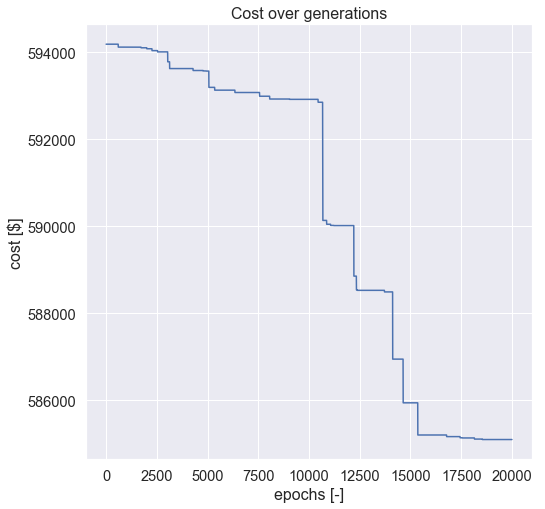

In [71]:
nb_seeds = 10 # number of seed sources : keep them along epochs
NB_MAX_EPOCHS = 20000
R_POP_LOST = 0.01# default 0.01
R_POP_MUT = 0.10
DELTA_DAYS = 5
# LOOP OVER GENERATIONS 
list_best_cost = []
t_fit_0 = time.time()
for gen_id in range(0, NB_MAX_EPOCHS):
    t_epoch_0 = time.time()
    print(" ")
    print("GENERATION #{} / nb. pop: {}".format(gen_id, df_pop.shape[0]))
    
    # Keep the best nb_seeds indiv. 
    df_cost_sort = df_cost.sort_values(by="cost")
    df_cost_sort["rank"] = range(1, df_cost.shape[0]+1)
    list_best_cost.append(df_cost_sort.iloc[0]["cost"])
    list_name_best = []
    #list_best_indiv = []
    for indice in range(0, nb_seeds):
        list_name_best.append(df_cost_sort.iloc[indice].name)
        #list_best_indiv.append(df_pop.loc[list_name_best[indice]])
    df_best = df_pop.loc[list_name_best]

    ############
    # LOST WORST INDIV.
    # Lost indiv. in population : R_POP_LOST
    # select random of R_POP_LOST of population 
    #   with prob = proportional to their rank
    df_cost_sort["prob"] = 1/df_cost_sort["rank"]
    df_cost_sort.iloc[0:nb_seeds,2] = 0 # 0 prob for the best (added after)
    df_cost_sort["prob"] = df_cost_sort["prob"] / df_cost_sort["prob"].sum()
    # determine  number survivors (have to be an even number)
    nb_survivor = int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)
    if (nb_survivor + 2 * nb_seeds) % 2 != 0:
        nb_survivor += 1
    print("nb_survivor: ", nb_survivor + 2 * nb_seeds)
    # select ramdomly survivors  (prob=1/rank)
    # keep best indiv
    vect_survivor = np.random.choice(df_cost_sort.index, replace=False,
                        size=nb_survivor, 
                        p=np.array(df_cost_sort["prob"]))
    # add best ones in first position
    vect_survivor = np.concatenate((np.array(df_cost_sort.index[0:nb_seeds]), 
                                    vect_survivor))

    df_pop = df_pop.loc[vect_survivor] 

    ############
    # CROSSOVER 

    # Do the Crossover between pair indiv.
    # 1 Cross point is ramdomly choosen (prob uniform)
    # example : 
    # 1-2-3\  /5-8-9-1-3-4-9  
    #       \/
    # 5-6-5/ \4-5-6-7-8-9-10
    #
    # give : 
    #
    # 1-2-3--4-5-6-7-8-9-10
    # 5-6-5--5-8-9-1-3-4-9 

    # create pairs : ramdomly
    arr_pairs = np.random.choice(df_pop.index, replace=False,
                        size=(int(df_pop.shape[0]/2), 2))
    # loop over pairs
    for id_0, id_1 in arr_pairs:
        # random point of crossover (among families)
        fam_id_cross = np.random.choice(df_pop.columns)
        # find parts of first new indiv
        vect_id_0_part_0 = df_pop.loc[id_0, range(0, fam_id_cross)]
        vect_id_0_part_1 = df_pop.loc[id_1, range(fam_id_cross, df_pop.shape[1])]
        # find parts of second new indiv
        vect_id_1_part_0 = df_pop.loc[id_1, range(0, fam_id_cross)]
        vect_id_1_part_1 = df_pop.loc[id_0, range(fam_id_cross, df_pop.shape[1])]    

        # replace 2 parents by 2 children
        df_pop.loc[id_0] = np.append(vect_id_0_part_0, vect_id_0_part_1)
        df_pop.loc[id_1] = np.append(vect_id_1_part_0, vect_id_1_part_1)

    ############
    # MUTATION
    # among pop, number of mutation = R_POP_MUT * number of indiv
    # df_pop = f(indiv, family)
    # nb of indiv. mutated :
    nb_mut = int(R_POP_MUT*df_pop.shape[0])
    # indice of mutated indiv.
    indice_mut = np.random.choice(df_pop.index, size=nb_mut)
    # number of family who mutate  for each mutated indiv. : R_MUT * nb families
    nb_fam_mut = int(R_MUT*df_pop.shape[1])
    # loop over indice of mutated indiv to apply mutation to number of family
    # who mutated :
    for indice in indice_mut:
        fam_mut = np.random.choice(df_pop.columns, size=nb_fam_mut)
        for fam_id in fam_mut:
            df_pop.loc[indice, fam_id] = \
                np.random.choice(find_day_range(df_pop.loc[indice, fam_id]))

    # add the best ones
    df_pop = df_pop.append(df_best, ignore_index=True)

    ############
    # EVALUATION
    # create cost dataFrame for all population
    df_cost = pd.DataFrame(index=df_pop.index)
    df_cost["cost"] = np.nan 
    
    for indice in df_cost.index:
        df_cost.at[indice,"cost"] = cost_function(df_pop.loc[indice].tolist())

    print(df_cost.sort_values(by="cost").head(1))
    t_epoch_1 = time.time()
    print("Timing epoch: ", t_epoch_1 - t_epoch_0)
    
# timing    
t_fit_1 = time.time()
print("Timing total: ", t_fit_1 - t_fit_0)
# figure
fig = plt.figure(figsize=(8, 8))
plt.plot(list_best_cost)
plt.title("Cost over generations")
ax = fig.gca()
ax.set_xlabel("epochs [-]")
ax.set_ylabel("cost [$]")

In [161]:
int(np.max([2, df_cost_sort.shape[0] - \
        np.ceil(R_POP_LOST*df_cost_sort.shape[0])]) - 2 * nb_seeds)

-2

In [ ]:
R_POP_LOST*df_cost_sort.shape[0]

#### Save results

In [74]:
# best score
#best_score = \
#cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

# POP
joblib.dump(df_pop,
    PATH_TO_SAVE_DATA + '/df_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)
# COST
joblib.dump(df_cost,
    PATH_TO_SAVE_DATA + '/df_cost_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

# submission
submission_final = pd.DataFrame(columns=["assigned_day"])
submission_final["assigned_day"] = \
    df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name]

joblib.dump(submission_final,
    PATH_TO_SAVE_DATA + \
            '/submission_pop{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)



joblib.dump(list_best_cost,
    PATH_TO_SAVE_DATA + \
            '/list_best_cost{}_fs{}_rfm{}_dd{}_rm{}_gen{}.pkl'.format(
                NB_FIRST_POP,
                NB_FIRST_SEED, 
                R_FIRST_MUT,
                DELTA_DAYS,
                R_POP_MUT, 
                NB_MAX_EPOCHS),
           compress=True)

['../../data/list_best_cost1000_fs10_rfm0.01_dd5_rm0.1_gen30000.pkl']

In [124]:

#df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name,:].to_csv("test.csv")

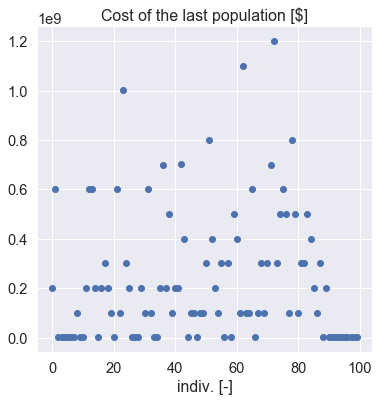

In [67]:
fig = plt.figure(figsize=(6, 6))
plt.title("Cost of the last population [$]")
plt.plot(df_cost["cost"], 'o')
ax = plt.gca()
ax.set_xlabel("indiv. [-]");
#ax.set_ylim([0 , 1e6])

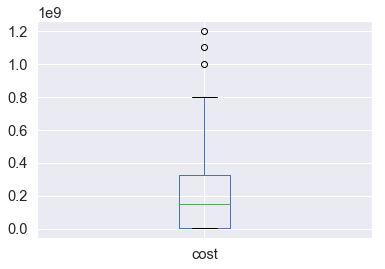

In [68]:
df_cost.boxplot()

In [72]:
cost_function(df_pop.loc[df_cost.sort_values(by="cost").iloc[0].name].tolist())

585102.5859791327

In [59]:
np.ceil(R_POP_LOST*df_cost_sort.shape[0])

10.0

In [60]:
nb_seeds

10

## Explore more

In [34]:
submission = pd.read_csv('submission_672254.0276683343.csv')
submission.head()

family_id  assigned_day
0          0            52
1          1            26
2          2           100
3          3             2
4          4            53

In [40]:
cost_function(submission['assigned_day'].tolist(), True)

penalty for only families:  666488
daily_occupancy:  {100: 127, 99: 127, 98: 128, 97: 127, 96: 168, 95: 201, 94: 212, 93: 126, 92: 135, 91: 126, 90: 143, 89: 189, 88: 226, 87: 219, 86: 126, 85: 125, 84: 127, 83: 131, 82: 161, 81: 185, 80: 203, 79: 126, 78: 139, 77: 126, 76: 126, 75: 170, 74: 196, 73: 206, 72: 126, 71: 126, 70: 128, 69: 127, 68: 169, 67: 210, 66: 238, 65: 125, 64: 129, 63: 126, 62: 139, 61: 179, 60: 208, 59: 235, 58: 207, 57: 154, 56: 154, 55: 179, 54: 214, 53: 228, 52: 244, 51: 202, 50: 151, 49: 195, 48: 214, 47: 249, 46: 269, 45: 257, 44: 220, 43: 186, 42: 205, 41: 232, 40: 241, 39: 265, 38: 231, 37: 194, 36: 160, 35: 183, 34: 215, 33: 251, 32: 277, 31: 269, 30: 242, 29: 254, 28: 272, 27: 284, 26: 293, 25: 295, 24: 280, 23: 265, 22: 254, 21: 256, 20: 264, 19: 288, 18: 294, 17: 283, 16: 273, 15: 267, 14: 270, 13: 284, 12: 298, 11: 291, 10: 280, 9: 260, 8: 261, 7: 259, 6: 281, 5: 296, 4: 291, 3: 291, 2: 271, 1: 294}
accounting_cost:  5766.027668334263


672254.0276683343

In [36]:
# function submission -> choice number
list_choice=[]
for fam_id in submission["family_id"]:
    assigned_day = submission.at[fam_id, "assigned_day"]
    list_choice.append(np.argmax((data.filter(items=['choice_{}'.\
                                 format(n) for n in range(0, 10)]).\
        loc[fam_id] == assigned_day).tolist()))

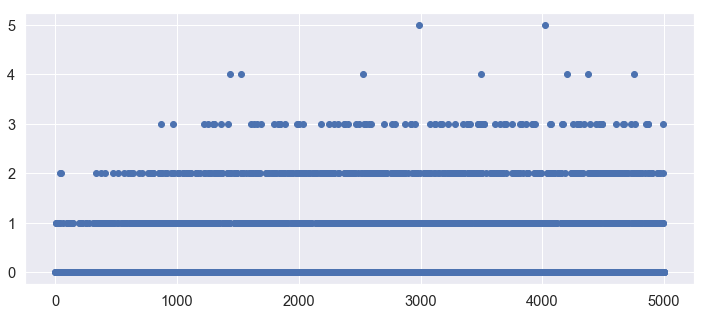

In [37]:
fig = plt.figure(figsize=(12, 5))
plt.plot(submission["family_id"], list_choice, 'o')

In [38]:
submission["choice"] = list_choice

In [39]:
submission["choice"].value_counts()

0    3535
1     946
2     416
3      94
4       7
5       2
Name: choice, dtype: int64